In [22]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import mne
from tqdm import tqdm
import h5py
import warnings
warnings.filterwarnings("ignore", category=UserWarning)






# Base path setup
base_dir = '/home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project'
raw_dir = os.path.join(base_dir, 'raw data')
results_dir = os.path.join(base_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

# Select subjects to analyze
subjects_to_analyze = ['EPCTL01', 'EPCTL02', 'EPCTL03', 'EPCTL04', 'EPCTL05', 'EPCTL06', 'EPCTL07', 'EPCTL08']

# Sleep stages to analyze
sleep_stages_to_analyze = [ 'N3', 'R' ]  # N1, N2, N3, and REM

# Load sleep stage annotations
def load_sleep_stages(annotation_path):
    """Load sleep stage annotations from TXT file"""
    stages = pd.read_csv(annotation_path, sep='\t', header=None, 
                         names=['stage', 'start_time', 'duration'])
    
    # Convert values to appropriate types
    stages['start_time'] = stages['start_time'].astype(float)
    stages['duration'] = stages['duration'].astype(float)
    
    # Calculate end time
    stages['end_time'] = stages['start_time'] + stages['duration']
    
    return stages

# Enhanced artifact detection matrix loading function
def load_artifacts(artifact_path):
    """Load artifact detection matrix from MAT file, supporting v7.3 format"""
    try:
        # First try using scipy.io.loadmat (for older MATLAB formats)
        artifacts = loadmat(artifact_path)
        print("Successfully loaded artifact matrix using scipy.io.loadmat")
    except NotImplementedError:
        # If it's v7.3 format, use h5py
        f = h5py.File(artifact_path, 'r')
        print("HDF5 file keys:", list(f.keys()))
        
        # Try to get the artifact matrix
        if 'artndxn' in f:
            artifacts = f['artndxn'][()]
            if len(artifacts.shape) > 1:
                artifacts = artifacts.T  # Transpose to match Python's row-first order
            print("Successfully loaded artifact matrix using h5py")
        else:
            print("Could not find 'artndxn' key in file, returning whole file object")
            artifacts = f
    
    # Print keys to understand structure (if artifacts has a keys method)
    if hasattr(artifacts, 'keys'):
        print("Artifact file keys:", list(artifacts.keys()))
    
    return artifacts

# Detrended Fluctuation Analysis (DFA)
def dfa(data, scale_min=4, scale_max=None, scale_res=15):
    """Perform Detrended Fluctuation Analysis"""
    N = len(data)
    if scale_max is None:
        scale_max = N // 4
    
    # Generate logarithmically spaced scales
    scales = np.logspace(np.log10(scale_min), np.log10(scale_max), scale_res).astype(int)
    scales = np.unique(scales)  # Remove duplicates
    
    # Calculate the profile (cumulative sum of deviations from the mean)
    profile = np.cumsum(data - np.mean(data))
    
    fluct = np.zeros(len(scales))
    
    for i, scale in enumerate(scales):
        # Number of segments
        n_segments = int(np.floor(N / scale))
        
        # Initialize fluctuation for this scale
        fluct_scale = 0
        
        for j in range(n_segments):
            # Extract segment
            segment = profile[j*scale:(j+1)*scale]
            
            # Fit polynomial (detrending)
            x = np.arange(scale)
            p = np.polyfit(x, segment, 1)
            trend = np.polyval(p, x)
            
            # Calculate root mean square fluctuation
            fluct_scale += np.sum((segment - trend) ** 2)
        
        # Calculate average fluctuation for this scale
        fluct[i] = np.sqrt(fluct_scale / (n_segments * scale))
    
    # Fit a line to the log-log plot to get the scaling exponent
    log_scales = np.log10(scales)
    log_fluct = np.log10(fluct)
    p = np.polyfit(log_scales, log_fluct, 1)
    alpha = p[0]  # Scaling exponent
    
    return scales, fluct, alpha

# Calculate weighted Phase Lag Index (wPLI)
def compute_wpli(data1, data2, fs, window_sec=4, overlap=0.5):
    """Calculate weighted Phase Lag Index between two signals"""
    window_length = int(window_sec * fs)
    noverlap = int(window_length * overlap)
    
    # Calculate cross-spectral density
    f, Pxy = signal.csd(data1, data2, fs, nperseg=window_length, noverlap=noverlap)
    
    # Extract imaginary part of cross-spectrum
    imag_Pxy = np.imag(Pxy)
    
    # Calculate wPLI
    wpli = np.abs(np.mean(imag_Pxy)) / np.mean(np.abs(imag_Pxy))
    
    return wpli

def compute_wpli_matrix(data, fs, window_sec=4, overlap=0.5, max_channels=9):
    """Compute wPLI matrix for a subset of channels"""
    n_channels = min(data.shape[0], max_channels)
    wpli_matrix = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            wpli = compute_wpli(data[i], data[j], fs, window_sec, overlap)
            wpli_matrix[i, j] = wpli
            wpli_matrix[j, i] = wpli
    
    return wpli_matrix

# Analyze sleep stage using MNE
def analyze_sleep_stage_mne(edf_path, stages, stage_to_analyze, artifact_path=None, max_duration=60):
    """Analyze a specific sleep stage using MNE with memory-efficient loading"""
    # Get segments for the specified stage
    stage_segments = stages[stages['stage'] == stage_to_analyze]
    
    if len(stage_segments) == 0:
        print(f"No {stage_to_analyze} sleep stage found.")
        return None
    
    # Initialize raw EEG data object
    print(f"Reading EDF file: {edf_path}")
    try:
        # Read EDF file using MNE, but don't load into memory yet
        raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=True)
        print(f"EDF file info: {raw.info}")
    except Exception as e:
        print(f"Error reading EDF file: {e}")
        return None
    
    # Process segments to avoid memory issues
    results = {'frequency_bands': {}, 'wpli': {}}
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'gamma': (30, 45)
    }
    
    # Initialize data containers for each frequency band
    all_band_data = {band: [] for band in bands.keys()}
    
    # Process up to max_duration seconds
    total_duration = 0
    for _, segment in tqdm(stage_segments.iterrows(), desc=f"Processing {stage_to_analyze} segments"):
        start_time = segment['start_time']
        duration = segment['duration']
        
        if total_duration + duration > max_duration:
            duration = max_duration - total_duration
        
        # Skip very short segments
        if duration < 5:  # Skip segments shorter than 5 seconds
            continue
        
        # Crop raw data to segment of interest
        print(f"Loading segment from {start_time}s to {start_time+duration}s")
        try:
            segment_raw = raw.copy().crop(tmin=start_time, tmax=start_time+duration)
            segment_raw.load_data()  # Now load data into memory
        except Exception as e:
            print(f"Error cropping data: {e}")
            continue
        
        # Get sampling frequency
        fs = segment_raw.info['sfreq']
        
        # Process each frequency band
        for band_name, (low_freq, high_freq) in bands.items():
            # Copy raw segment to avoid modifying original data
            band_raw = segment_raw.copy()
            
            # Apply bandpass filter for this band
            print(f"Filtering {band_name} band: {low_freq}-{high_freq} Hz")
            band_raw.filter(l_freq=low_freq, h_freq=high_freq, verbose=False)
            
            # Get filtered data array
            band_data = band_raw.get_data()
            all_band_data[band_name].append(band_data)
        
        total_duration += duration
        if total_duration >= max_duration:
            print(f"Reached maximum duration of {max_duration} seconds")
            break
    
    # Save channel names
    channel_names = raw.ch_names
    results['channel_names'] = channel_names
    
    # Process cumulative data for each frequency band
    for band_name, band_segments in all_band_data.items():
        if not band_segments:
            print(f"No data for {band_name} band")
            continue
            
        # Get number of channels from first segment
        n_channels = band_segments[0].shape[0]
        alphas = np.zeros(n_channels)
        
        # Calculate DFA for each channel
        for ch in tqdm(range(n_channels), desc=f"Calculating DFA for {band_name} band"):
            # Concatenate data for this channel across all segments
            channel_data = np.concatenate([segment[ch] for segment in band_segments])
            
            # Calculate DFA
            try:
                _, _, alpha = dfa(channel_data)
                alphas[ch] = alpha
            except Exception as e:
                print(f"Error calculating DFA for channel {ch}: {e}")
                alphas[ch] = np.nan
        
        # Store results
        results['frequency_bands'][band_name] = {
            'alphas': alphas
        }
        
        # Calculate wPLI for representative segment (first segment)
        # Use only a subset of channels
        max_channels_for_wpli = min(15, n_channels)  # Limit to max 15 channels
        try:
            wpli_matrix = compute_wpli_matrix(
                band_segments[0][:max_channels_for_wpli], 
                fs, 
                window_sec=4, 
                overlap=0.5,
                max_channels=max_channels_for_wpli
            )
            results['wpli'][band_name] = wpli_matrix
        except Exception as e:
            print(f"Error calculating wPLI for {band_name} band: {e}")
            results['wpli'][band_name] = np.zeros((max_channels_for_wpli, max_channels_for_wpli))
    
    return results

# Process a single subject
def process_subject(subject_id, max_duration=60):
    """Process data for a single subject, analyzing multiple sleep stages"""
    print(f"\n{'='*50}")
    print(f"Starting processing for subject: {subject_id}")
    print(f"{'='*50}")
    
    # Set up paths
    subject_dir = os.path.join(raw_dir, subject_id)
    output_dir = os.path.join(results_dir, subject_id)
    os.makedirs(output_dir, exist_ok=True)
    
    # Get file paths
    try:
        files = os.listdir(subject_dir)
    except FileNotFoundError:
        print(f"Error: Subject directory {subject_dir} not found")
        return None
    
    edf_files = [f for f in files if f.endswith('.edf')]
    txt_files = [f for f in files if f.endswith('.txt')]
    mat_files = [f for f in files if f.endswith('.mat')]
    
    if not edf_files:
        print(f"Error: No EDF files found for subject {subject_id}")
        return None
    
    if not txt_files:
        print(f"Error: No sleep stage annotation files found for subject {subject_id}")
        return None
    
    edf_path = os.path.join(subject_dir, edf_files[0])
    txt_path = os.path.join(subject_dir, txt_files[0])
    artifact_path = os.path.join(subject_dir, mat_files[0]) if mat_files else None
    
    print(f"EDF file: {edf_path}")
    print(f"Annotation file: {txt_path}")
    print(f"Artifact file: {artifact_path}")
    
    # Load sleep stages
    stages = load_sleep_stages(txt_path)
    print(f"Loaded {len(stages)} sleep stage annotations")
    
    # Display sample of sleep stages
    print("Sleep stage annotation sample:")
    print(stages.head())
    
    # Count stages
    stage_counts = stages['stage'].value_counts()
    print("Sleep stage distribution:")
    print(stage_counts)
    
    # Load artifacts (if available)
    artifacts = None
    if artifact_path:
        try:
            artifacts = load_artifacts(artifact_path)
            if hasattr(artifacts, 'shape'):
                print(f"Loaded artifact matrix with shape {artifacts.shape}")
            else:
                print("Loaded artifact data (non-matrix)")
        except Exception as e:
            print(f"Error loading artifact file: {e}")
    
    # Initialize results dictionary for all sleep stages
    all_stage_results = {}
    
    # Process each sleep stage
    for stage in sleep_stages_to_analyze:
        if stage in stage_counts.index:
            print(f"\nAnalyzing {stage} sleep stage...")
            stage_results = analyze_sleep_stage_mne(edf_path, stages, stage, artifacts, max_duration=max_duration)
            
            if stage_results is not None:
                all_stage_results[stage] = stage_results
                
                # Save individual stage results
                np.save(os.path.join(output_dir, f'results_{stage}.npy'), stage_results)
                
                # Plot DFA scaling exponents for each frequency band for this stage
                plt.figure(figsize=(12, 8))
                for band_name, band_results in stage_results['frequency_bands'].items():
                    band_alphas = band_results['alphas']
                    plt.plot(range(len(band_alphas)), band_alphas, 'o-', label=band_name)
                
                plt.xlabel('Channel')
                plt.ylabel('DFA Scaling Exponent')
                plt.title(f'{subject_id} - {stage} Stage DFA Scaling Exponents by Frequency Band')
                plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
                plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
                plt.legend()
                plt.savefig(os.path.join(output_dir, f'dfa_alphas_bands_{stage}.png'))
                
                # Plot average scaling exponent for each frequency band
                plt.figure(figsize=(10, 6))
                band_names = list(stage_results['frequency_bands'].keys())
                mean_alphas = [np.mean(stage_results['frequency_bands'][band]['alphas']) for band in band_names]
                std_alphas = [np.std(stage_results['frequency_bands'][band]['alphas']) for band in band_names]
                
                plt.bar(band_names, mean_alphas, yerr=std_alphas, capsize=10)
                plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
                plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
                plt.xlabel('Frequency Band')
                plt.ylabel('Average DFA Scaling Exponent')
                plt.title(f'{subject_id} - {stage} Stage Average DFA Scaling Exponent by Frequency Band')
                plt.legend()
                plt.savefig(os.path.join(output_dir, f'mean_dfa_alphas_bands_{stage}.png'))
                
                # Plot wPLI matrix for each frequency band
                for band_name, wpli_matrix in stage_results['wpli'].items():
                    plt.figure(figsize=(10, 8))
                    im = plt.imshow(wpli_matrix, cmap='viridis', vmin=0, vmax=1)
                    plt.colorbar(im, label='wPLI')
                    plt.title(f'{subject_id} - {stage} Stage {band_name} Band Weighted Phase Lag Index (wPLI)')
                    plt.savefig(os.path.join(output_dir, f'wpli_matrix_{stage}_{band_name}.png'))
                
                # Save channel-level results to CSV
                for band_name, band_results in stage_results['frequency_bands'].items():
                    df = pd.DataFrame({
                        'channel': stage_results['channel_names'][:len(band_results['alphas'])],
                        'dfa_alpha': band_results['alphas']
                    })
                    df.to_csv(os.path.join(output_dir, f'dfa_alphas_{stage}_{band_name}.csv'), index=False)
                
                print(f"{stage} stage analysis completed.")
            else:
                print(f"{stage} stage analysis failed.")
        else:
            print(f"No {stage} stage found in the data, skipping analysis.")
    
    # Save combined results
    np.save(os.path.join(output_dir, 'all_stage_results.npy'), all_stage_results)
    
    # Compare sleep stages if we have at least two stages analyzed
    if len(all_stage_results) >= 2:
        compare_sleep_stages(all_stage_results, subject_id, output_dir)
    
    print(f"\nSubject {subject_id} analysis completed.")
    print(f"Analyzed {len(all_stage_results)}/{len(sleep_stages_to_analyze)} sleep stages.")
    
    return all_stage_results

# Compare sleep stages for a single subject
def compare_sleep_stages(all_stage_results, subject_id, output_dir):
    """Compare results across different sleep stages for a single subject"""
    print("\nComparing sleep stages...")
    
    # Create comparison directory
    comparison_dir = os.path.join(output_dir, 'stage_comparison')
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Get list of stages and frequency bands
    stages = list(all_stage_results.keys())
    bands = list(all_stage_results[stages[0]]['frequency_bands'].keys())
    
    # Compare average DFA scaling exponents across sleep stages
    comparison_data = {band: [] for band in bands}
    
    for band in bands:
        for stage in stages:
            # Get mean alpha for this band and stage
            alphas = all_stage_results[stage]['frequency_bands'][band]['alphas']
            mean_alpha = np.mean(alphas)
            comparison_data[band].append(mean_alpha)
    
    # Create comparison dataframe
    df = pd.DataFrame(comparison_data, index=stages)
    
    # Save to CSV
    df.to_csv(os.path.join(comparison_dir, 'stage_comparison_dfa.csv'))
    
    # Create bar plot for each frequency band
    plt.figure(figsize=(20, 12))
    
    # Calculate bar positions
    bar_width = 0.15
    r = np.arange(len(stages))
    
    # Plot bars for each frequency band
    for i, band in enumerate(bands):
        plt.bar(r + i*bar_width, comparison_data[band], width=bar_width, label=band)
    
    # Add reference lines
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
    plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
    
    # Set labels and title
    plt.xlabel('Sleep Stage')
    plt.ylabel('Average DFA Scaling Exponent')
    plt.title(f'{subject_id} - Comparison of DFA Scaling Exponents Across Sleep Stages')
    plt.xticks(r + bar_width*2, stages)
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(comparison_dir, 'stage_comparison_dfa.png'))
    
    # Create boxplots for each band comparing stages
    for band in bands:
        plt.figure(figsize=(10, 6))
        
        # Prepare data for boxplot
        data = [all_stage_results[stage]['frequency_bands'][band]['alphas'] for stage in stages]
        
        # Create boxplot
        plt.boxplot(data, labels=stages)
        
        # Add reference lines
        plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
        plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
        
        # Set labels and title
        plt.xlabel('Sleep Stage')
        plt.ylabel('DFA Scaling Exponent')
        plt.title(f'{subject_id} - {band} Band DFA Scaling Exponent Across Sleep Stages')
        plt.legend()
        
        # Save figure
        plt.savefig(os.path.join(comparison_dir, f'stage_comparison_boxplot_{band}.png'))
    
    # Compare wPLI matrices
    for band in bands:
        plt.figure(figsize=(15, 10))
        
        # Determine number of columns and rows for subplot grid
        n_stages = len(stages)
        n_cols = min(n_stages, 2)
        n_rows = (n_stages + n_cols - 1) // n_cols
        
        # Create subplots
        for i, stage in enumerate(stages):
            plt.subplot(n_rows, n_cols, i+1)
            
            # Get wPLI matrix for this stage and band
            wpli_matrix = all_stage_results[stage]['wpli'][band]
            
            # Plot wPLI matrix
            im = plt.imshow(wpli_matrix, cmap='viridis', vmin=0, vmax=1)
            plt.colorbar(im, label='wPLI')
            plt.title(f'{stage} - {band} Band')
        
        # Add overall title
        plt.suptitle(f'{subject_id} - Comparison of wPLI Matrices Across Sleep Stages ({band} Band)')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save figure
        plt.savefig(os.path.join(comparison_dir, f'stage_comparison_wpli_{band}.png'))
    
    print("Sleep stage comparison completed.")

# Compare subjects
def compare_subjects(all_results, output_dir):
    """Compare analysis results across all subjects"""
    print("\nPerforming inter-subject comparison...")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of stages and subjects
    all_stages = sleep_stages_to_analyze
    subjects = list(all_results.keys())
    
    # For each sleep stage, compare across subjects
    for stage in all_stages:
        # Check which subjects have data for this stage
        subjects_with_stage = [subj for subj in subjects if stage in all_results[subj]]
        
        if len(subjects_with_stage) < 2:
            print(f"Not enough subjects with {stage} stage data for comparison, skipping.")
            continue
        
        print(f"Comparing {stage} stage across {len(subjects_with_stage)} subjects...")
        
        # Get frequency bands from first subject
        bands = list(all_results[subjects_with_stage[0]][stage]['frequency_bands'].keys())
        
        # Create comparison data for each band
        comparison_data = {}
        
        for band in bands:
            # Extract mean DFA value for each subject in this band and stage
            means = [np.mean(all_results[subj][stage]['frequency_bands'][band]['alphas']) 
                     for subj in subjects_with_stage]
            
            comparison_data[band] = means
        
        # Create DataFrame
        df = pd.DataFrame(comparison_data, index=subjects_with_stage)
        
        # Save to CSV
        df.to_csv(os.path.join(output_dir, f'all_subjects_{stage}_comparison.csv'))
        
        # Create bar chart
       
        plt.figure(figsize=(20, 12))
        # Calculate bar positions
        bar_width = 0.1
        r = np.arange(len(subjects_with_stage))
        
        # Plot bars for each frequency band
        for i, band in enumerate(bands):
            plt.bar(r + i*bar_width, comparison_data[band], width=bar_width, label=band)
        
        # Add reference lines
        plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
        plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
        
        # Set labels and title
        plt.xlabel('Subject ID')
        plt.ylabel('Average DFA Scaling Exponent')
        plt.title(f'Comparison of {stage} Stage DFA Scaling Exponents Across Subjects')
        plt.xticks(r + bar_width*len(bands)/2, subjects_with_stage, rotation=60)
        plt.tight_layout(pad=2.0)
        plt.legend()
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(output_dir, f'all_subjects_{stage}_comparison.png'))
        
        # Create boxplot for each band
      
        plt.figure(figsize=(20, 12))
        # Prepare boxplot data
        boxplot_data = []
        
        for band in bands:
            band_data = []
            for subj in subjects_with_stage:
                alphas = all_results[subj][stage]['frequency_bands'][band]['alphas']
                for alpha in alphas:
                    if not np.isnan(alpha):
                        band_data.append(alpha)
            boxplot_data.append(band_data)
        
        # Create boxplot
        plt.boxplot(boxplot_data, labels=bands)
        
        # Add reference lines
        plt.axhline(y=0.5, color='r', linestyle='--', label='Random (alpha=0.5)')
        plt.axhline(y=1.0, color='g', linestyle='--', label='1/f (alpha=1.0)')
        
        # Set labels and title
        plt.xlabel('Frequency Band')
        plt.ylabel('DFA Scaling Exponent')
        plt.title(f'Distribution of {stage} Stage DFA Scaling Exponents Across All Subjects')
        plt.legend()
        
        # Save figure
        plt.savefig(os.path.join(output_dir, f'all_subjects_{stage}_boxplot.png'))
    
    print("Inter-subject comparison completed, results saved.")




In [23]:
# Main function
def main():
    """Process multiple subjects and compare results across sleep stages and subjects"""
    # Store results for all subjects
    all_subjects_results = {}
    
    for i, subject_id in enumerate(subjects_to_analyze):
        print(f"\nProcessing subject {i+1}/{len(subjects_to_analyze)}: {subject_id}")
        results = process_subject(subject_id, max_duration=60)
        if results is not None:
            all_subjects_results[subject_id] = results
    # If we have at least two subjects, perform inter-subject comparison
    if len(all_subjects_results) >= 2:
        compare_subjects(all_subjects_results, os.path.join(results_dir, 'comparison'))
    
    print("\nAll subjects analysis completed.")
    print(f"Successfully analyzed {len(all_subjects_results)}/{len(subjects_to_analyze)} subjects.")



Processing subject 1/8: EPCTL01

Starting processing for subject: EPCTL01
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL01/EPCTL01.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL01/test1.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL01/EPCTL01_artndxn.mat
Loaded 958 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     W         0.0      30.0      30.0
1     W        30.0      30.0      60.0
2    N1        60.0      30.0      90.0
3    N1        90.0      30.0     120.0
4    N1       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    471
N3    185
R     176
N1     74
W      46
L       6
Name: count, dtype: int64
HDF5 file keys: ['artndxn', 'visgood', 'visnum']
Successfully loaded artifact matrix using h5py
Loaded artifact matrix w

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 1140.0s to 1170.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.56it/s]

Loading segment from 1170.0s to 1200.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.29s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:26<00:00,  3.51s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL01/EPCTL01.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL01/EPCTL01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 15:40:20 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 6840.0s to 6870.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.56it/s]

Loading segment from 6900.0s to 6930.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.30s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:27<00:00,  3.52s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL01 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 2/8: EPCTL02

Starting processing for subject: EPCTL02
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL02/EPCTL02.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL02/test2.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL02/EPCTL02_artndxn.mat
Loaded 1073 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    492
W     195
N3    176
N1     84
R      70
L      56
Name: count, dtype: int64
HDF5 file keys: ['art

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 2550.0s to 2580.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.53it/s]

Loading segment from 2580.0s to 2610.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.31s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:27<00:00,  3.52s/it]
/tmp/ipykernel_100509/3943329303.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL02/EPCTL02.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL02/EPCTL02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 16:00:47 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 13830.0s to 13860.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.52it/s]

Loading segment from 13860.0s to 13890.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.32s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:26<00:00,  3.52s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL02 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 3/8: EPCTL03

Starting processing for subject: EPCTL03
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL03/EPCTL03.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL03/EPCTL03.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL03/EPCTl03_artndxn.mat
Loaded 843 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    305
N3    207
R     127
L      82
N1     66
W      56
Name: count, dtype: int64
HDF5 file keys: ['ar

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 3090.0s to 3120.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.60it/s]

Loading segment from 3120.0s to 3150.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.25s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:39<00:00,  3.65s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL03/EPCTL03.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL03/EPCTL03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 16:16:56 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 6840.0s to 6870.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.54it/s]

Loading segment from 7050.0s to 7080.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.30s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:28<00:00,  3.53s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL03 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 4/8: EPCTL04

Starting processing for subject: EPCTL04
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL04/EPCTL04.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL04/EPCTL04.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL04/EPCTL04_artndex.mat
Loaded 763 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
W     228
N2    214
N3    124
N1     95
R      74
L      28
Name: count, dtype: int64
HDF5 file keys: ['ar

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 7890.0s to 7920.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.60it/s]

Loading segment from 7920.0s to 7950.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.25s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:28<00:00,  3.54s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL04/EPCTL04.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL04/EPCTL04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 16:47:01 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 13560.0s to 13590.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.63it/s]

Loading segment from 13590.0s to 13620.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.23s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:27<00:00,  3.52s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL04 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 5/8: EPCTL05

Starting processing for subject: EPCTL05
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL05/EPCTL05.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL05/EPCTL05.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL05/EPCTL05_artdnex.mat
Loaded 756 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    309
N3    170
R     132
N1     71
W      47
L      27
Name: count, dtype: int64
HDF5 file keys: ['ar

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 2310.0s to 2340.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.62it/s]

Loading segment from 2340.0s to 2370.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.23s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:28<00:00,  3.53s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL05/EPCTL05.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL05/EPCTL05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4-, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 16:57:48 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 6450.0s to 6480.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.62it/s]

Loading segment from 6480.0s to 6510.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.24s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:39<00:00,  3.65s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL05 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 6/8: EPCTL06

Starting processing for subject: EPCTL06
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL06/EPCTL06.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL06/EPCTL06.txt
Artifact file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL06/EPCTL06_artndxn.mat
Loaded 919 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    374
N3    154
W     147
R     134
N1     77
L      33
Name: count, dtype: int64
HDF5 file keys: ['ar

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 2790.0s to 2820.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.52it/s]

Loading segment from 3240.0s to 3270.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.33s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:29<00:00,  3.54s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL06/EPCTL06.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL06/EPCTL06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 17:17:06 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 9690.0s to 9720.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.57it/s]

Loading segment from 9720.0s to 9750.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.28s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:30<00:00,  3.55s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL06 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 7/8: EPCTL07

Starting processing for subject: EPCTL07
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL07/EPCTL07.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL07/EPCTL07.txt
Artifact file: None
Loaded 980 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    397
N3    181
W     113
R     104
N1     96
L      89
Name: count, dtype: int64

Analyzing N3 sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw d

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 3600.0s to 3630.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.55it/s]

Loading segment from 3630.0s to 3660.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.29s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:27<00:00,  3.53s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL07/EPCTL07.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL07/EPCTL07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 20:35:54 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 5880.0s to 5910.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.56it/s]

Loading segment from 5910.0s to 5940.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.28s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:28<00:00,  3.53s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL07 analysis completed.
Analyzed 2/2 sleep stages.

Processing subject 8/8: EPCTL08

Starting processing for subject: EPCTL08
EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL08/EPCTL08.edf
Annotation file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL08/EPCTL08.txt
Artifact file: None
Loaded 873 sleep stage annotations
Sleep stage annotation sample:
  stage  start_time  duration  end_time
0     L         0.0      30.0      30.0
1     L        30.0      30.0      60.0
2     L        60.0      30.0      90.0
3     L        90.0      30.0     120.0
4     L       120.0      30.0     150.0
Sleep stage distribution:
stage
N2    334
N3    165
W     125
L      87
N1     83
R      79
Name: count, dtype: int64

Analyzing N3 sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw d

Processing N3 segments: 0it [00:00, ?it/s]

Loading segment from 5640.0s to 5670.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:00,  1.59it/s]

Loading segment from 5670.0s to 5700.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing N3 segments: 1it [00:01,  1.26s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:26<00:00,  3.51s/it]


N3 stage analysis completed.

Analyzing R sleep stage...
Reading EDF file: /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL08/EPCTL08.edf
Extracting EDF parameters from /home/ningb1/.jupyterhub-tree/m/nbe/scratch/aginglst/code/bo_folder/sleep project/raw data/EPCTL08/EPCTL08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file info: <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 93 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-12-20 21:07:33 UTC
 nchan: 93
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


Processing R segments: 0it [00:00, ?it/s]

Loading segment from 10350.0s to 10380.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:00,  1.58it/s]

Loading segment from 10380.0s to 10410.0s
Reading 0 ... 30000  =      0.000 ...    30.000 secs...
Filtering delta band: 0.5-4 Hz
Filtering theta band: 4-8 Hz
Filtering gamma band: 30-45 Hz


Processing R segments: 1it [00:01,  1.26s/it]


Reached maximum duration of 60 seconds


Calculating DFA for gamma band: 100%|██████████| 93/93 [05:27<00:00,  3.52s/it]


R stage analysis completed.

Comparing sleep stages...


/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)
/tmp/ipykernel_100509/3943329303.py:481: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Sleep stage comparison completed.

Subject EPCTL08 analysis completed.
Analyzed 2/2 sleep stages.

Performing inter-subject comparison...
Comparing N3 stage across 8 subjects...


/tmp/ipykernel_100509/3943329303.py:611: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=bands)


Comparing R stage across 8 subjects...


/tmp/ipykernel_100509/3943329303.py:611: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=bands)


Inter-subject comparison completed, results saved.

All subjects analysis completed.
Successfully analyzed 8/8 subjects.


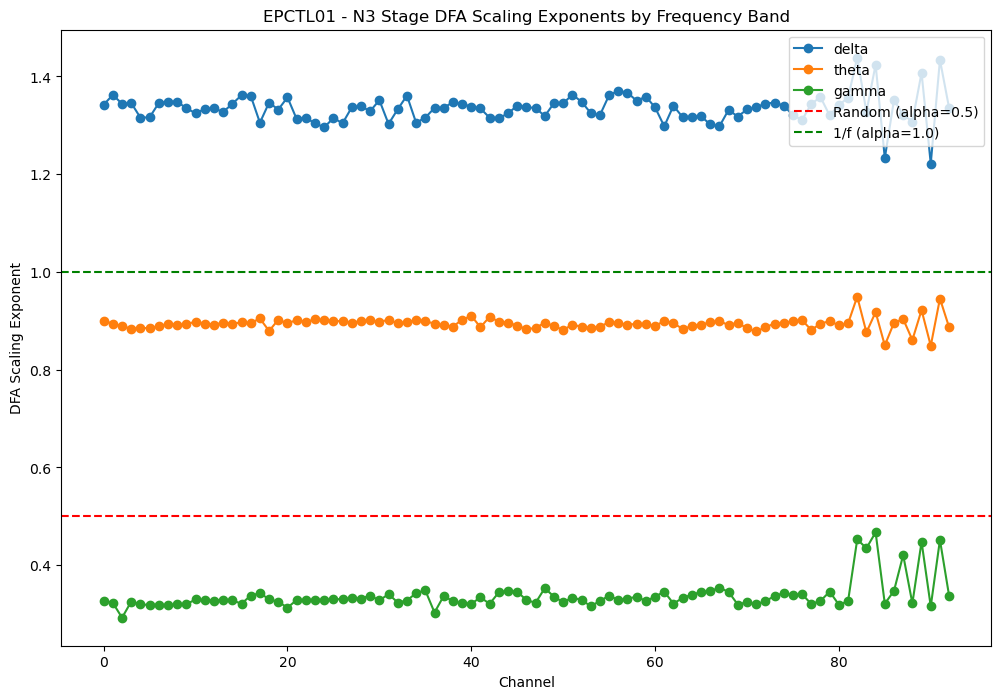

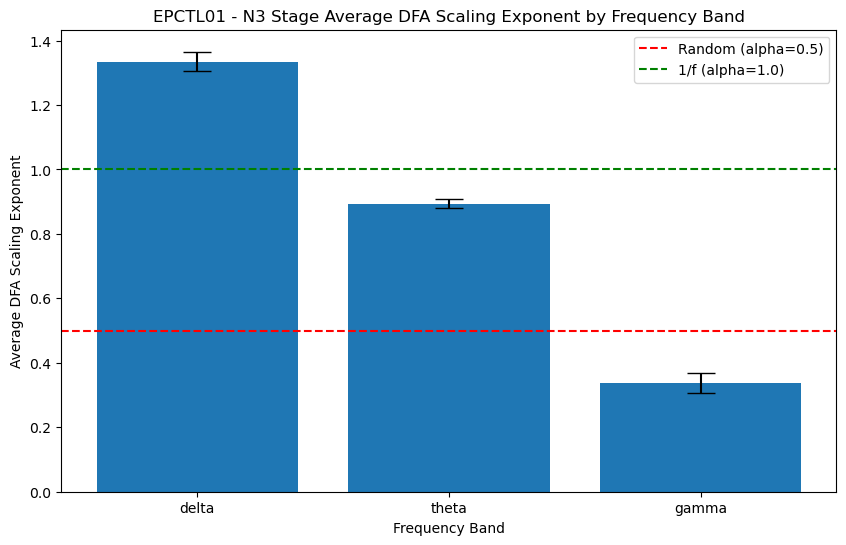

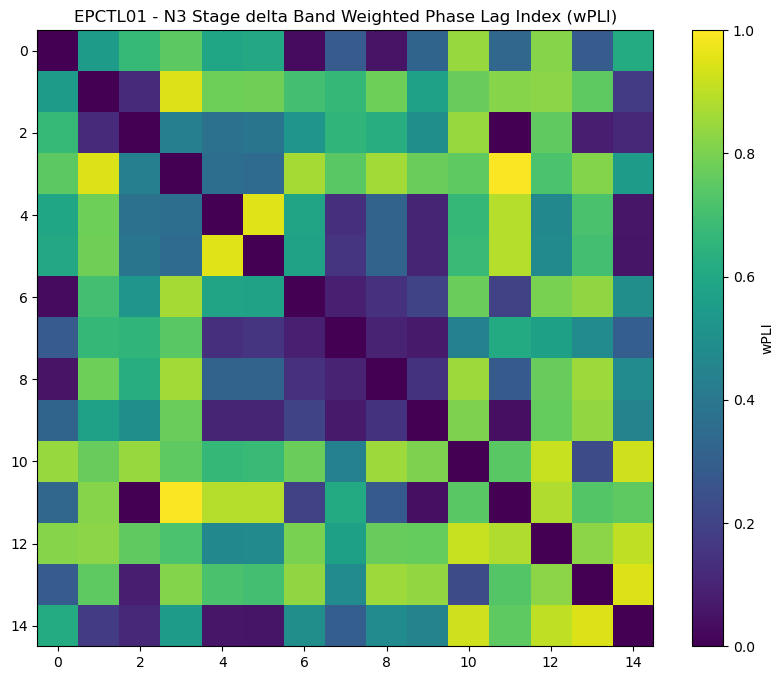

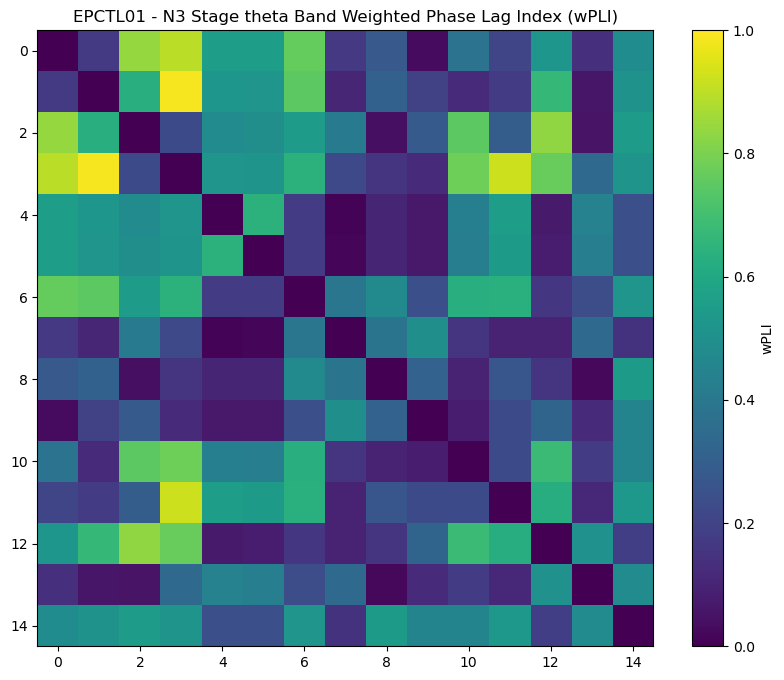

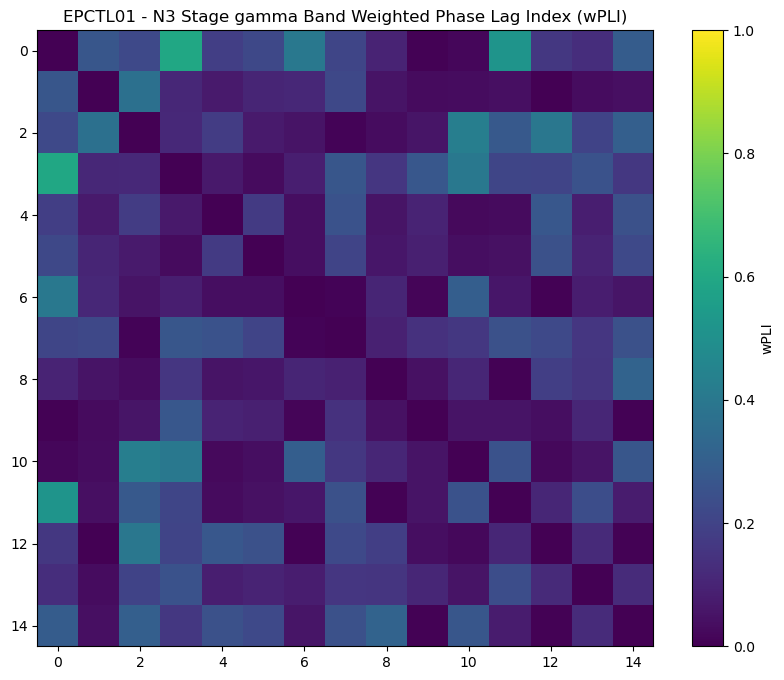

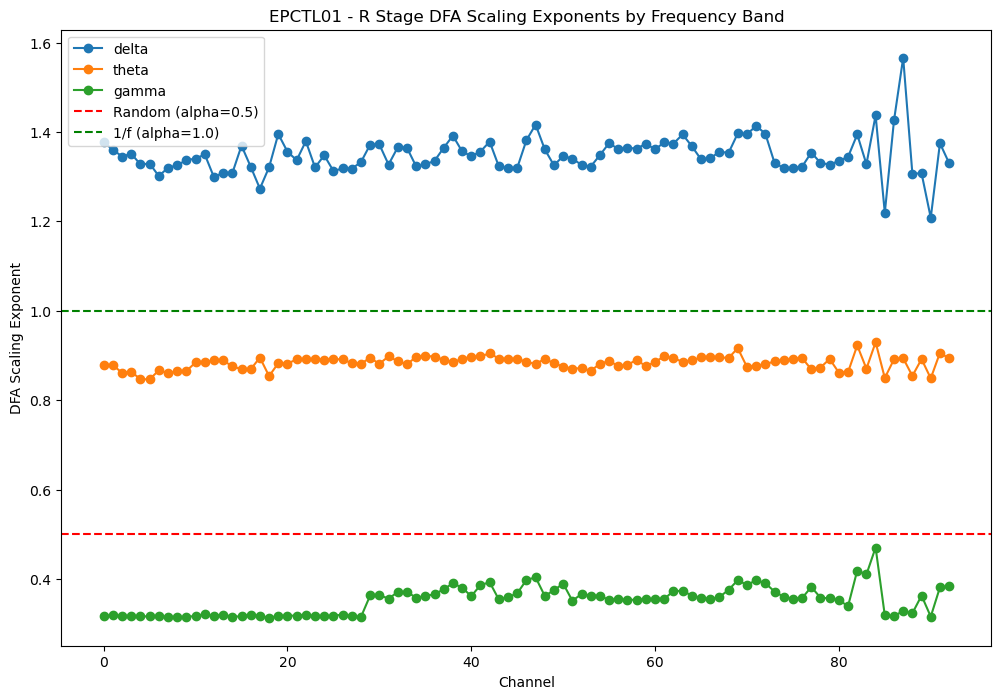

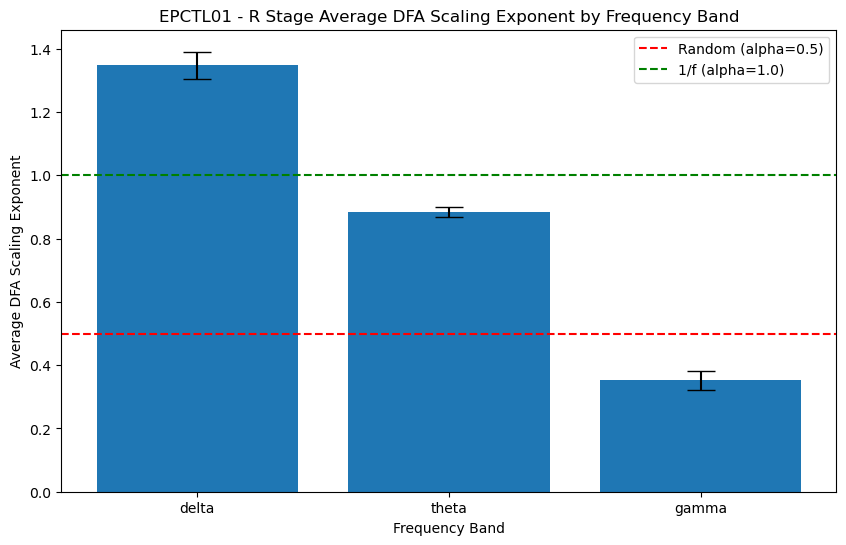

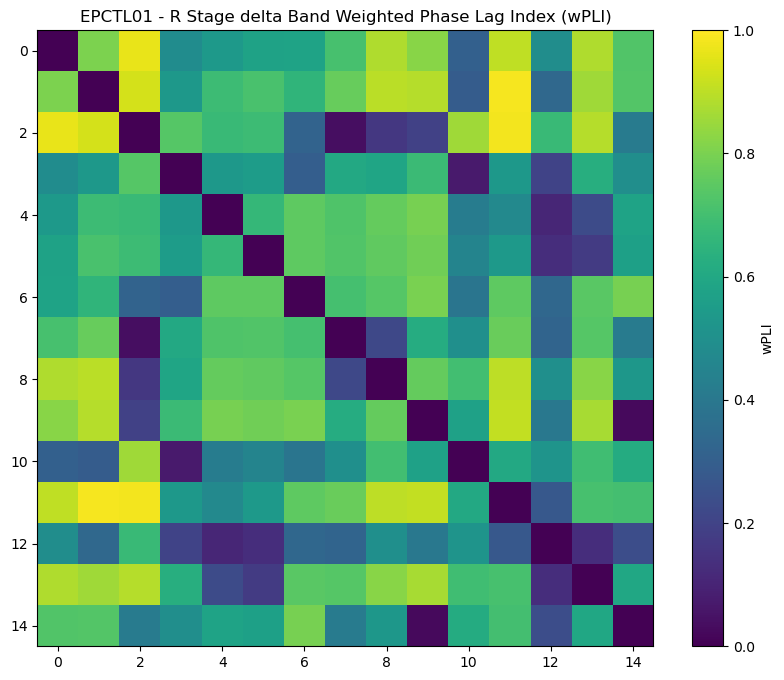

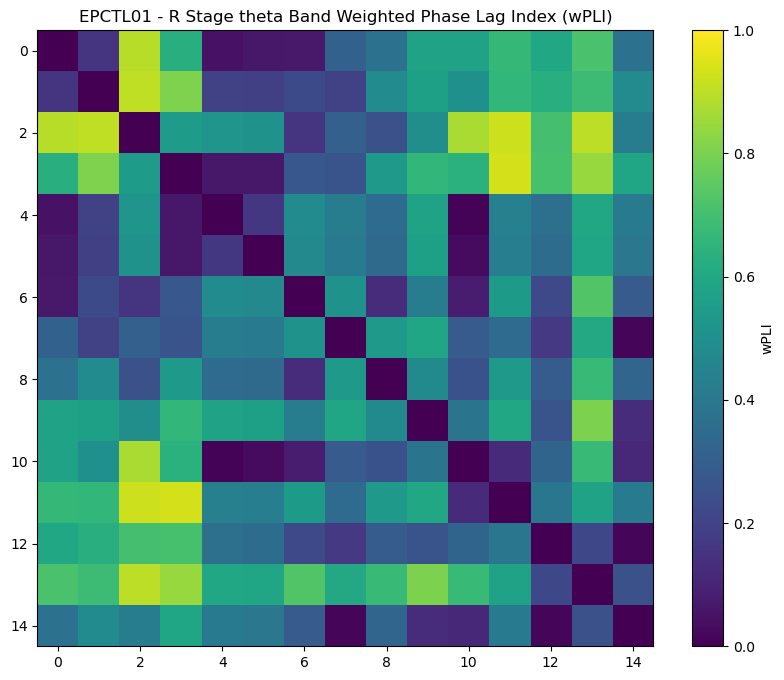

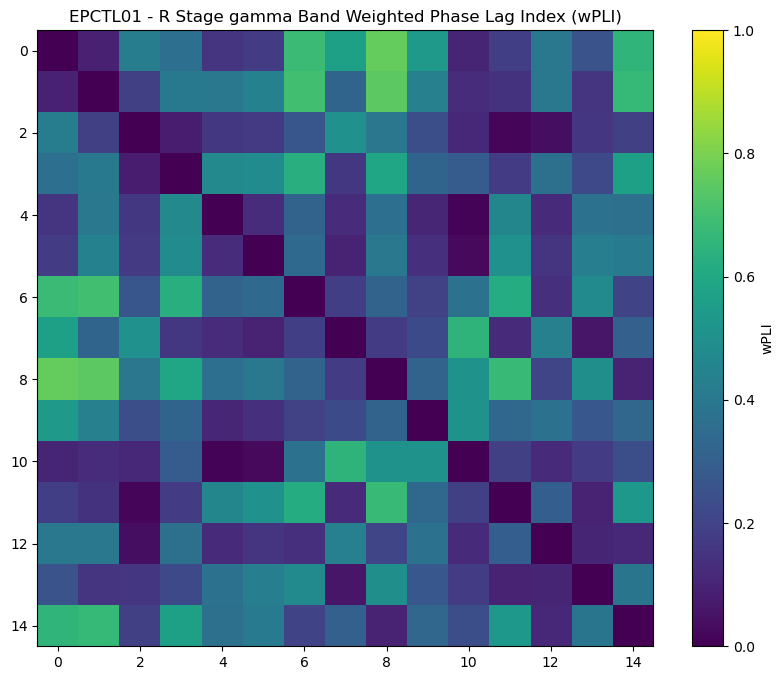

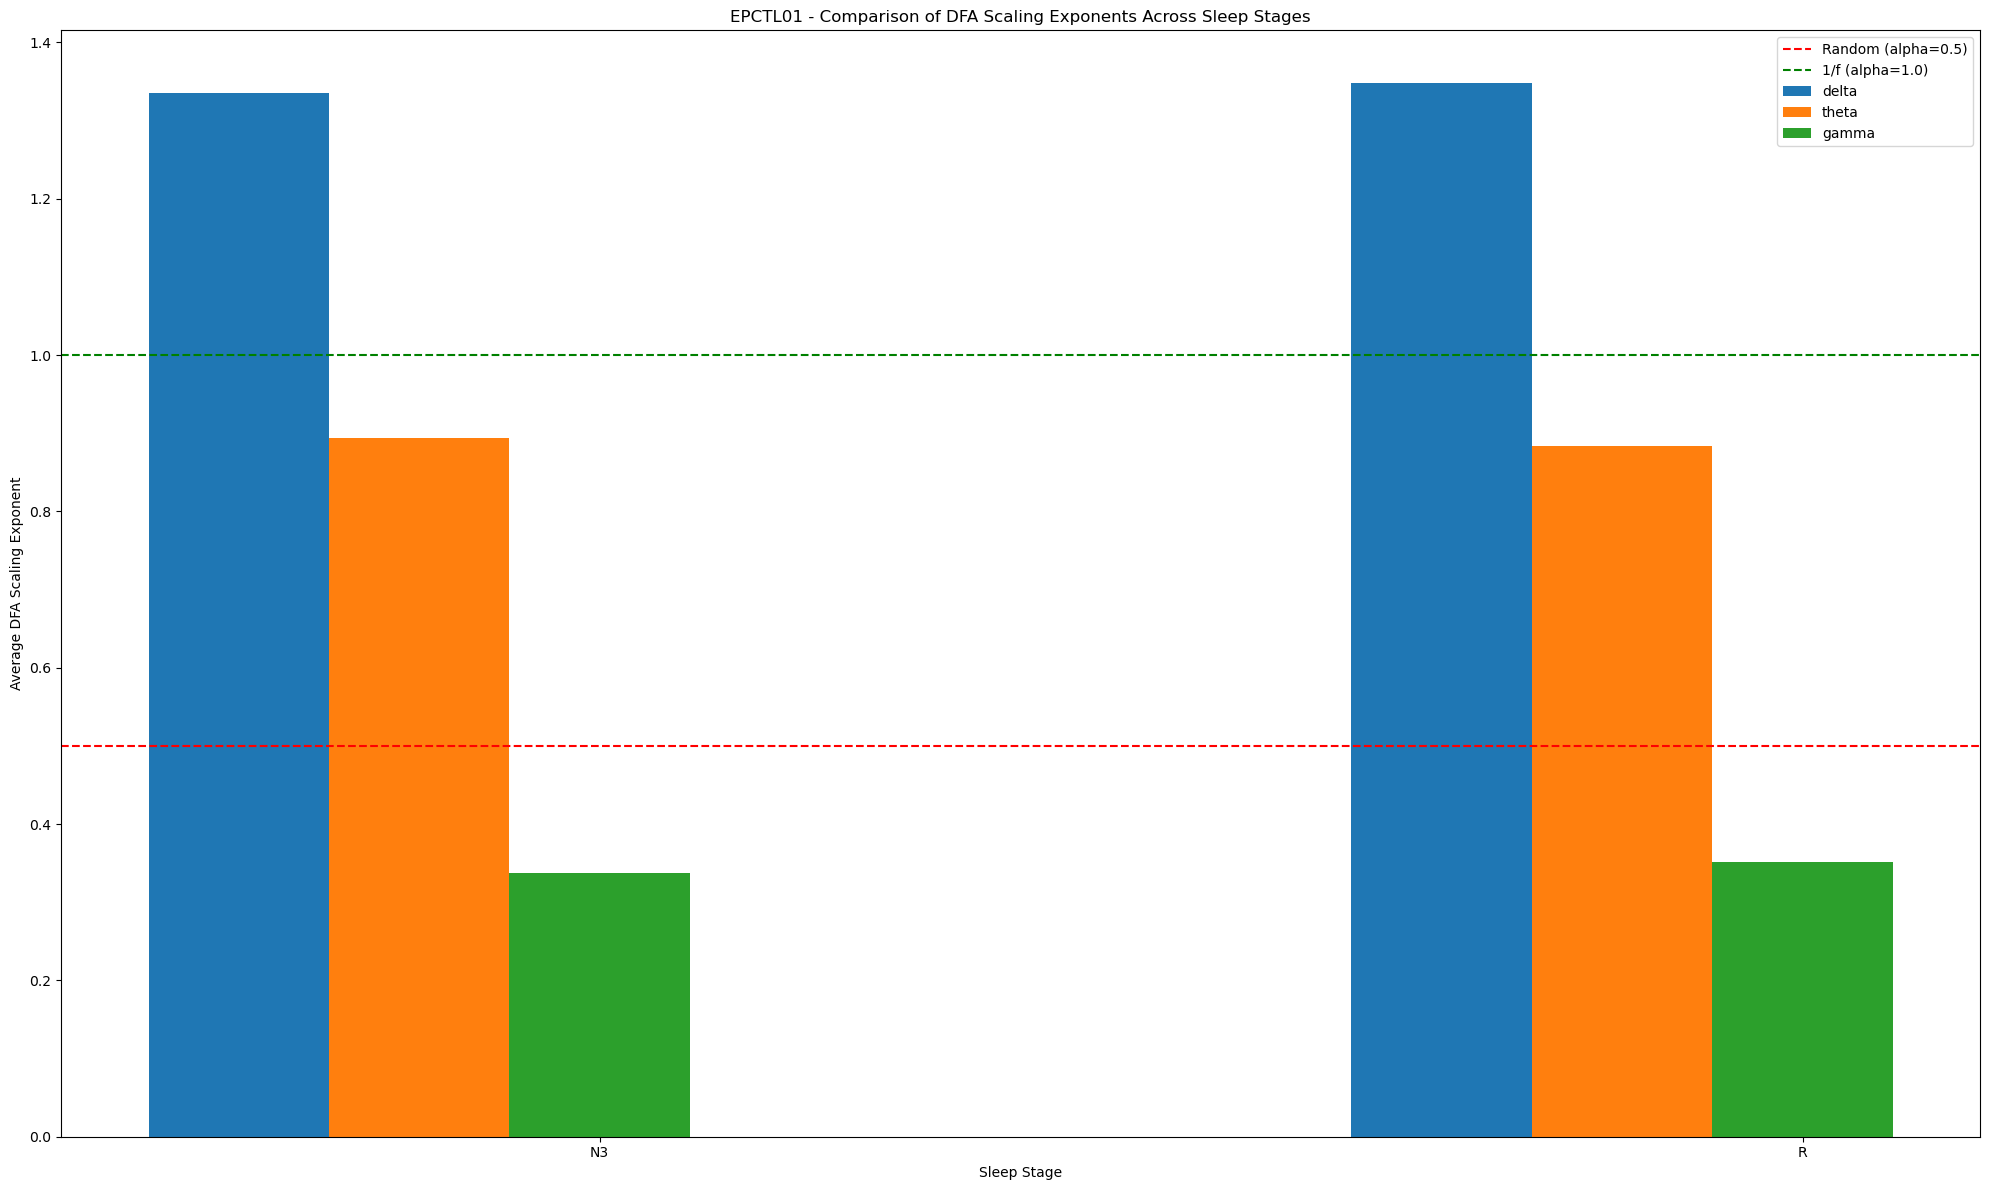

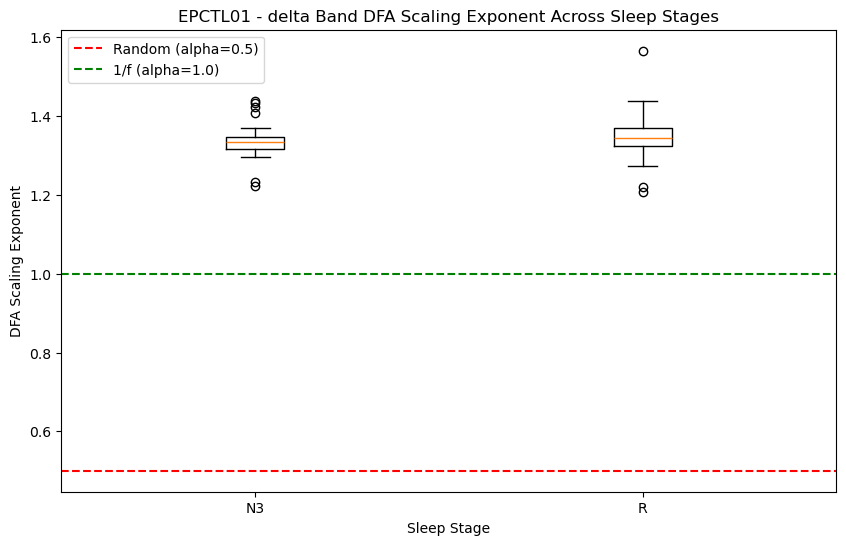

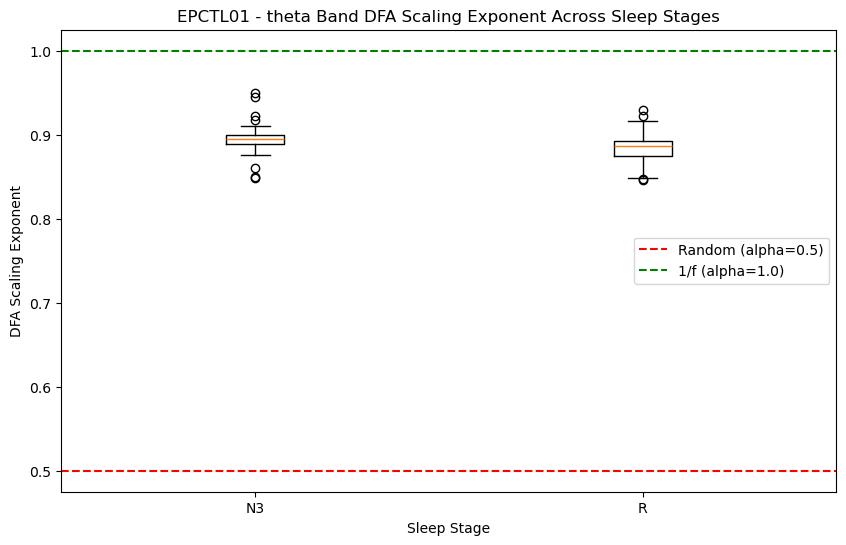

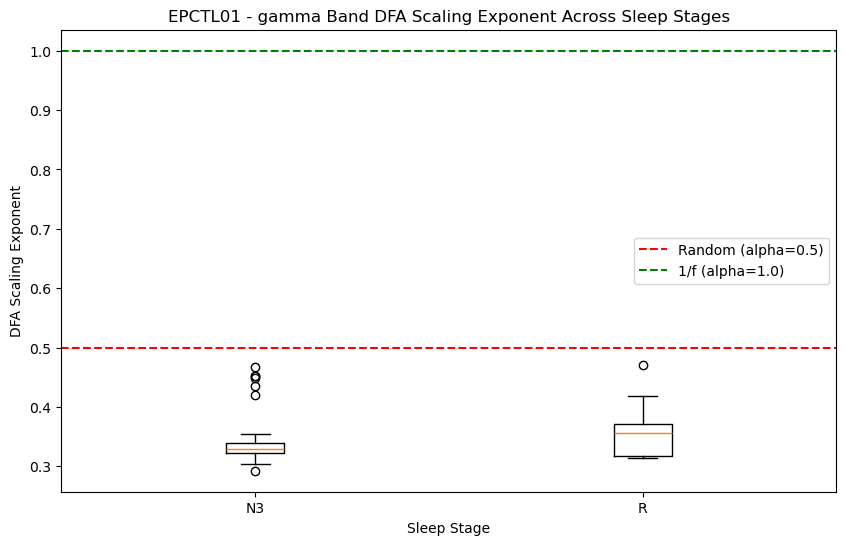

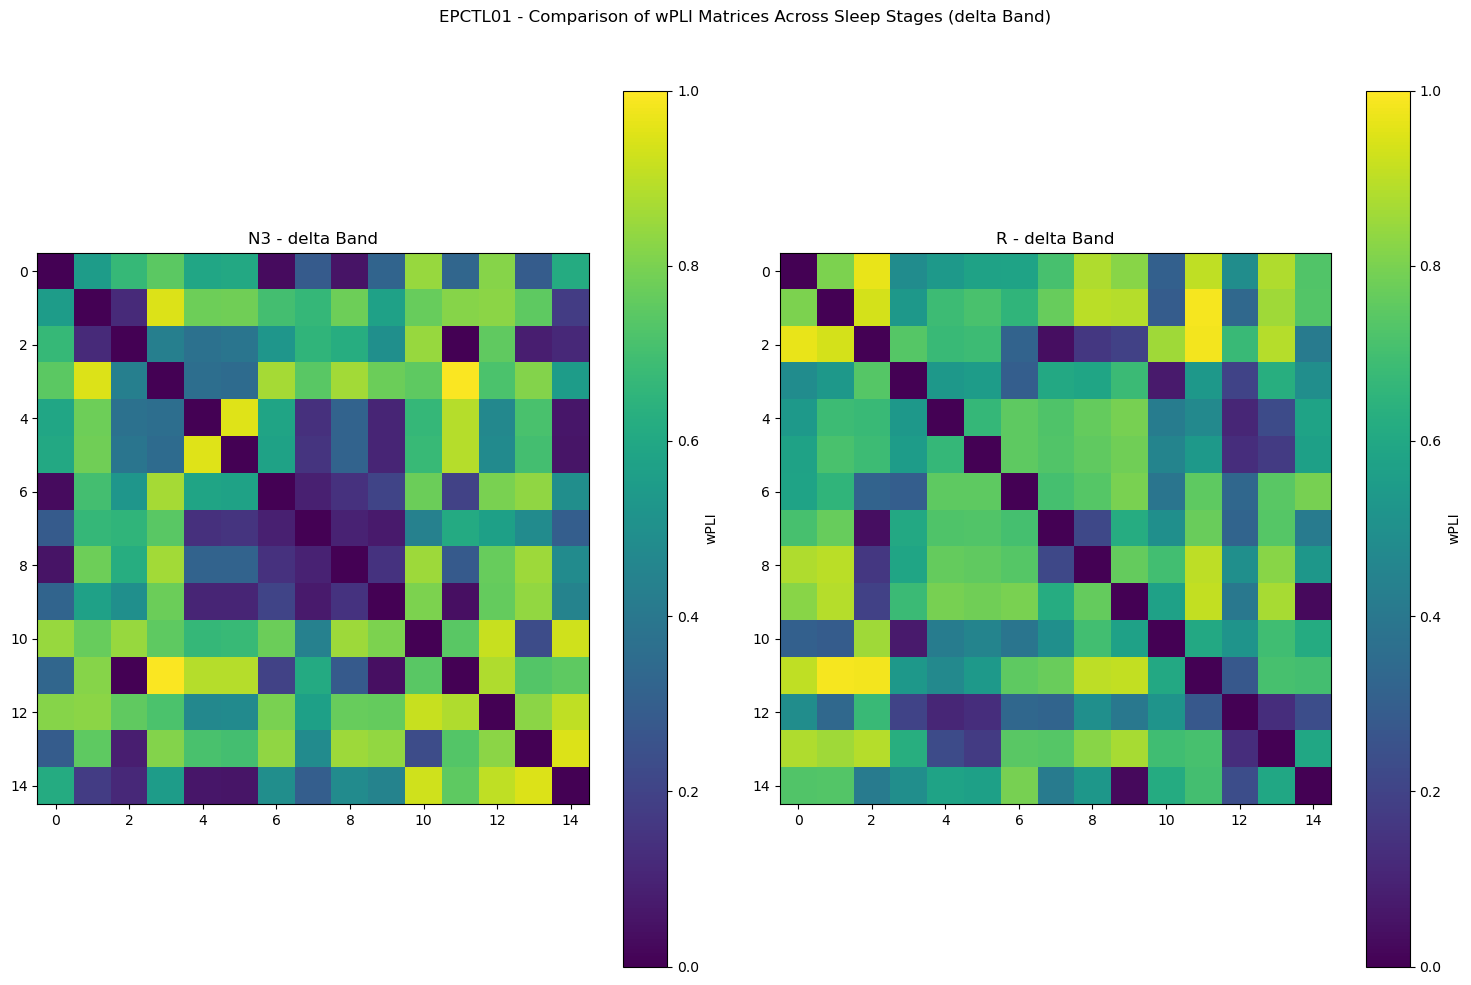

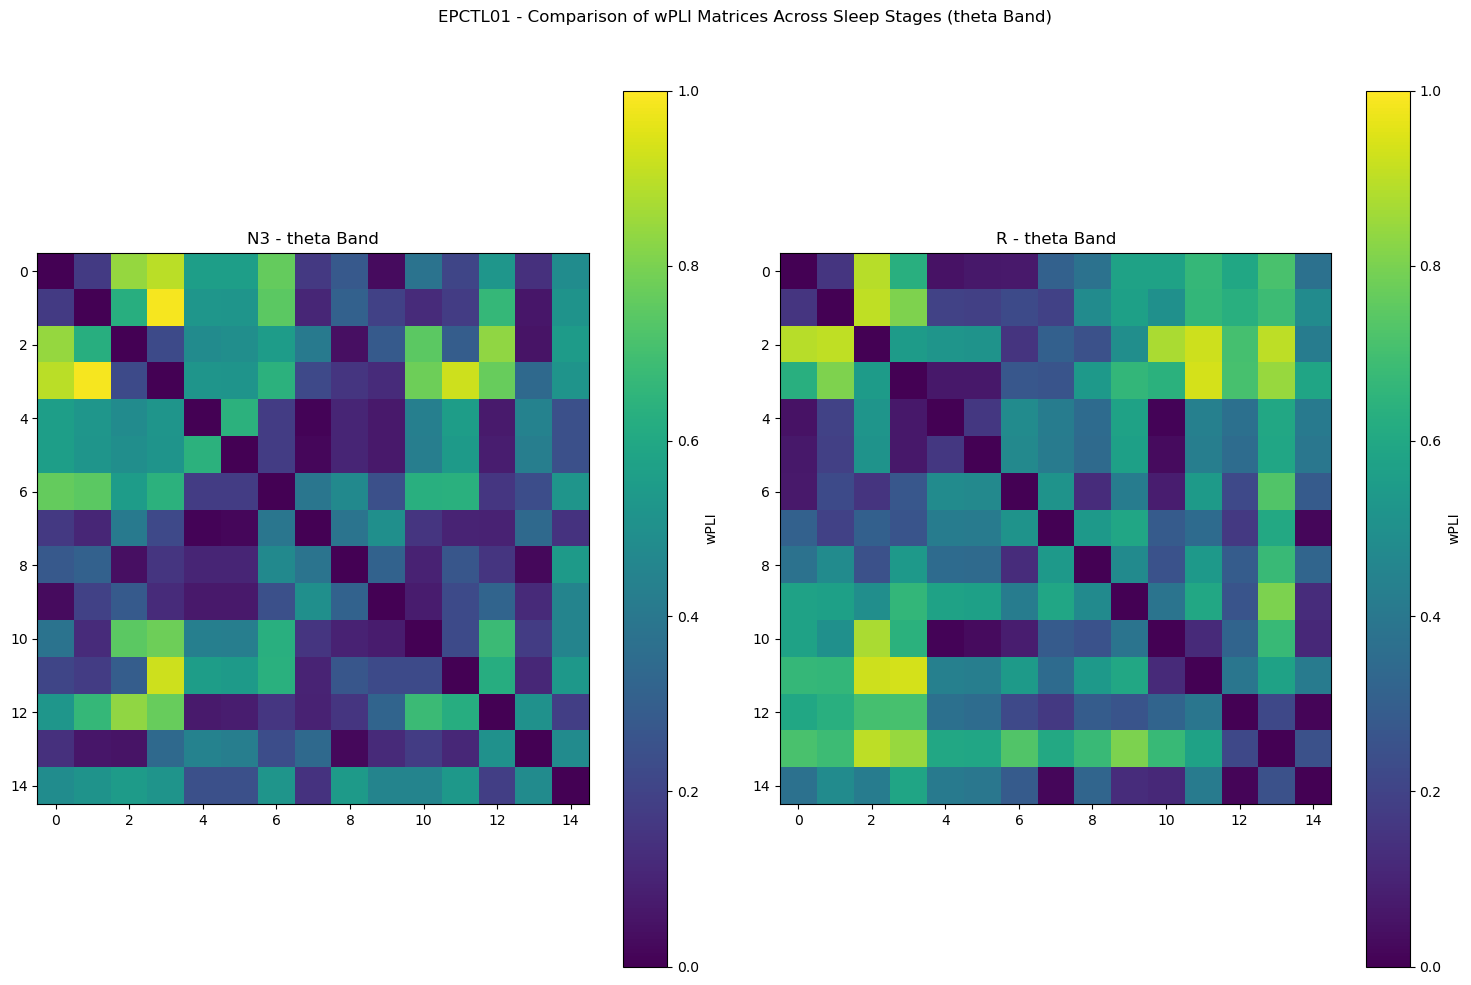

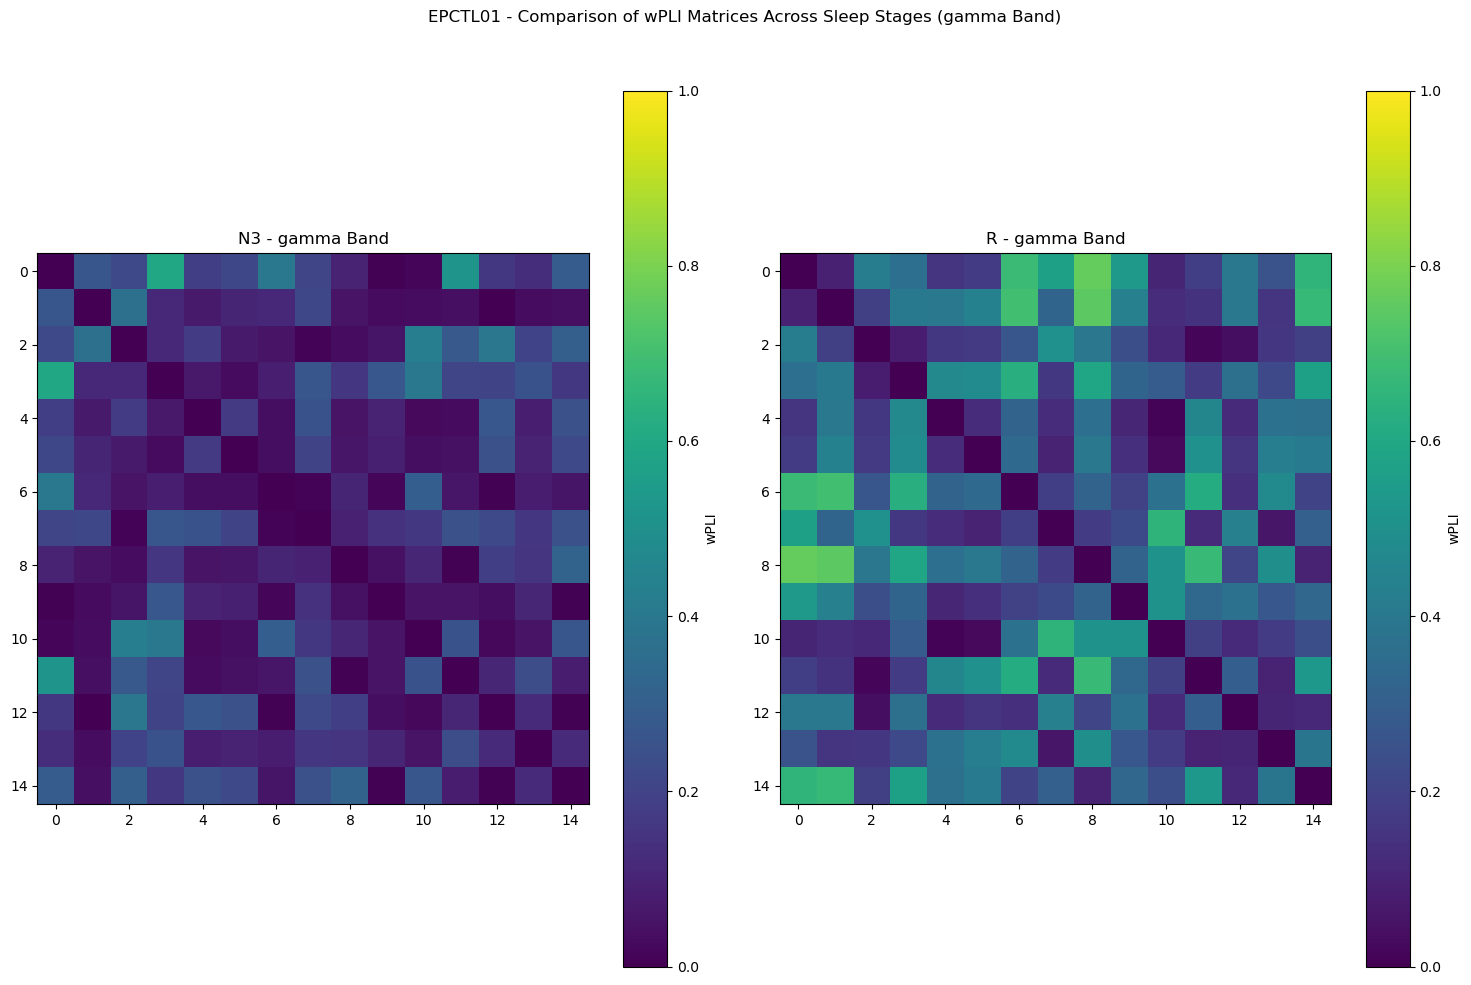

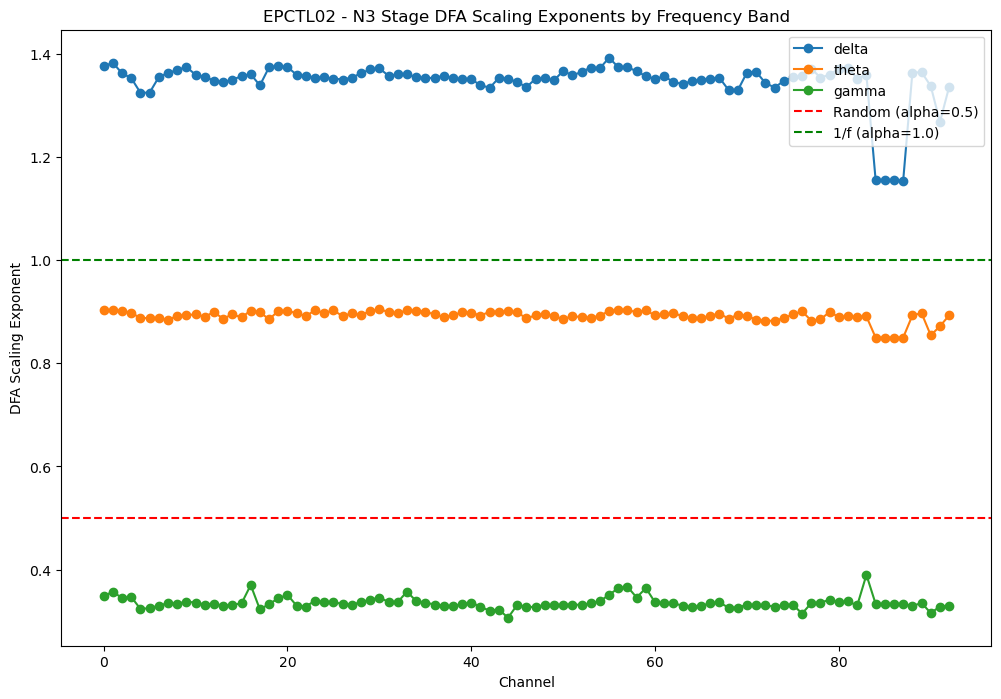

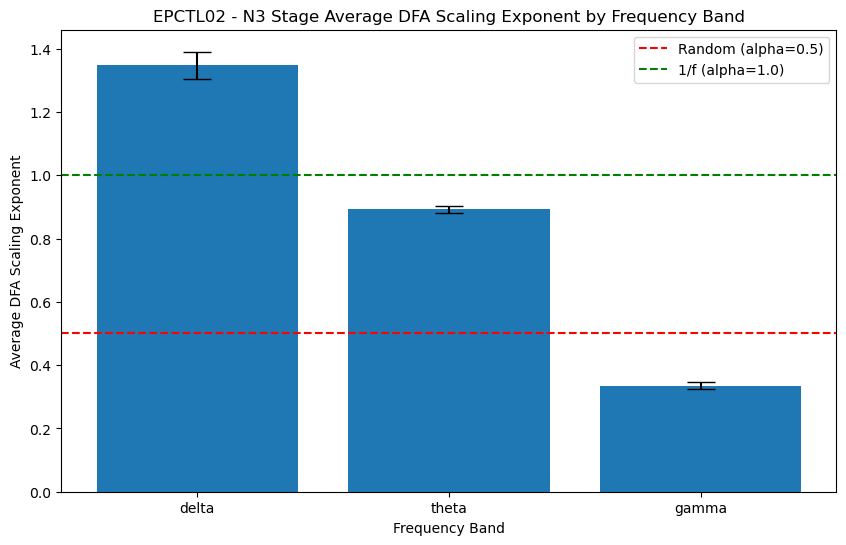

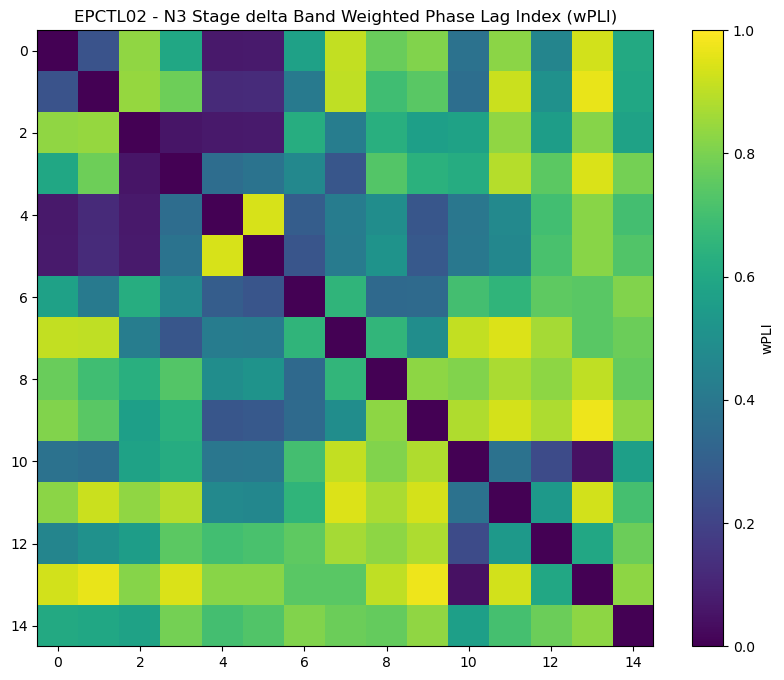

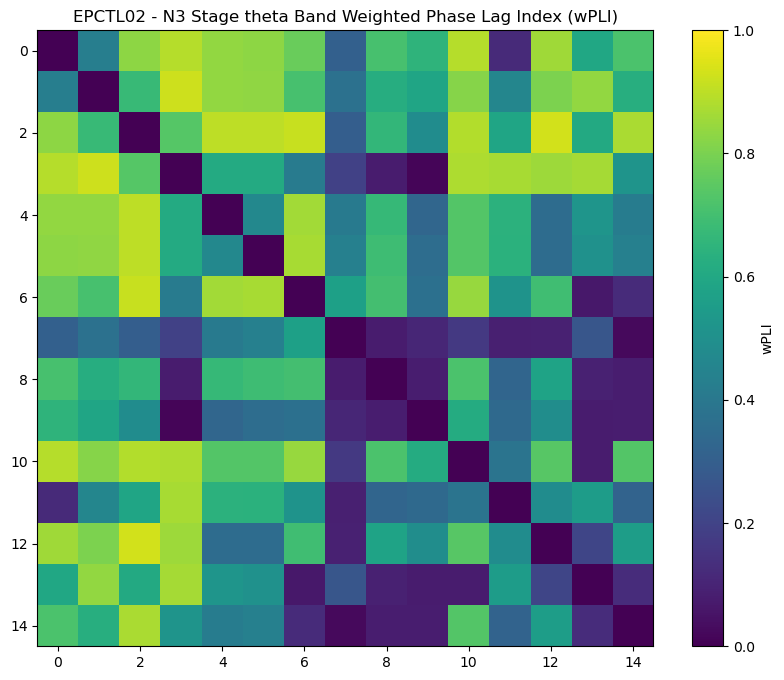

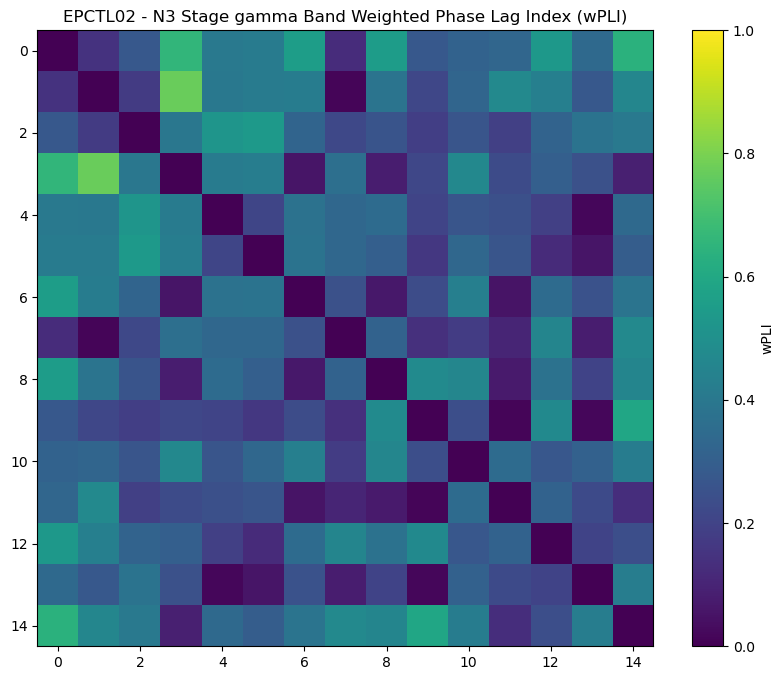

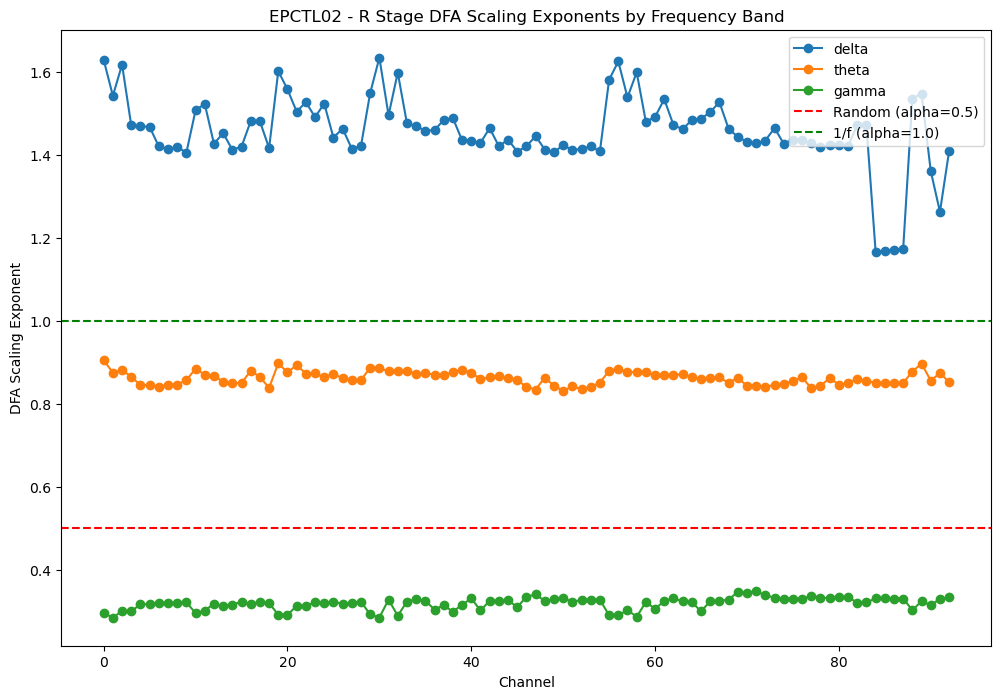

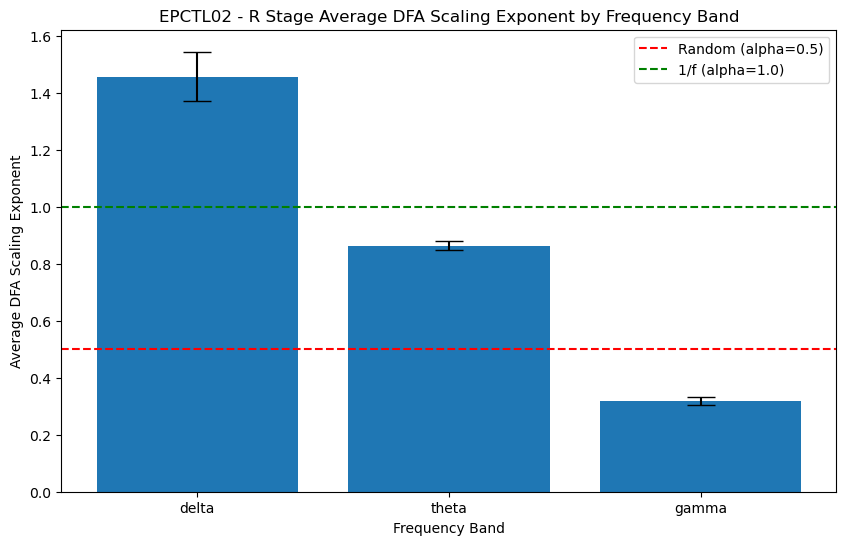

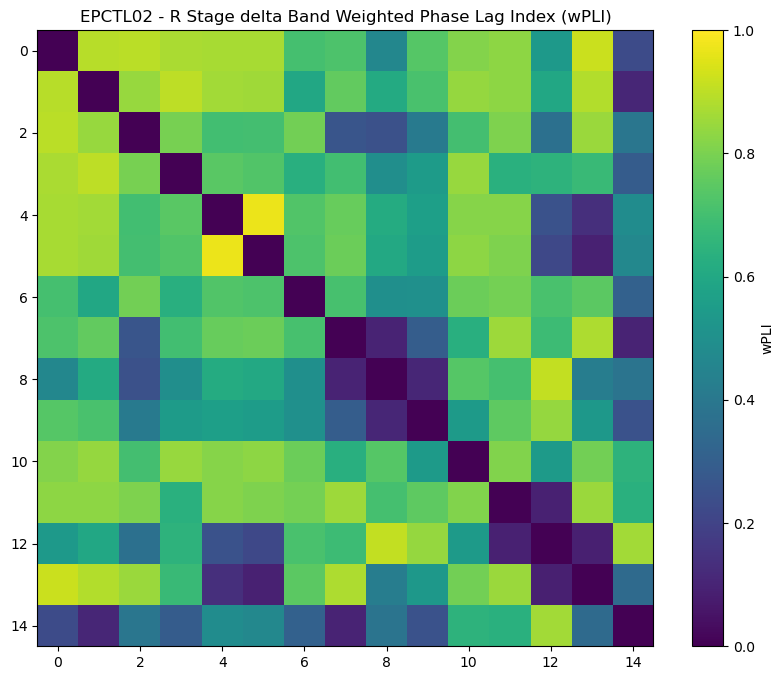

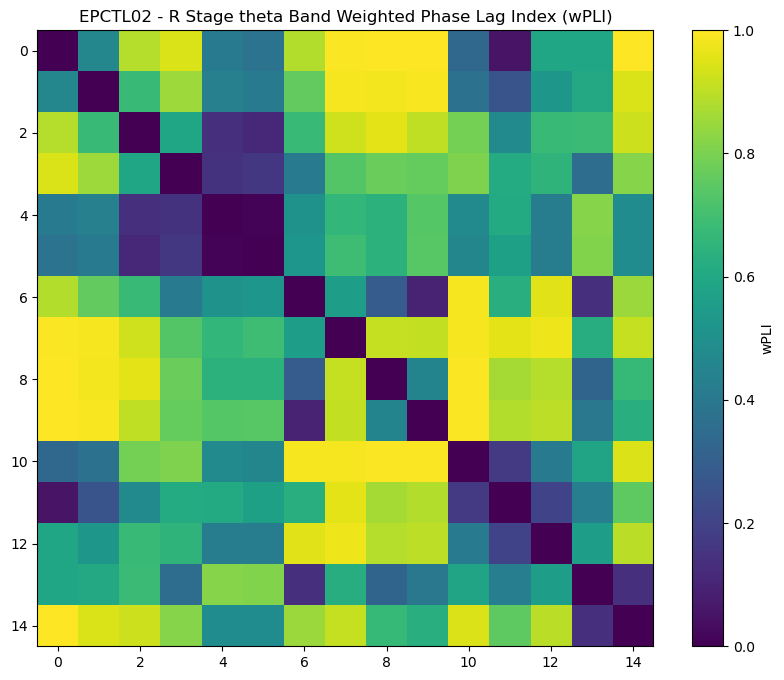

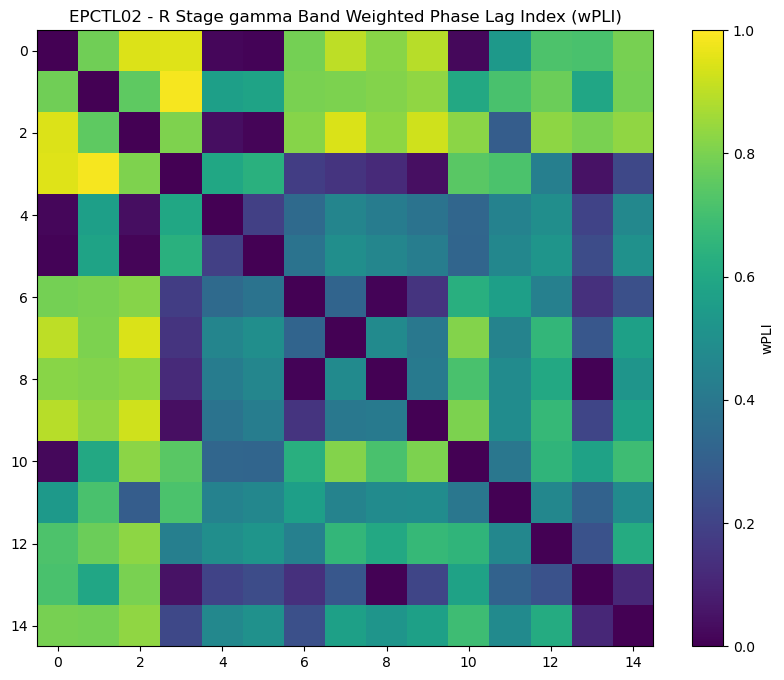

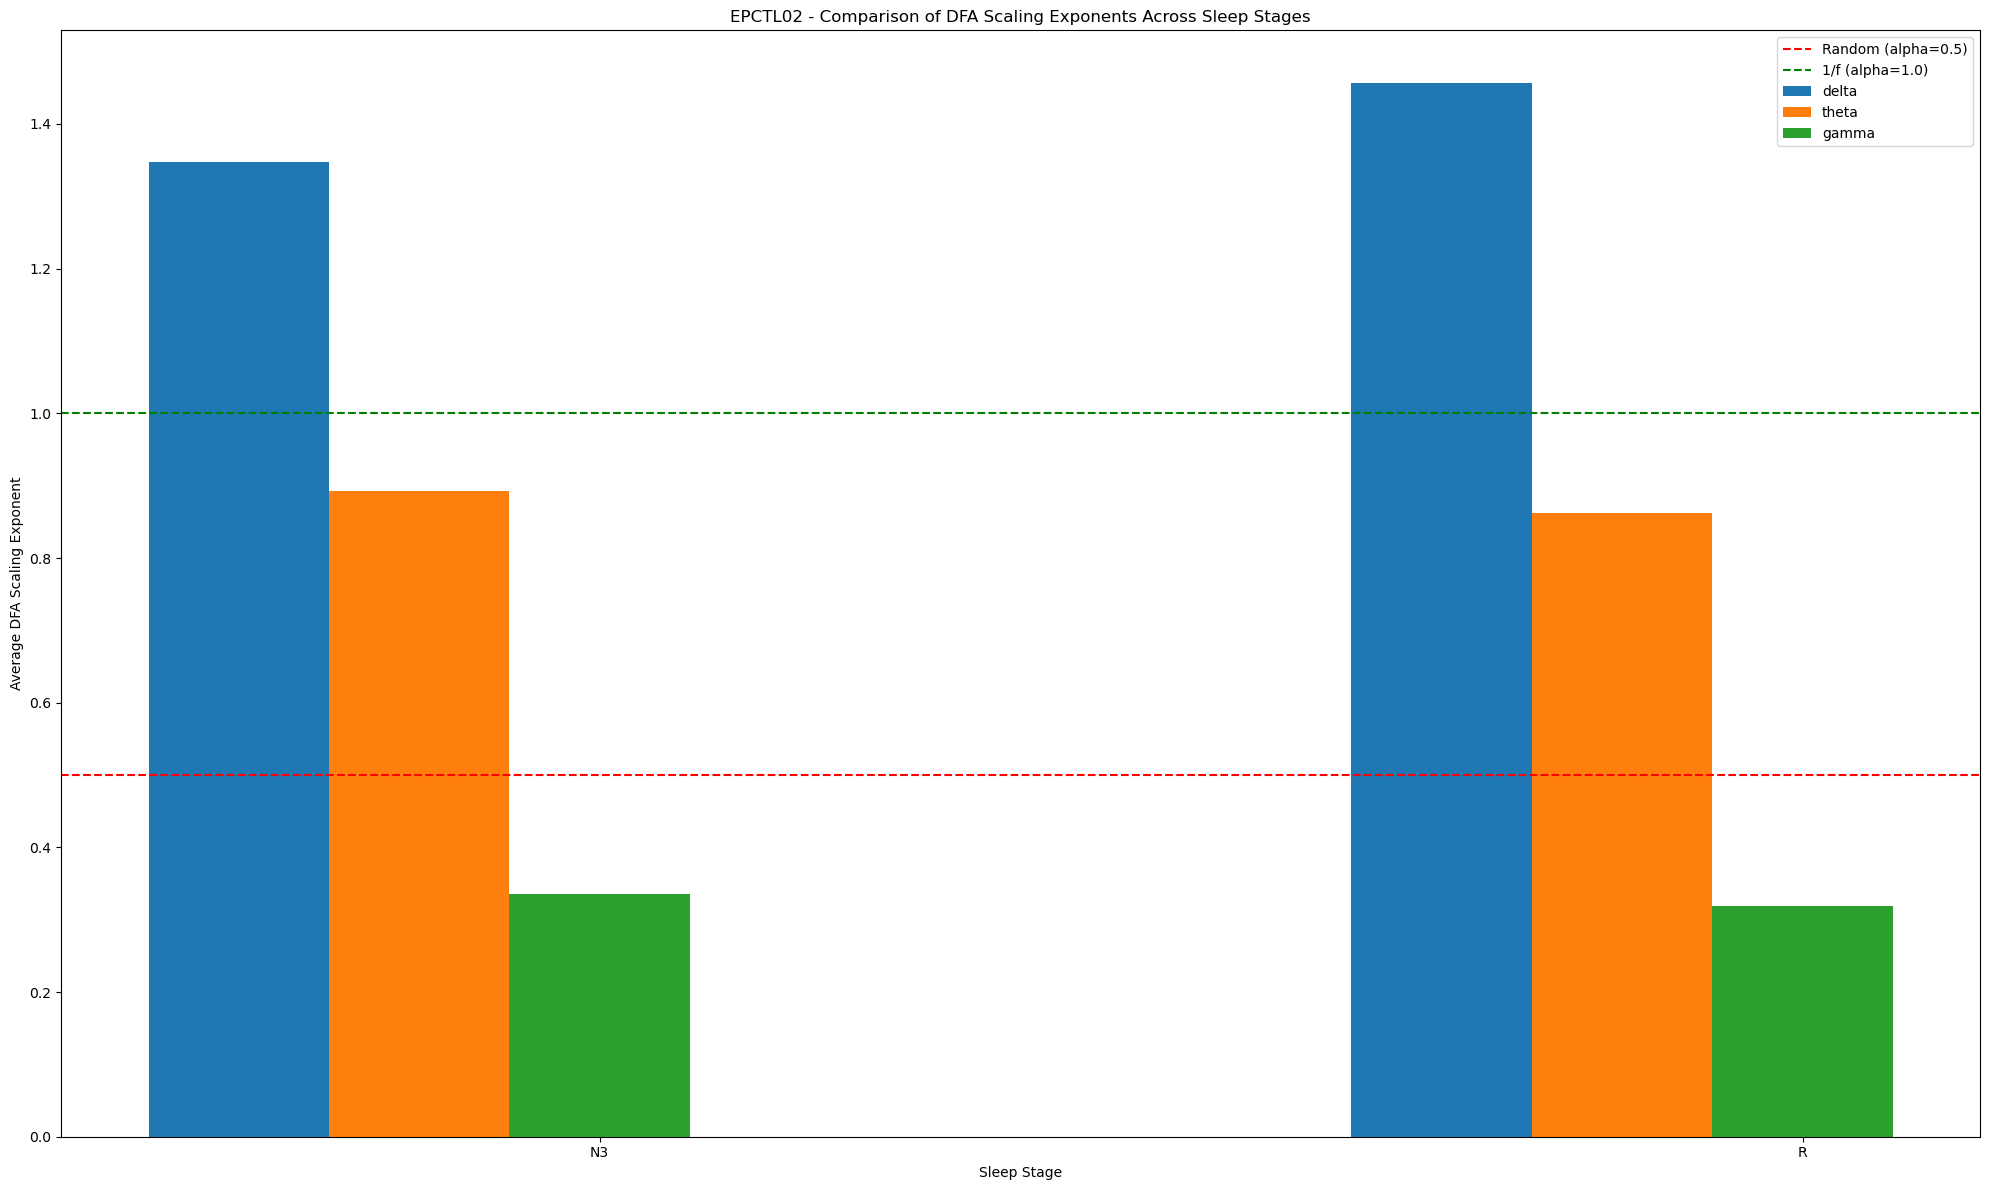

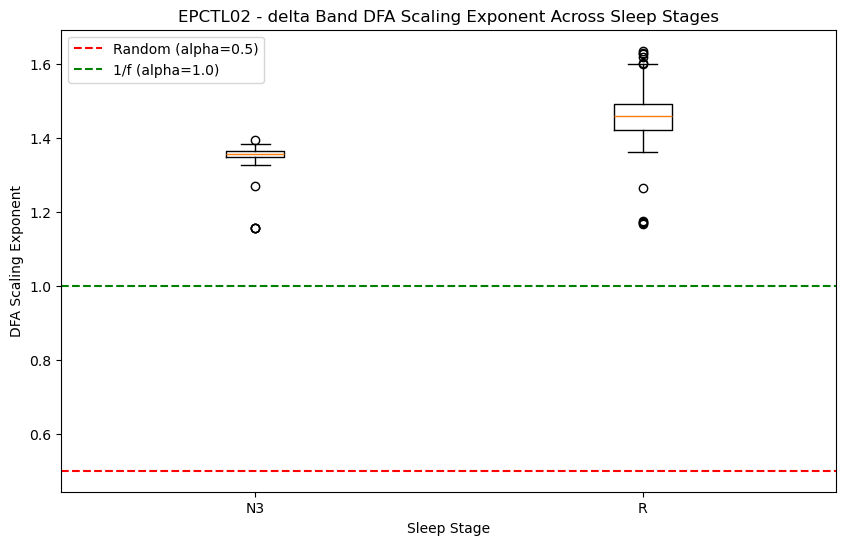

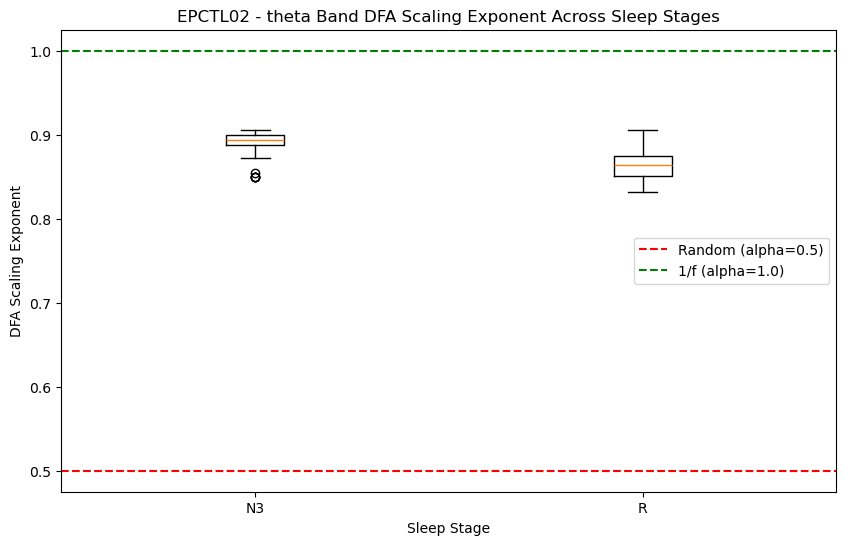

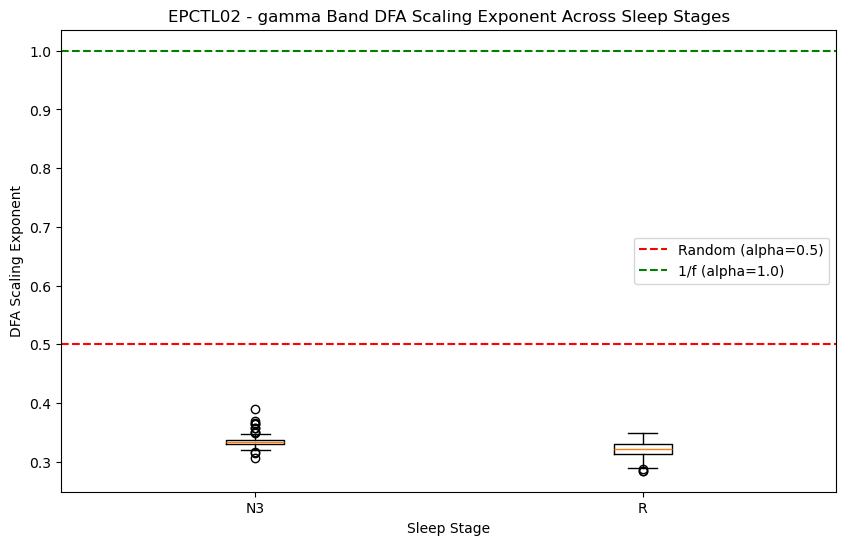

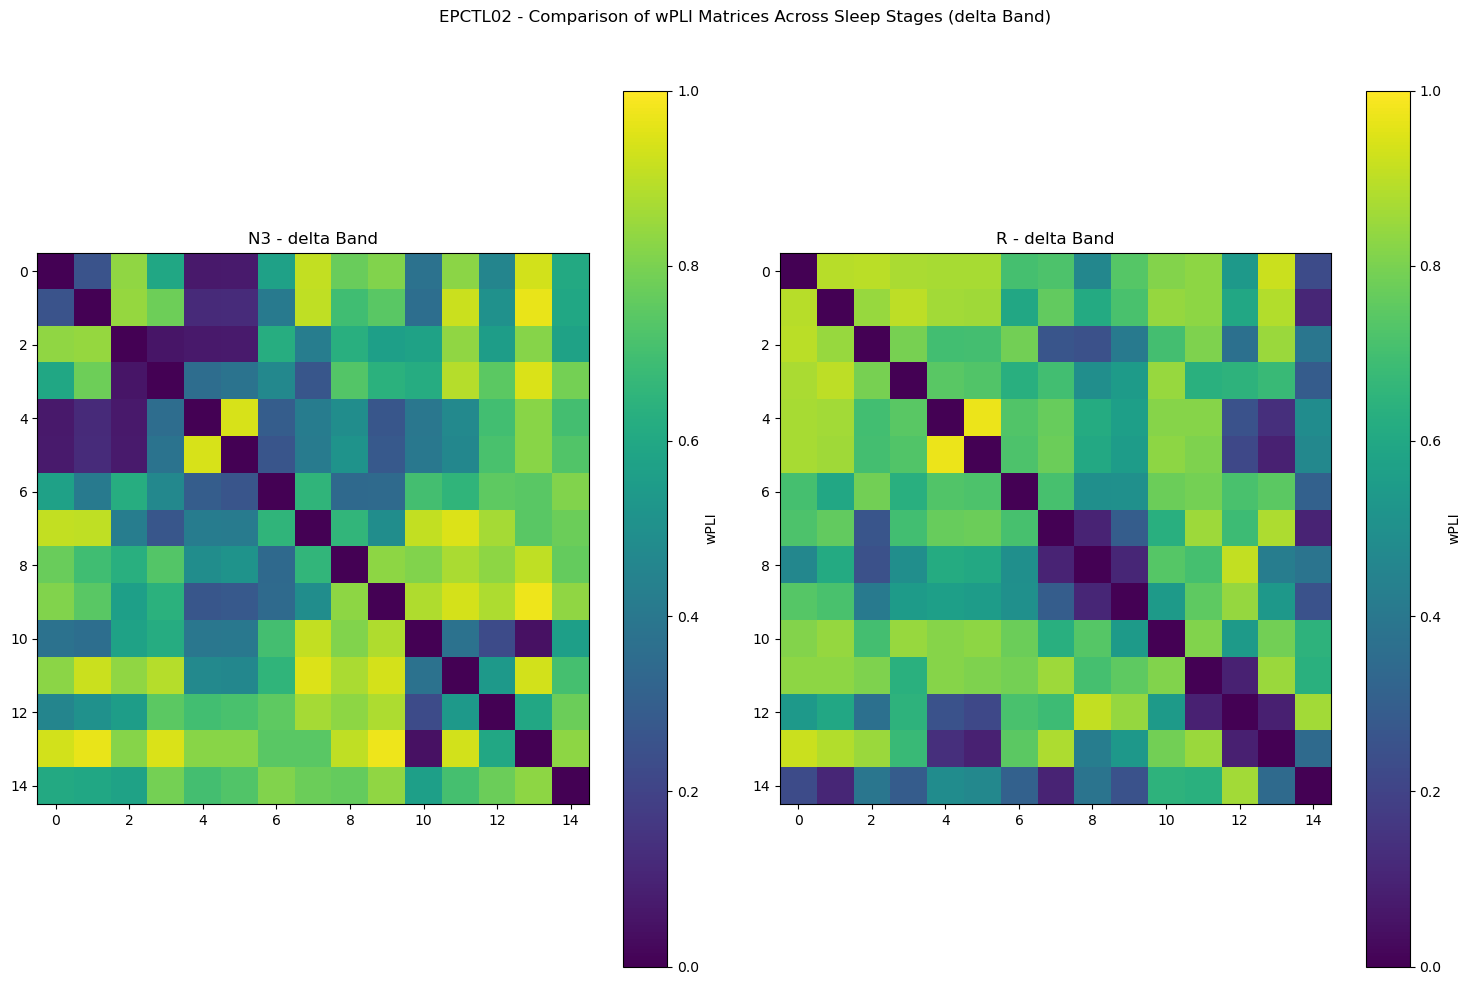

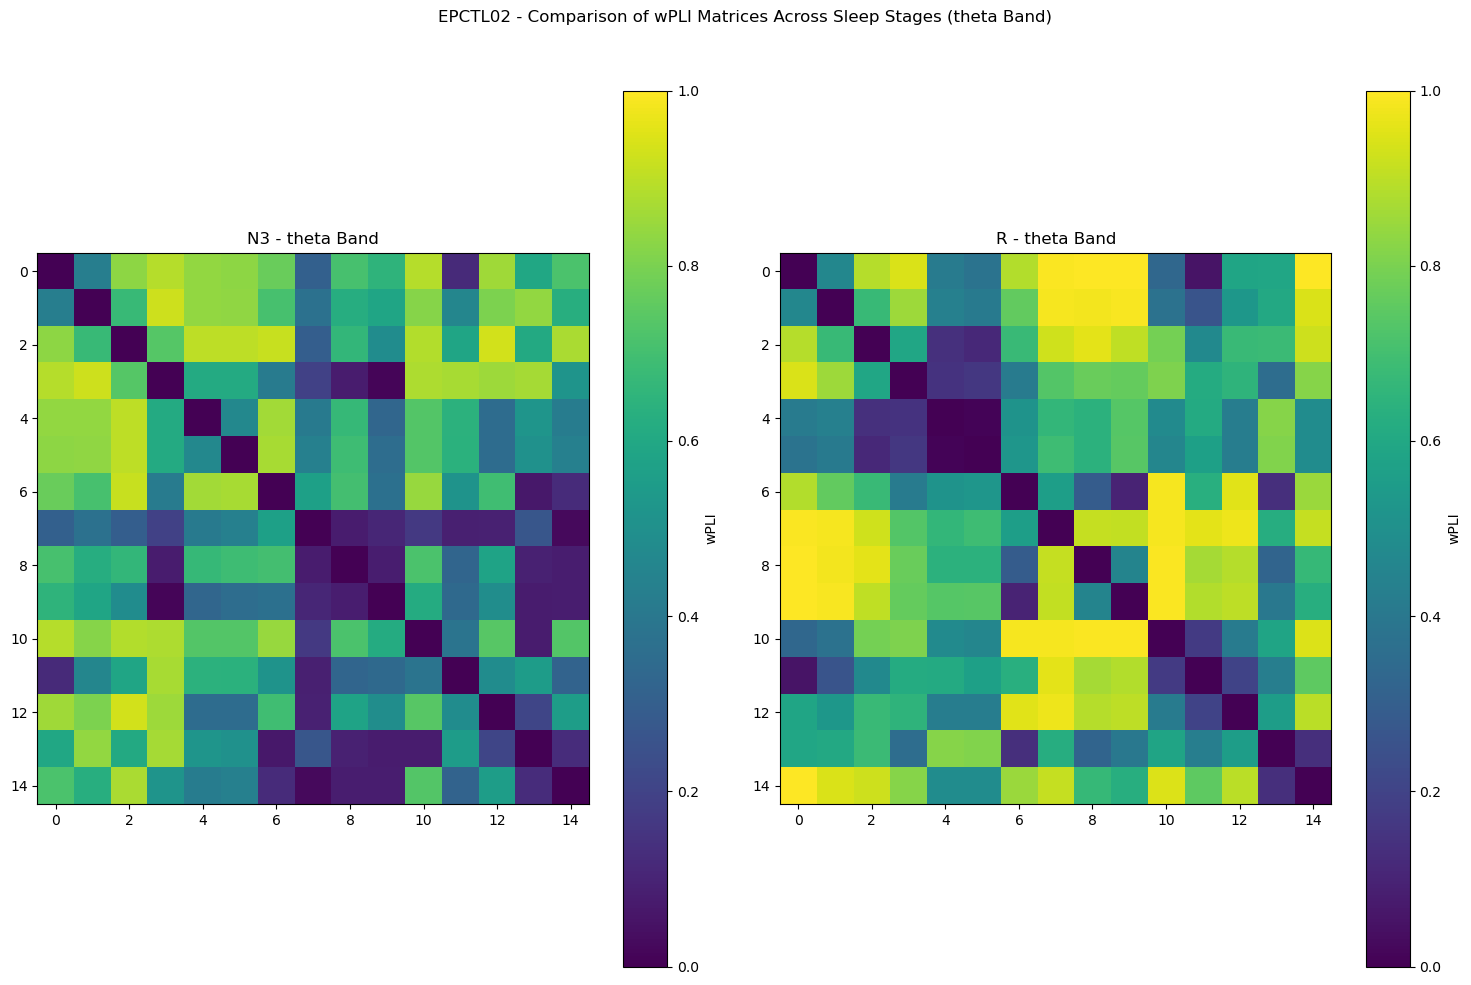

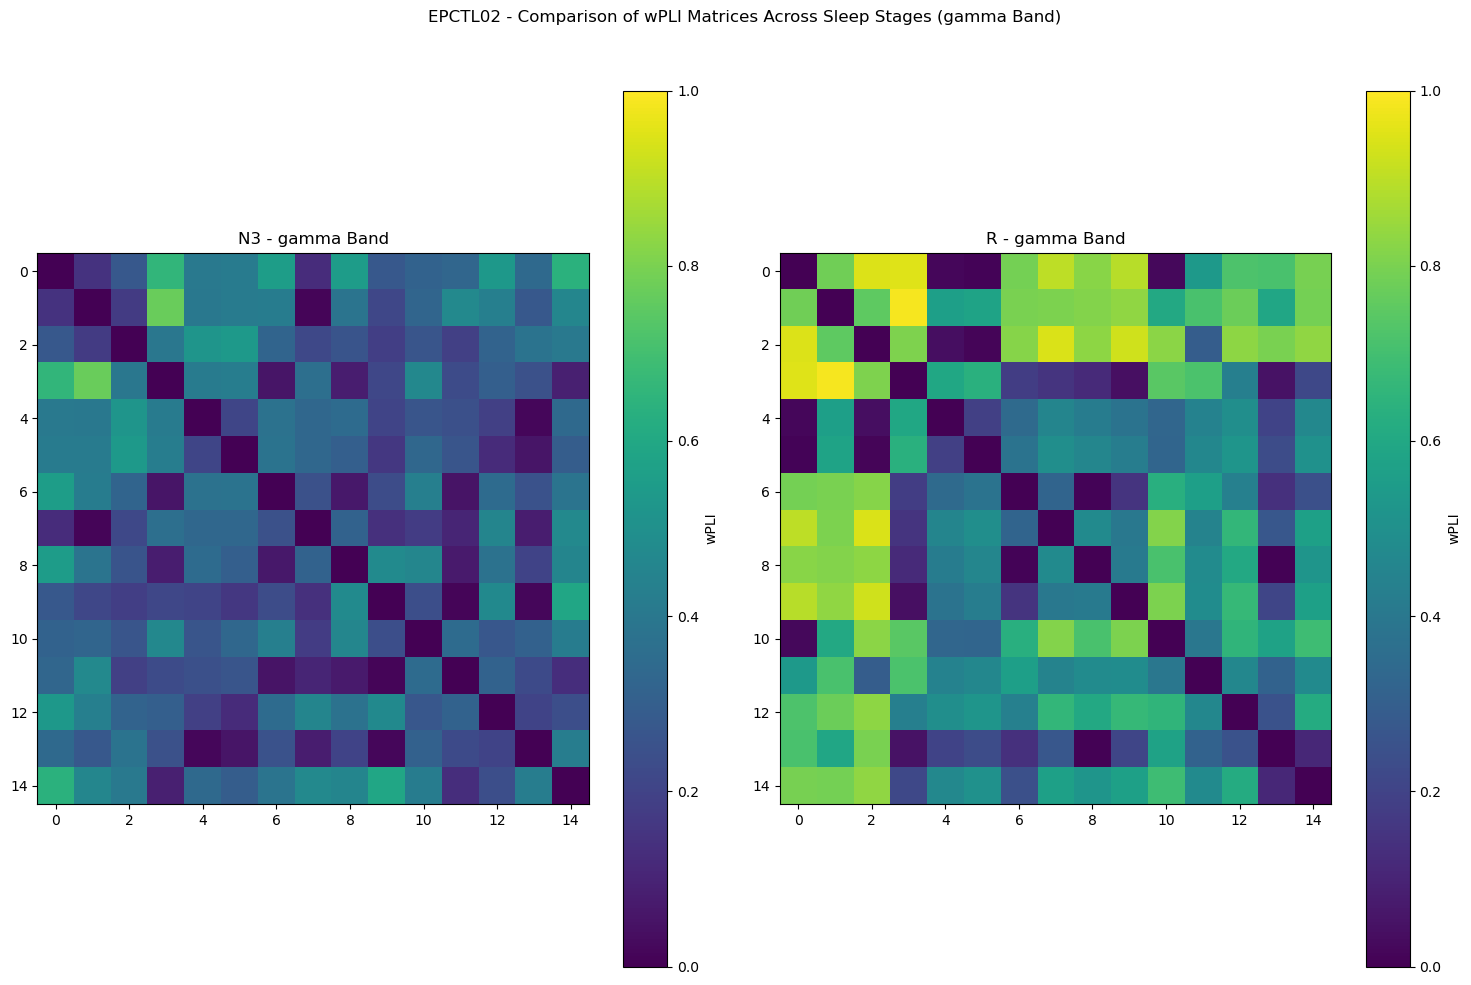

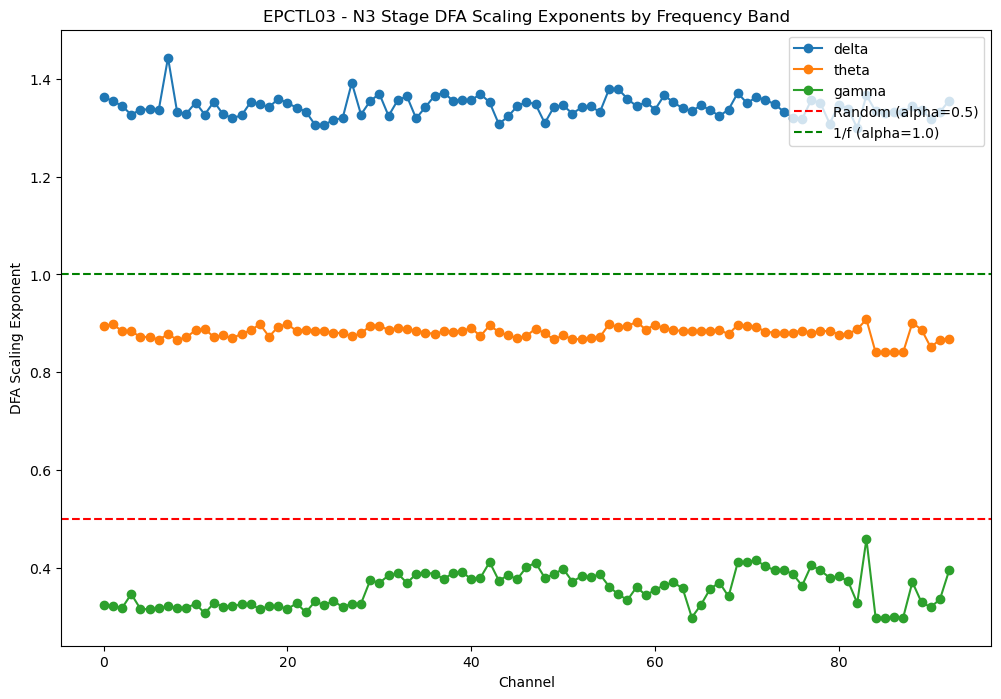

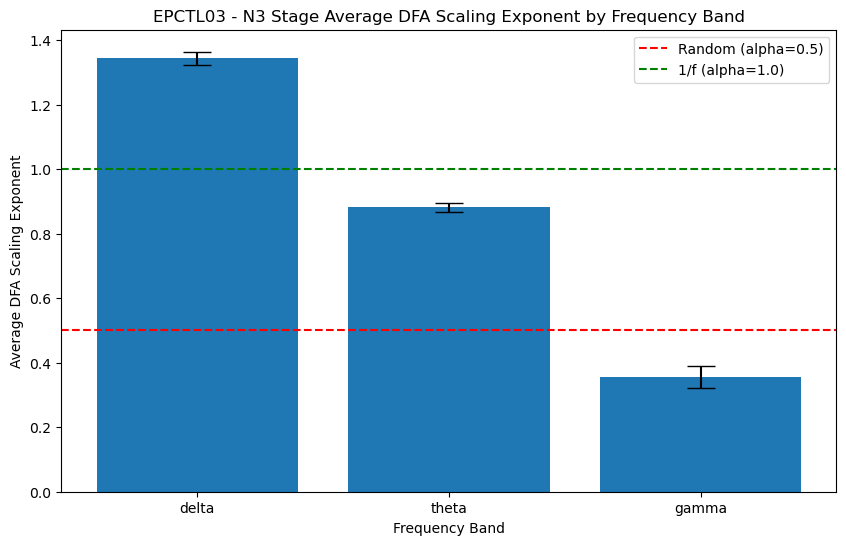

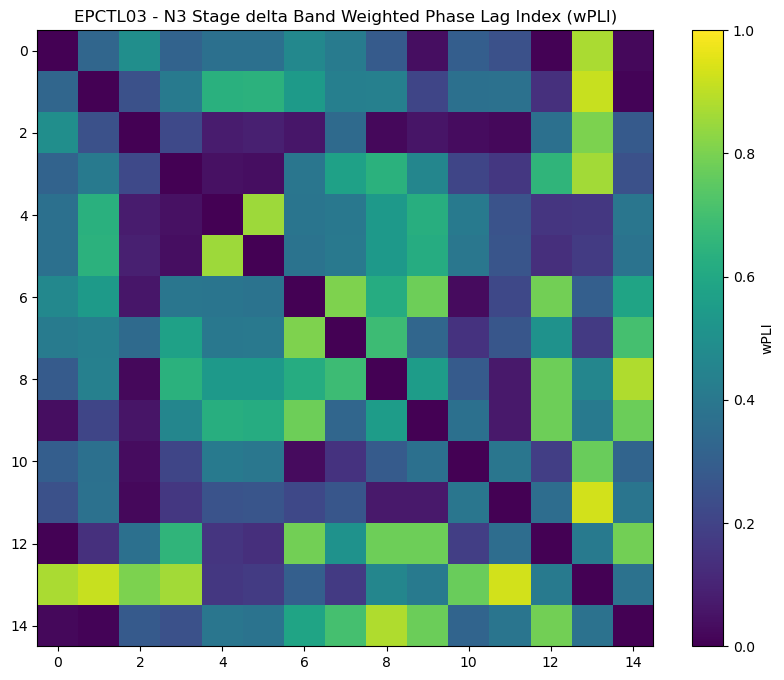

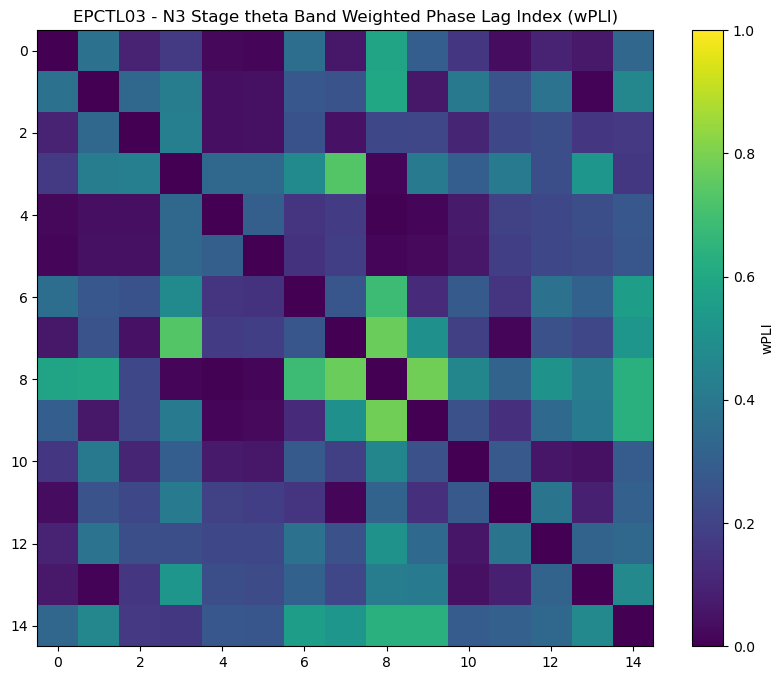

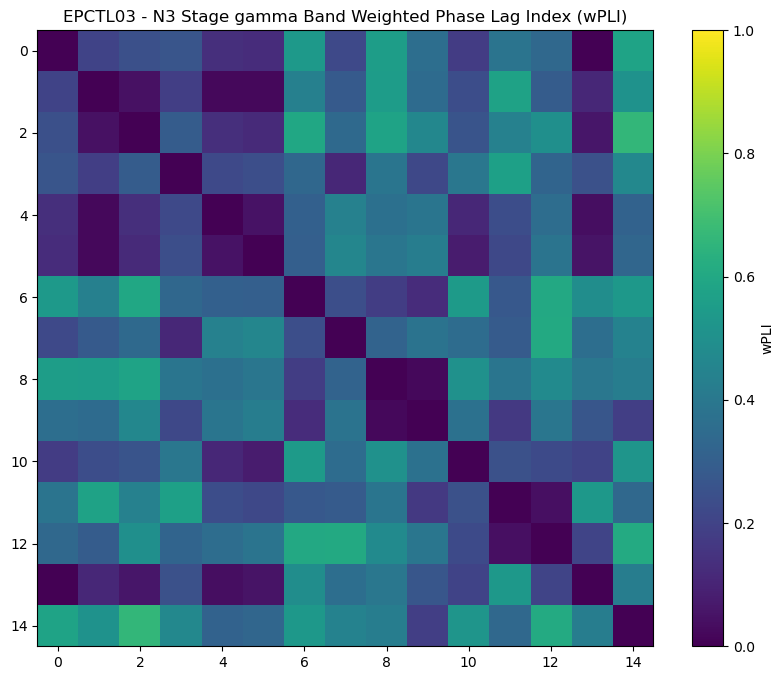

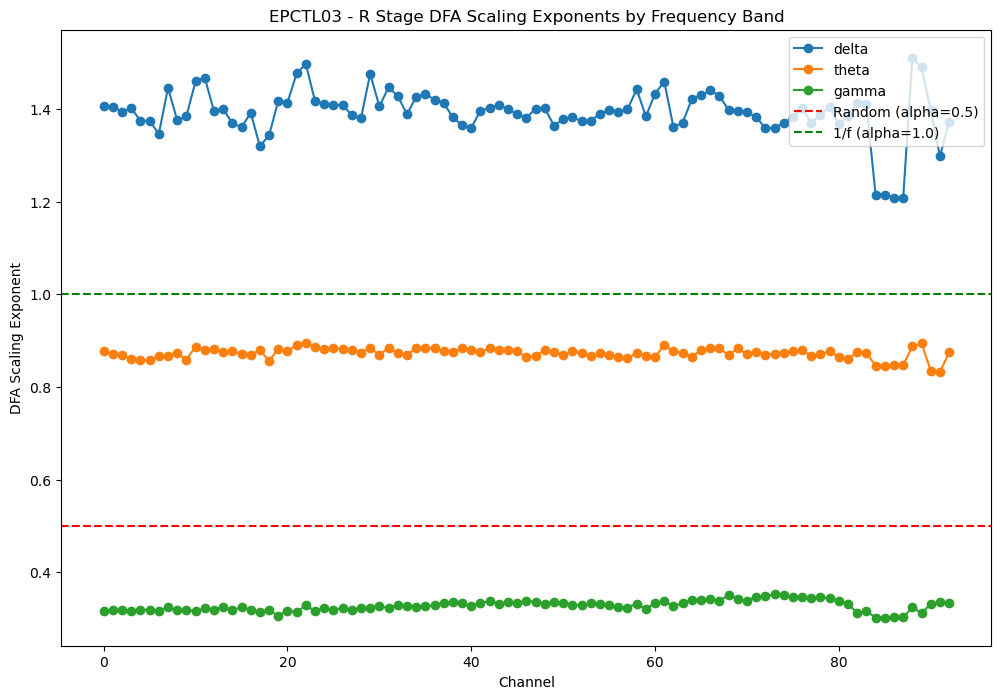

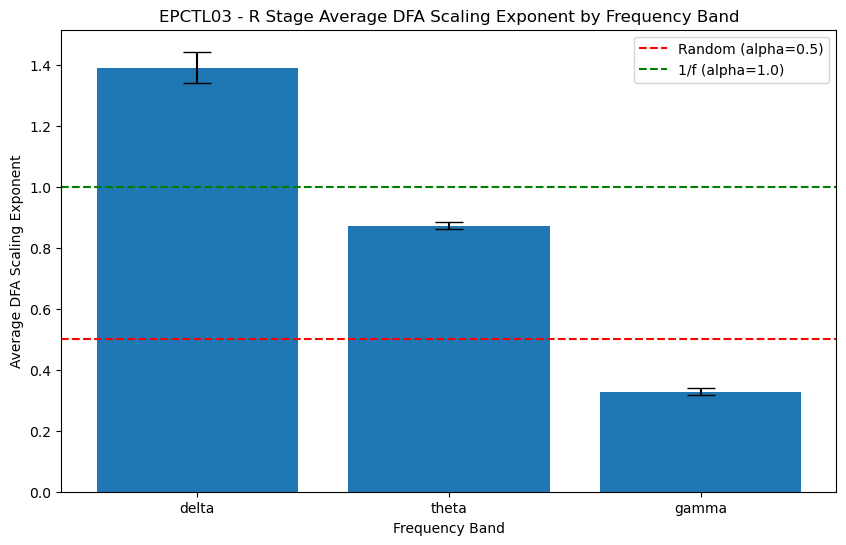

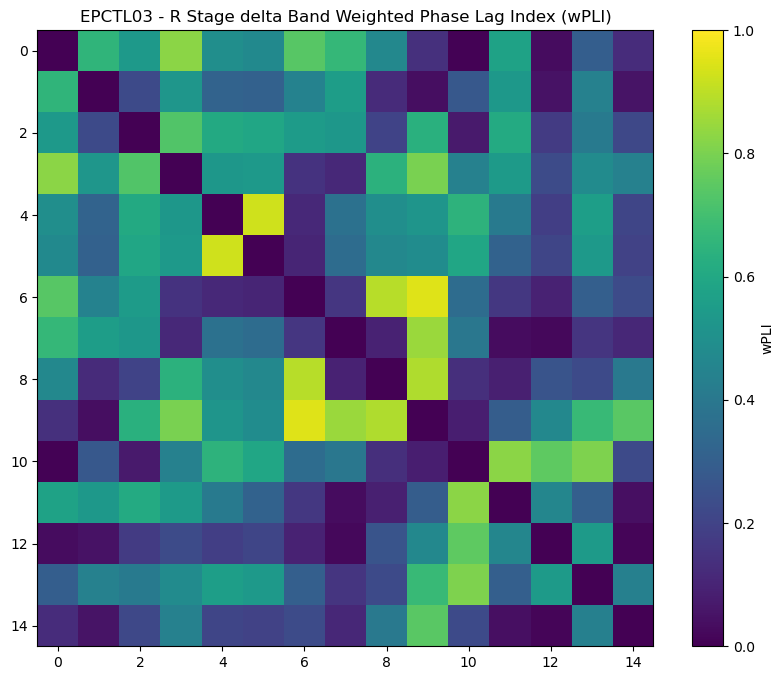

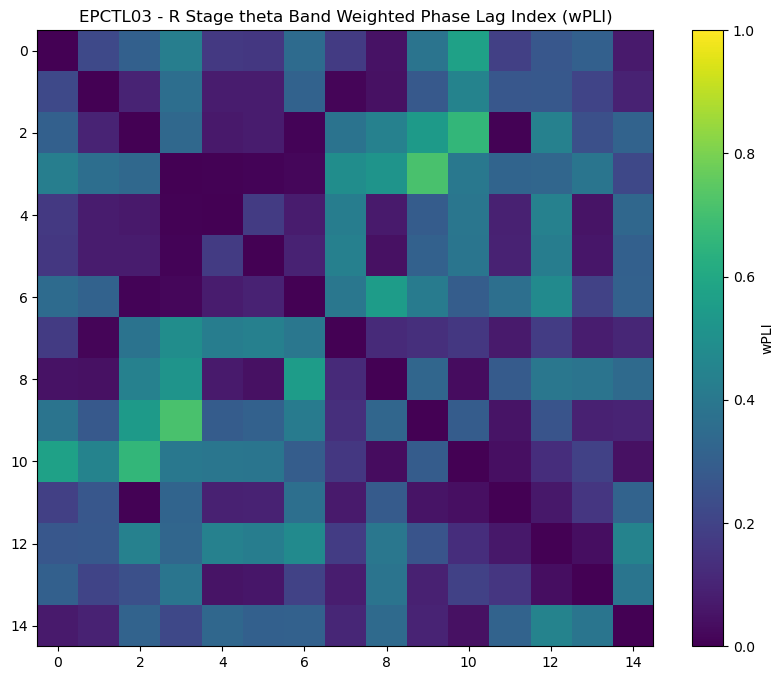

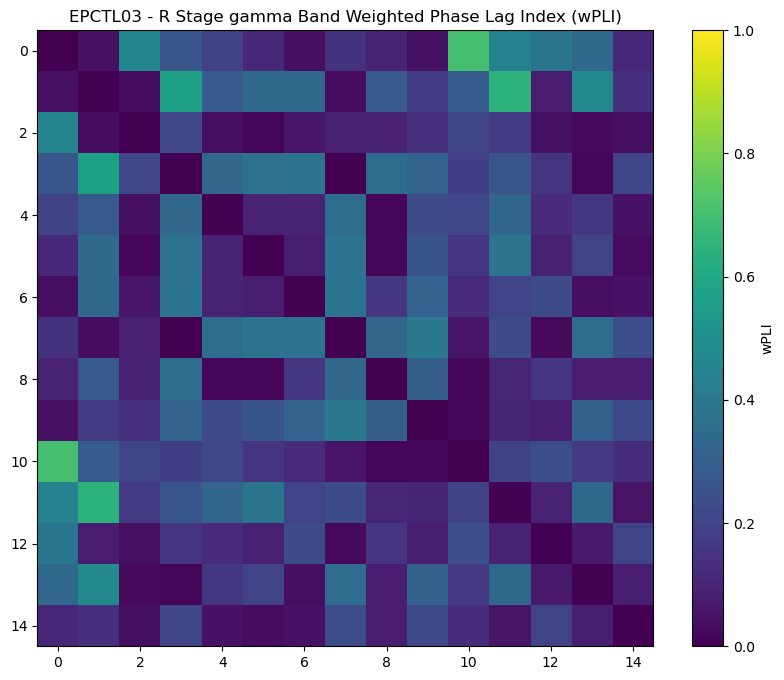

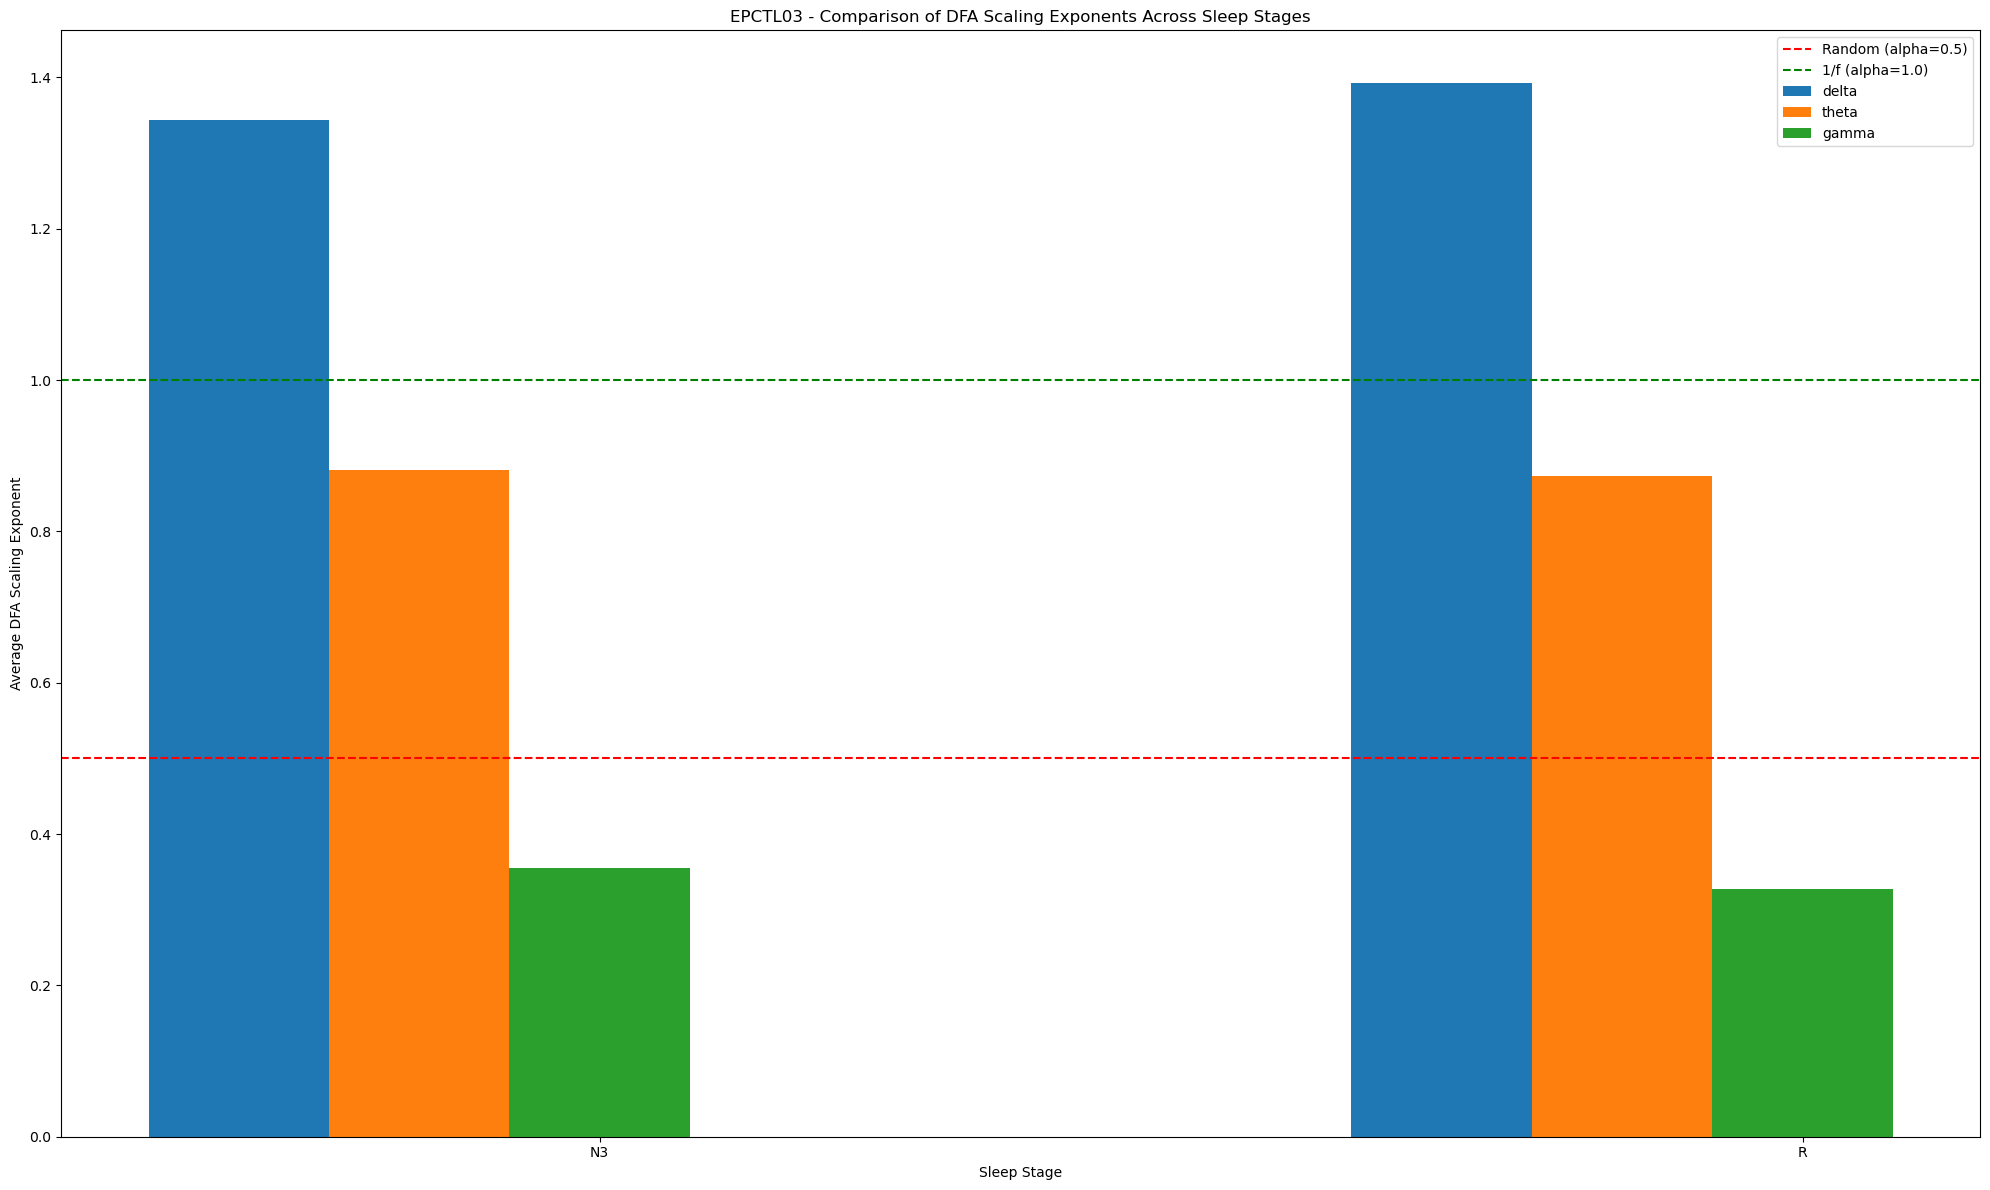

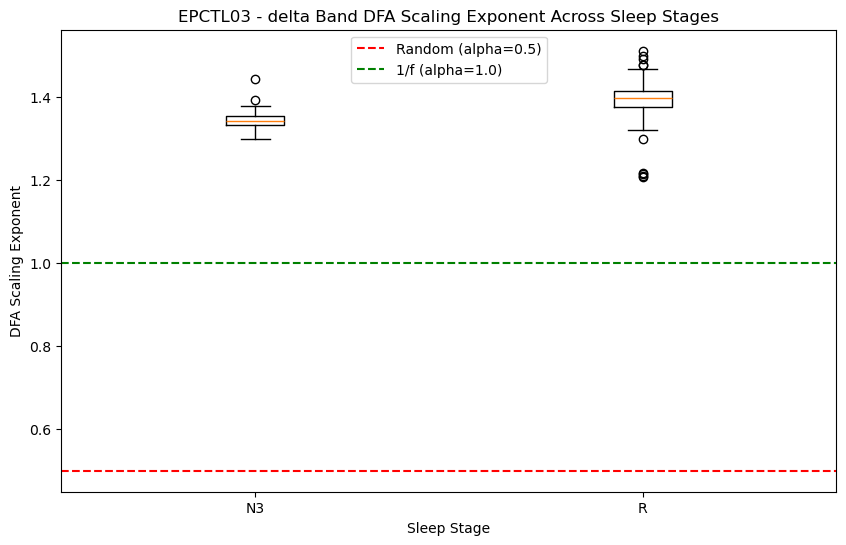

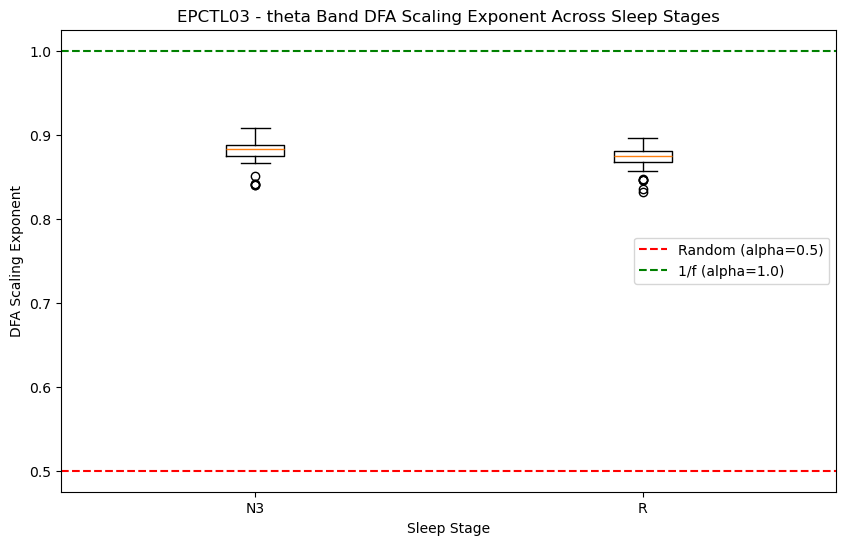

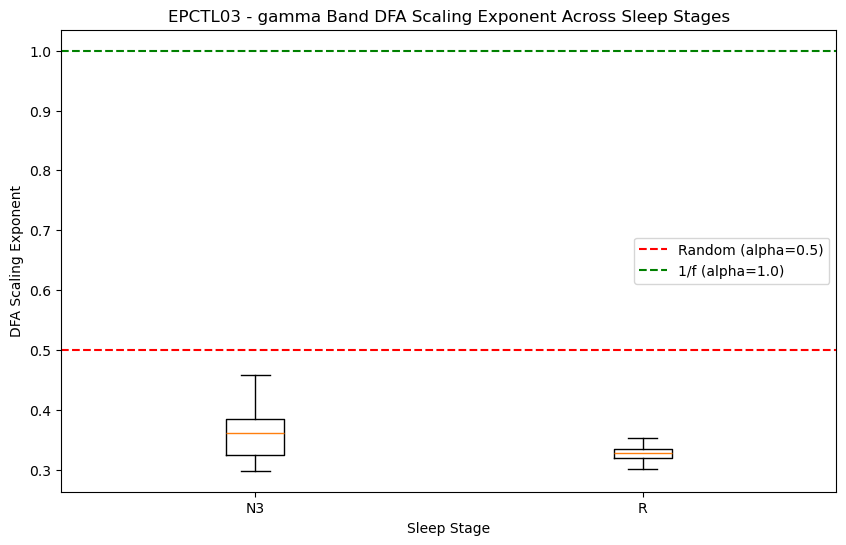

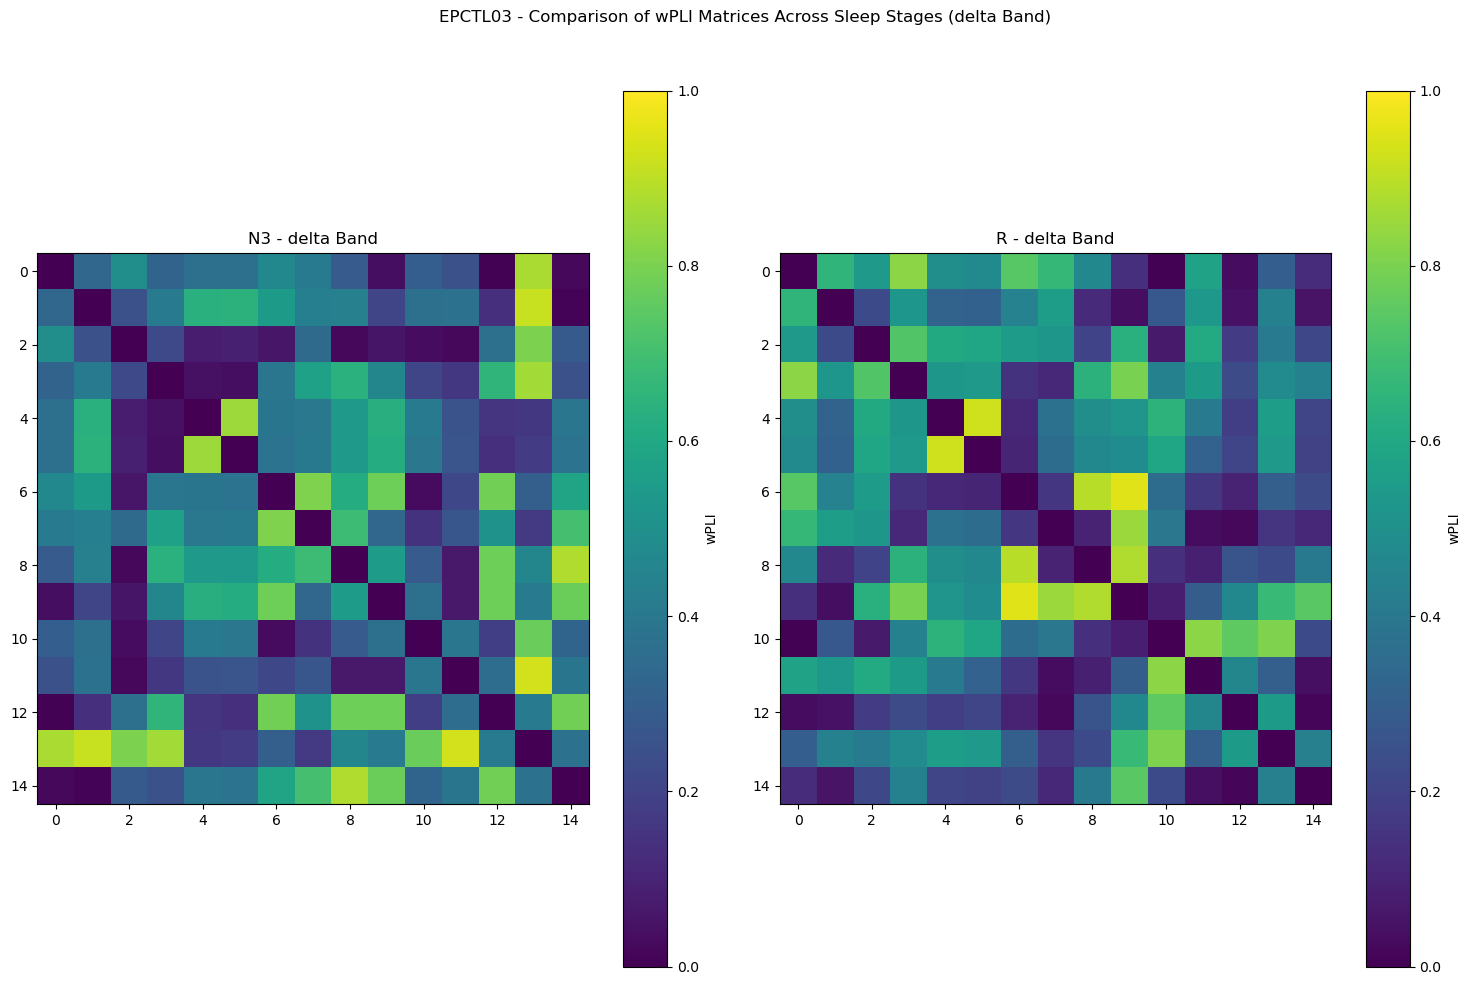

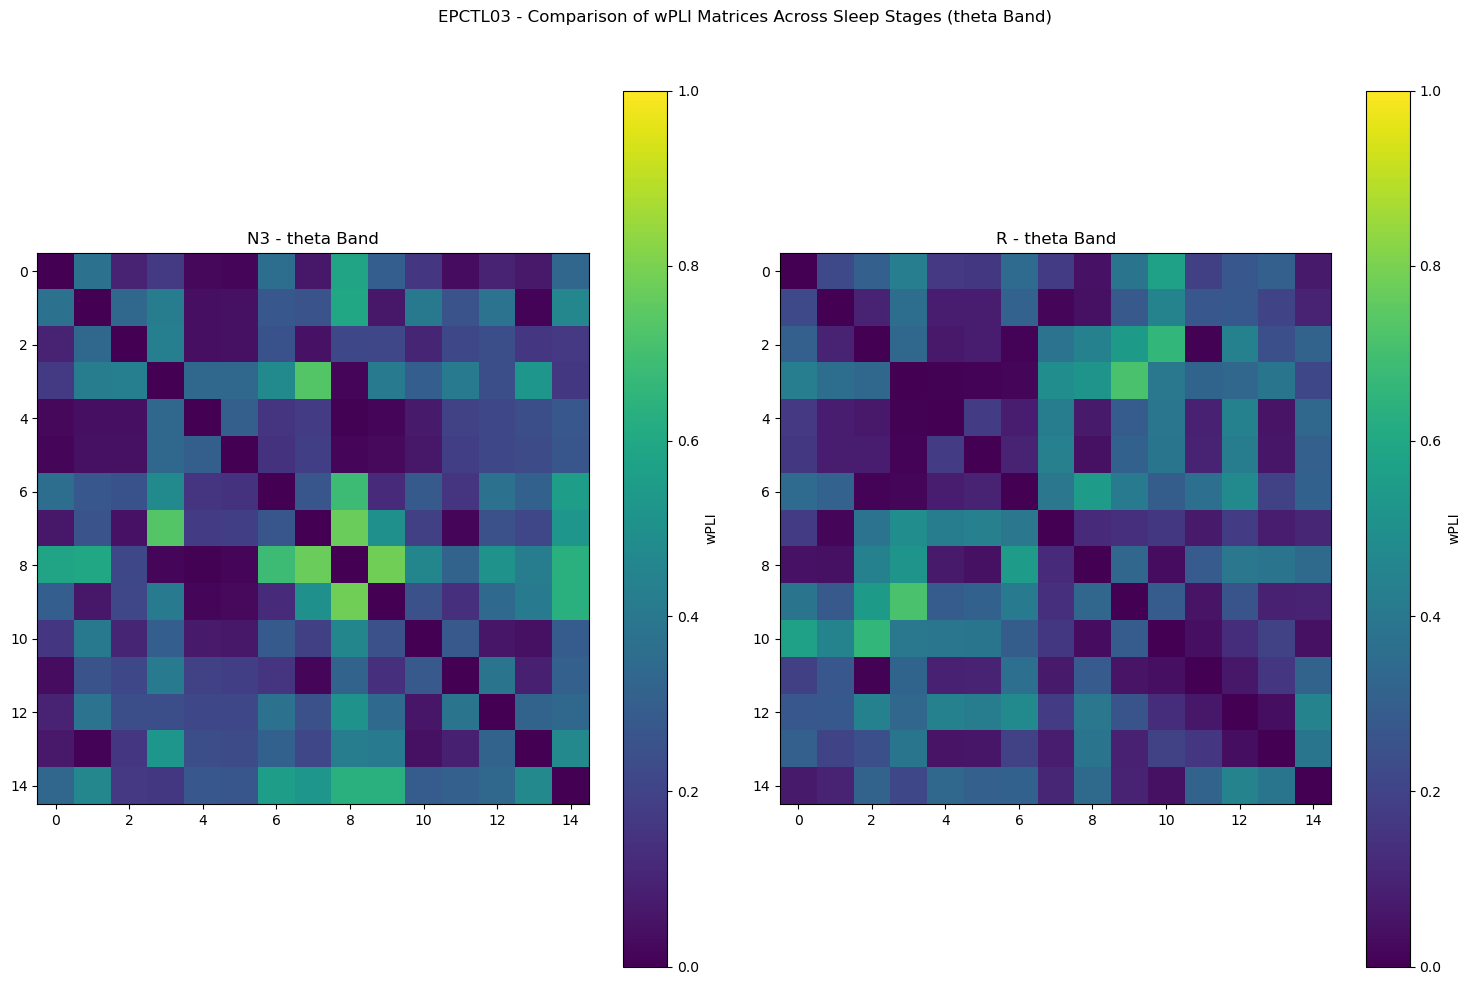

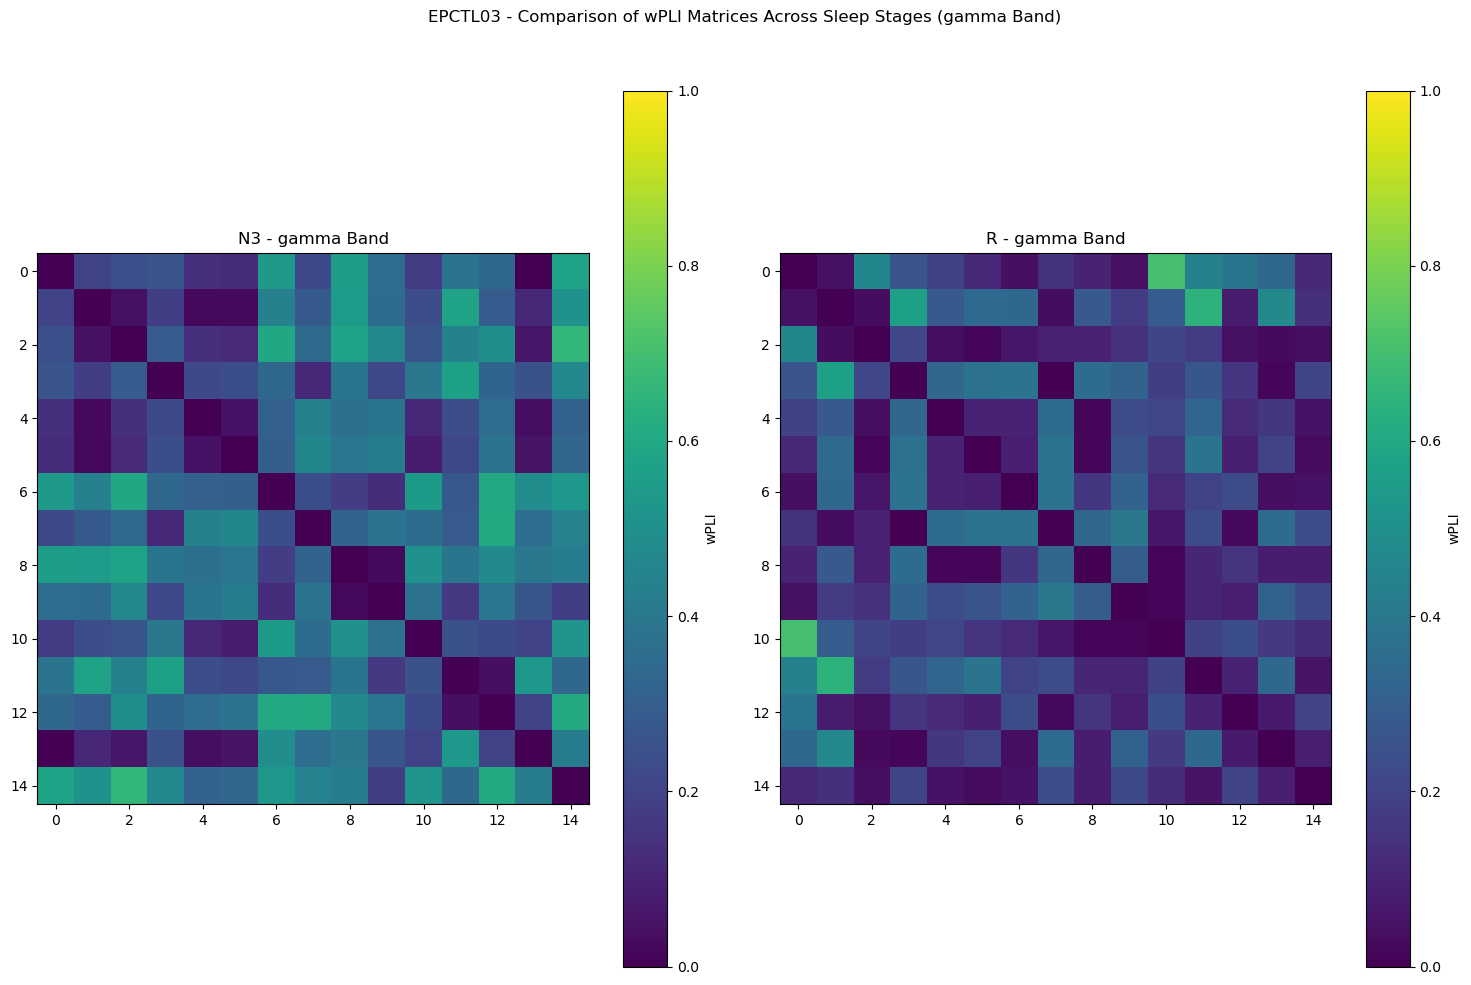

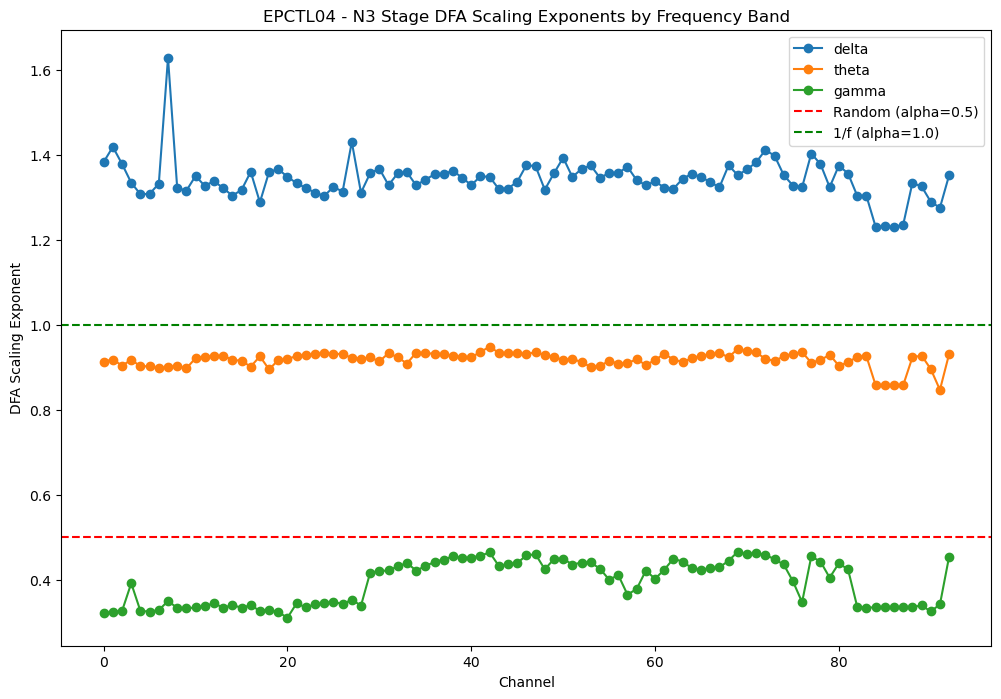

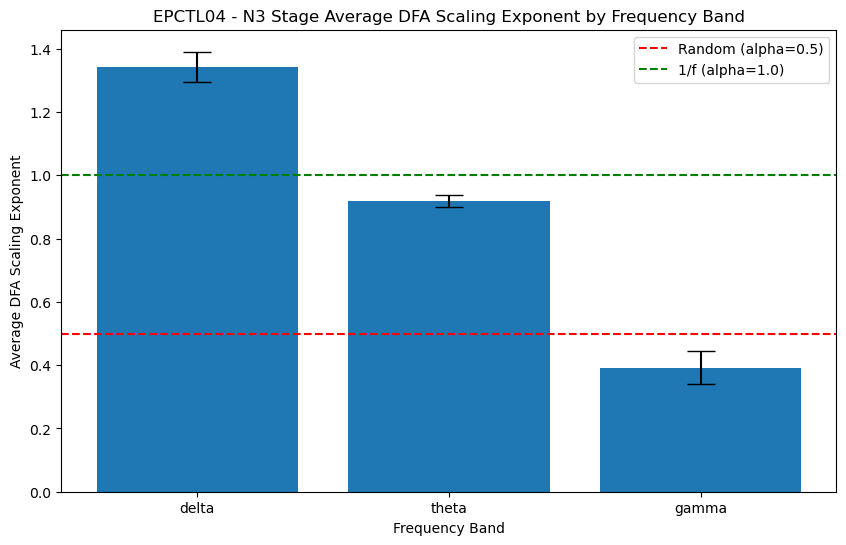

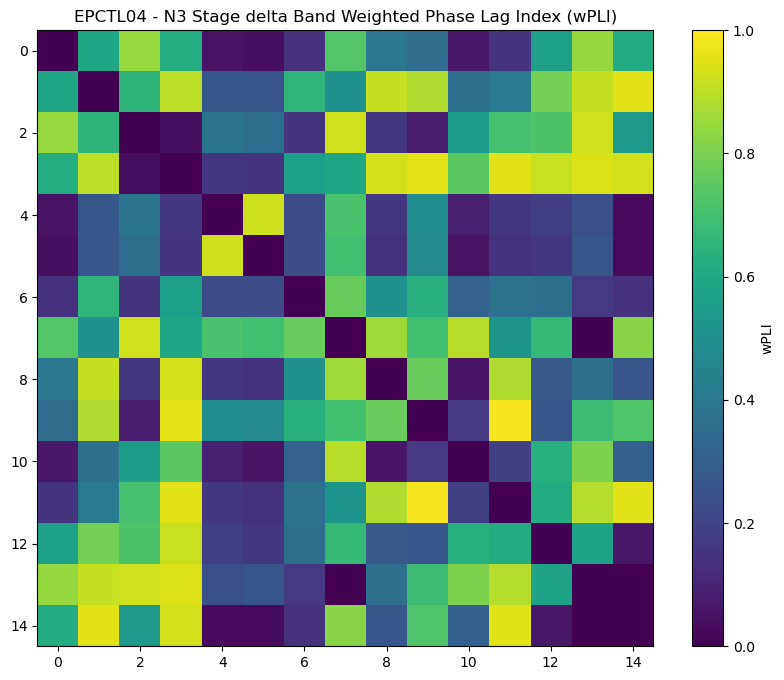

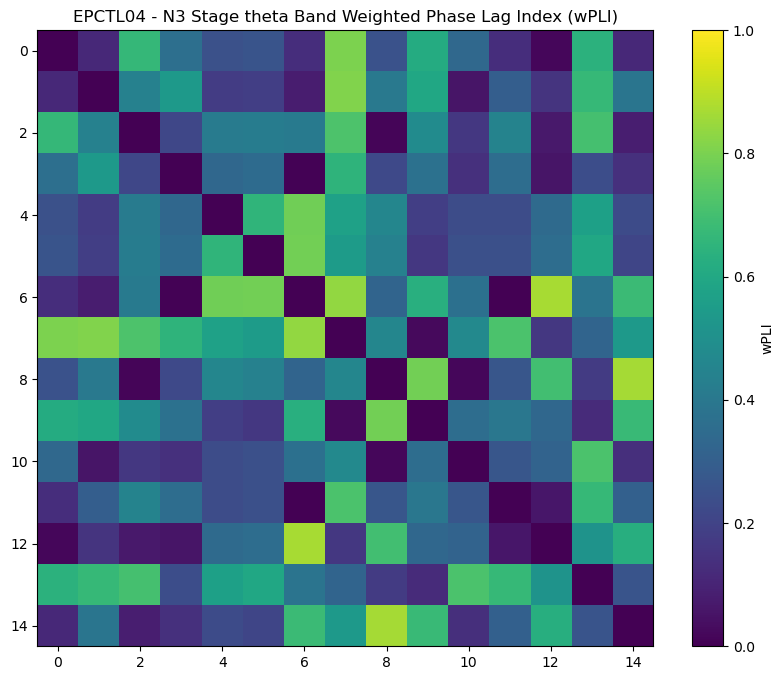

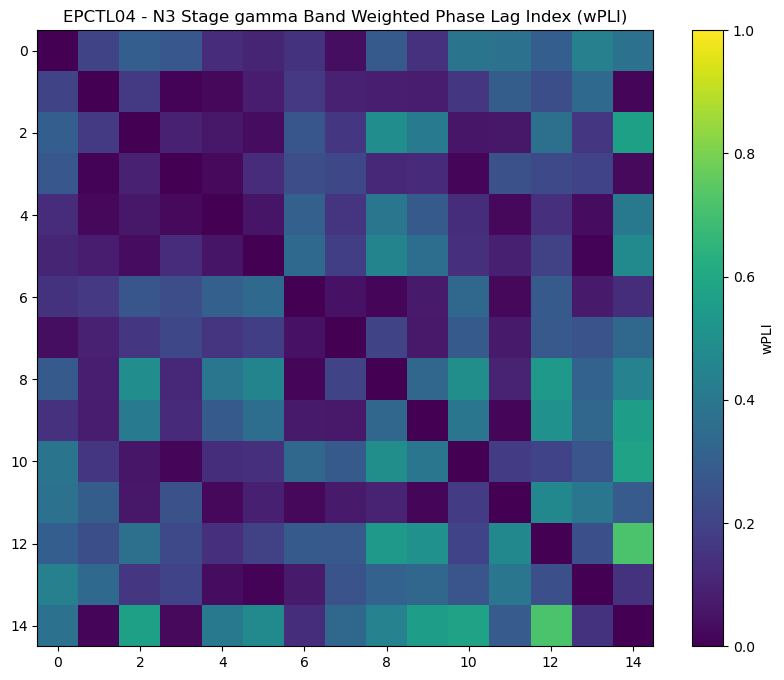

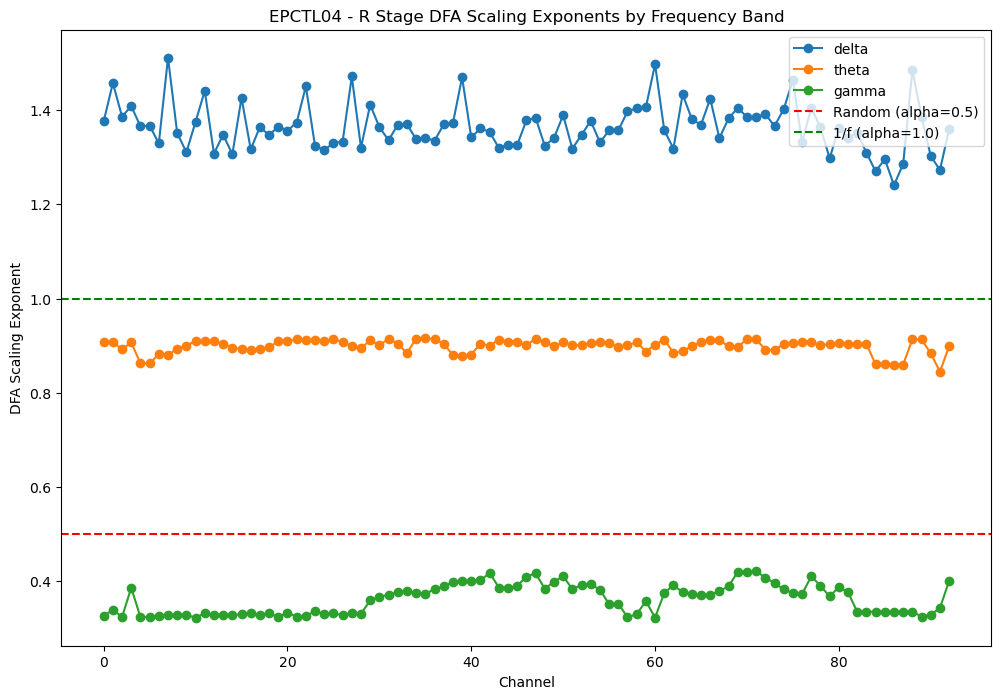

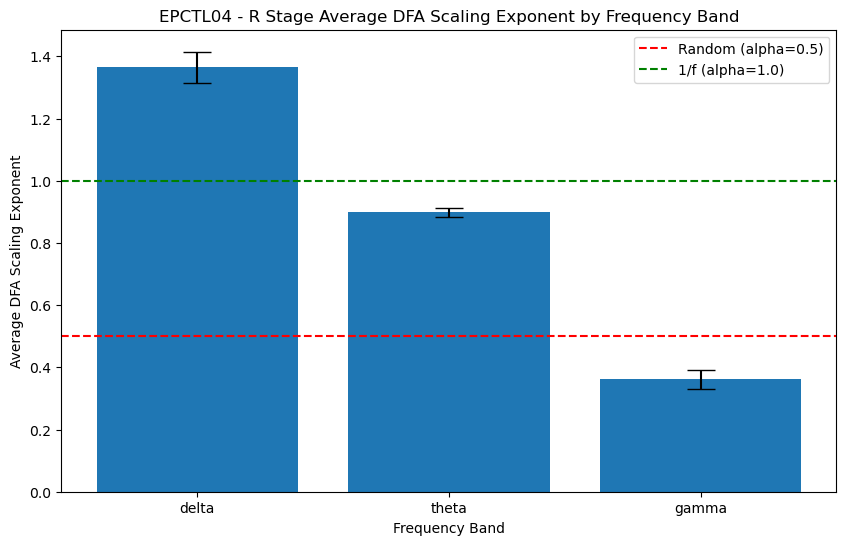

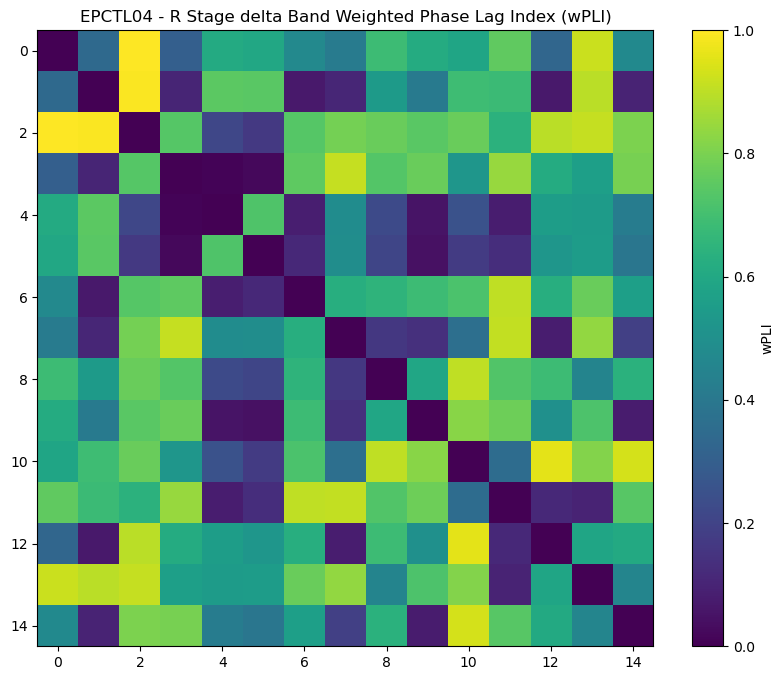

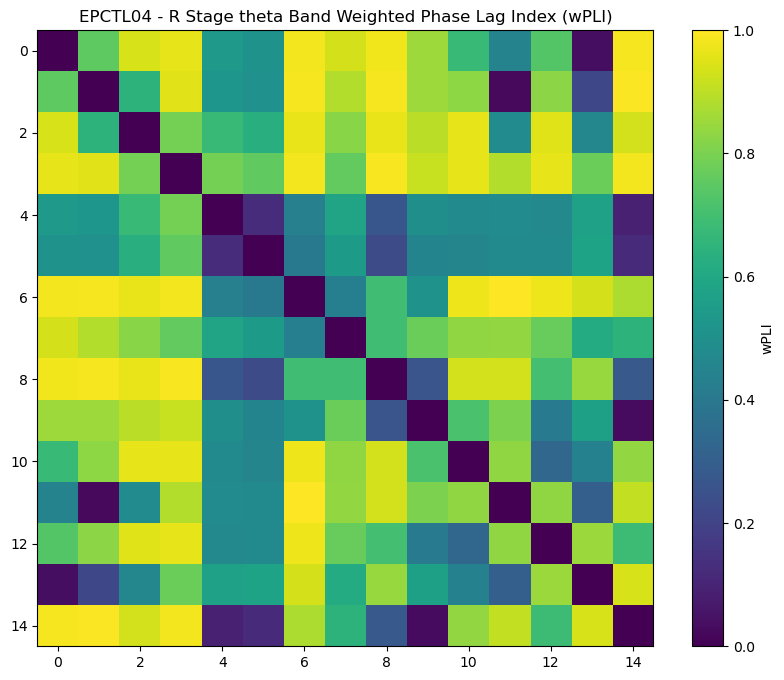

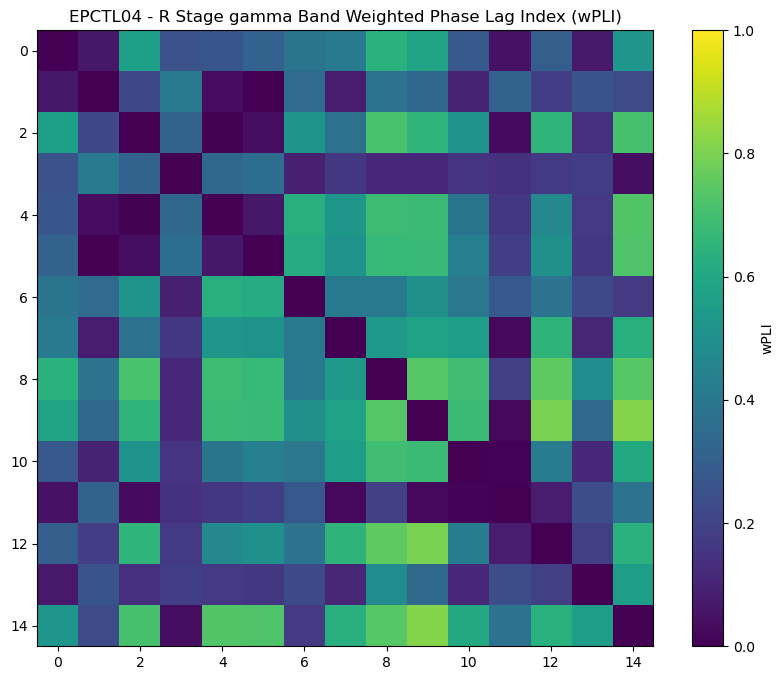

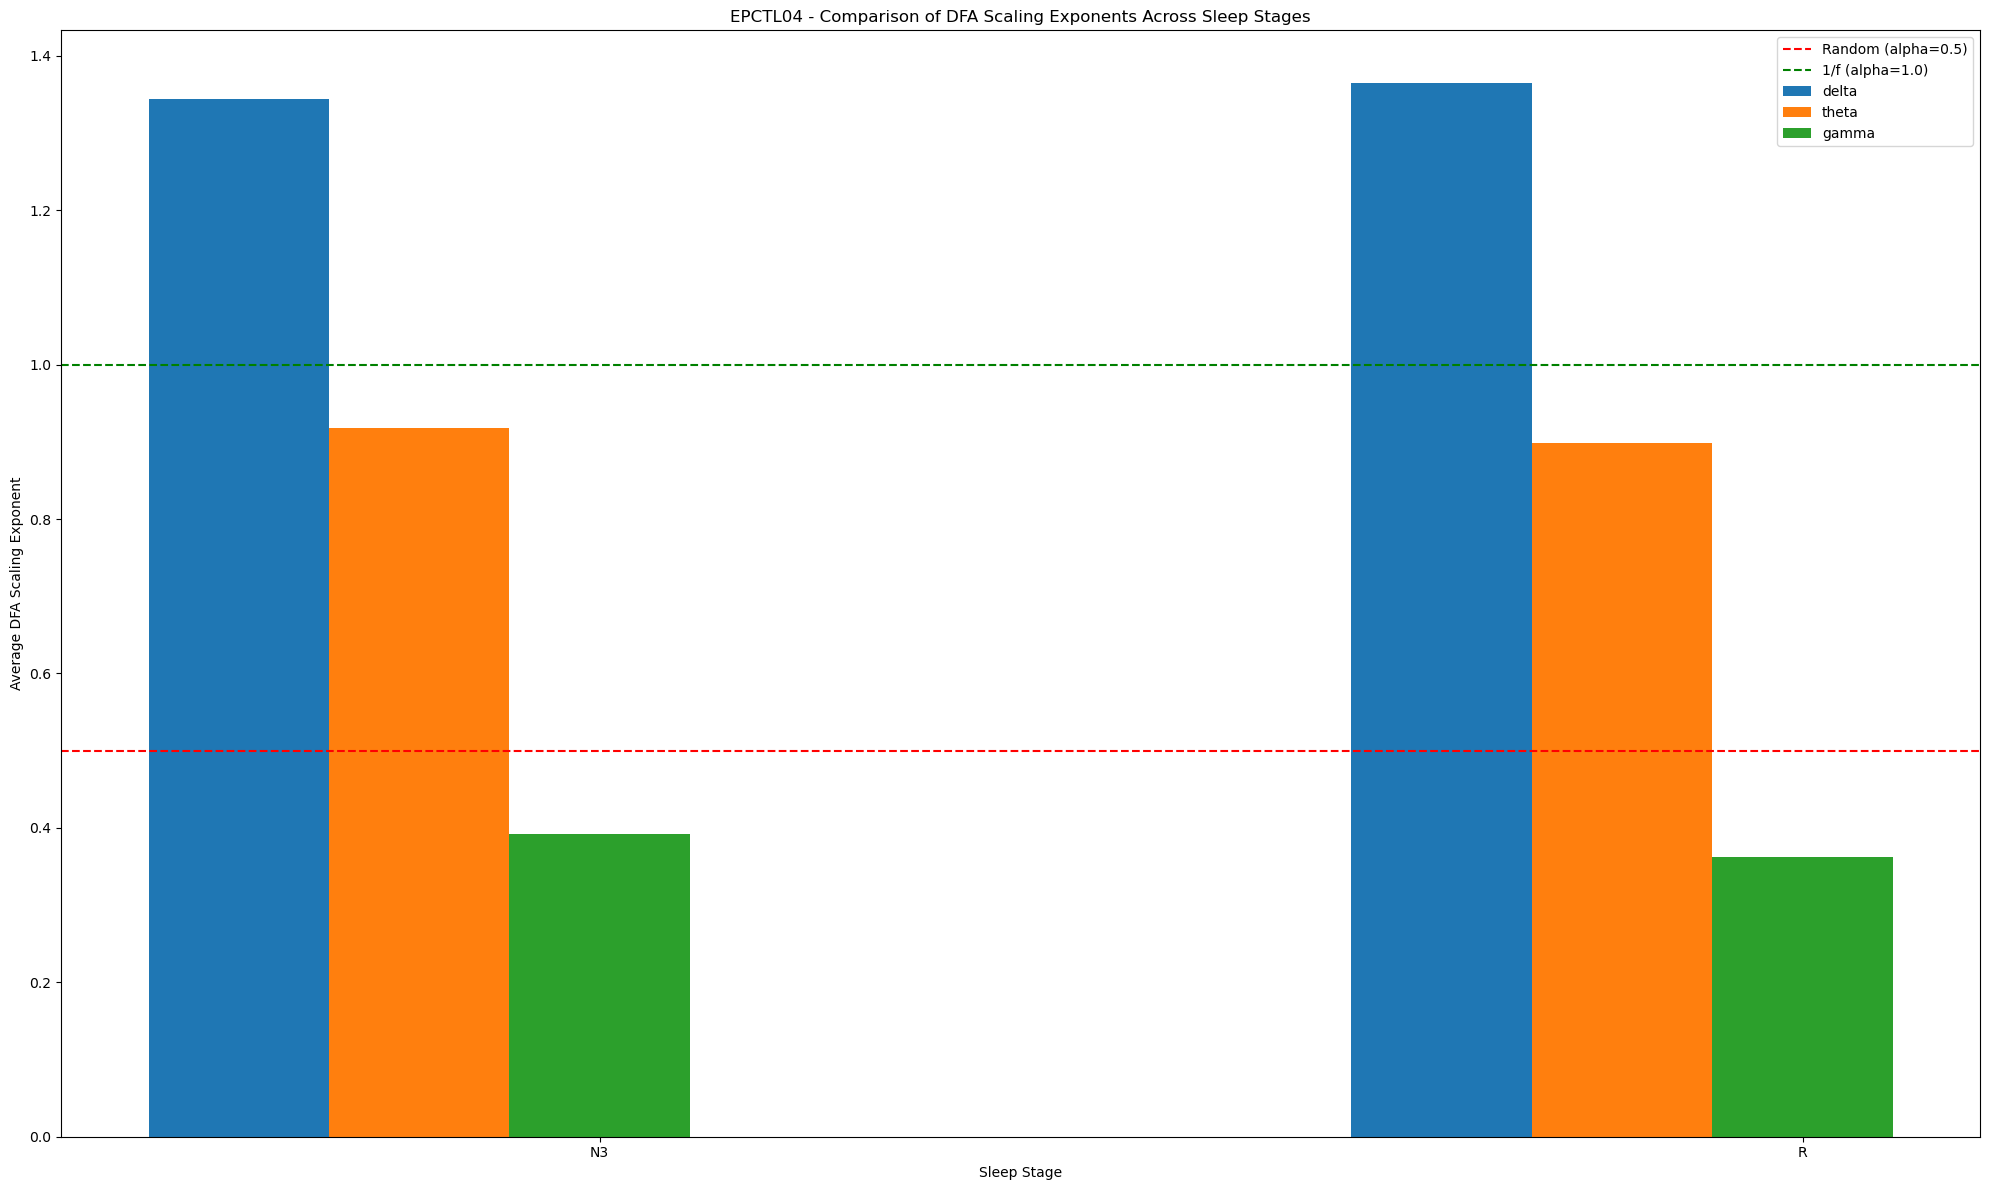

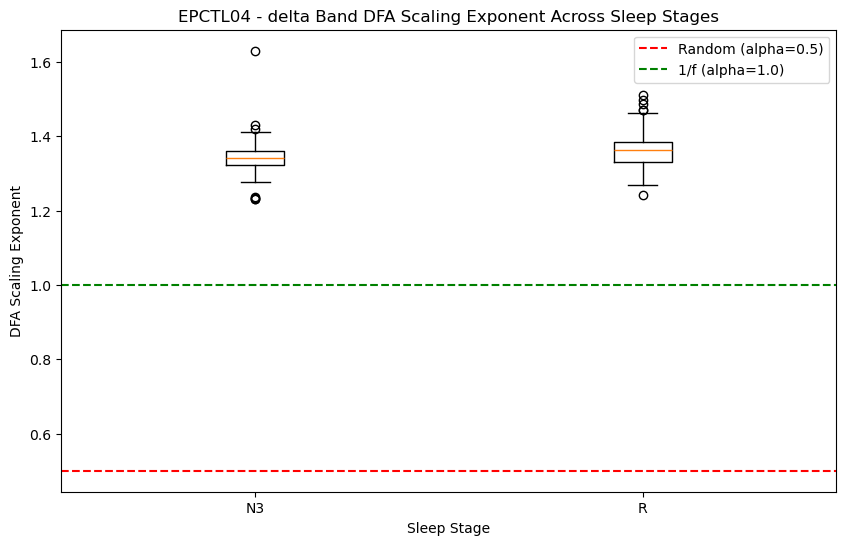

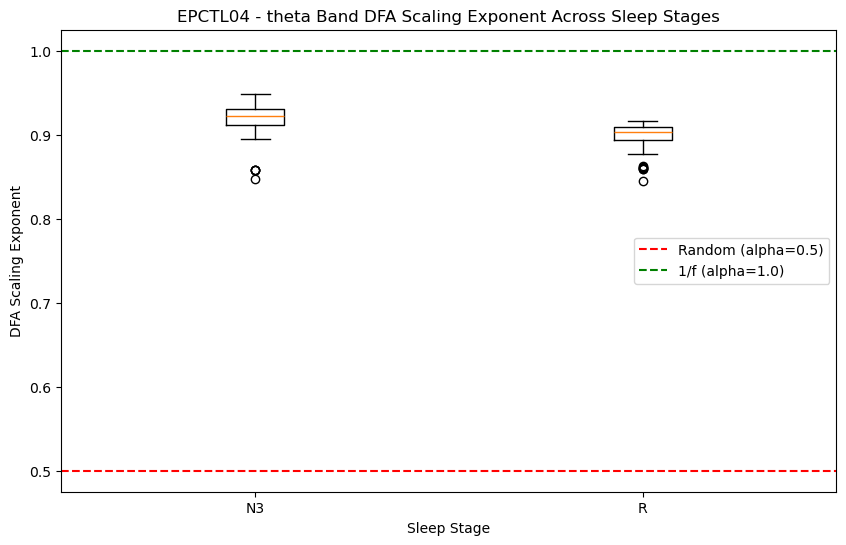

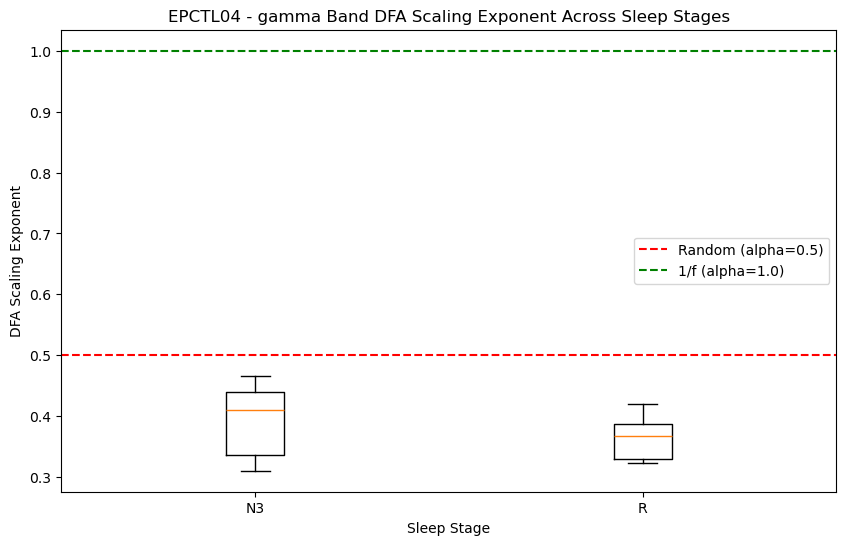

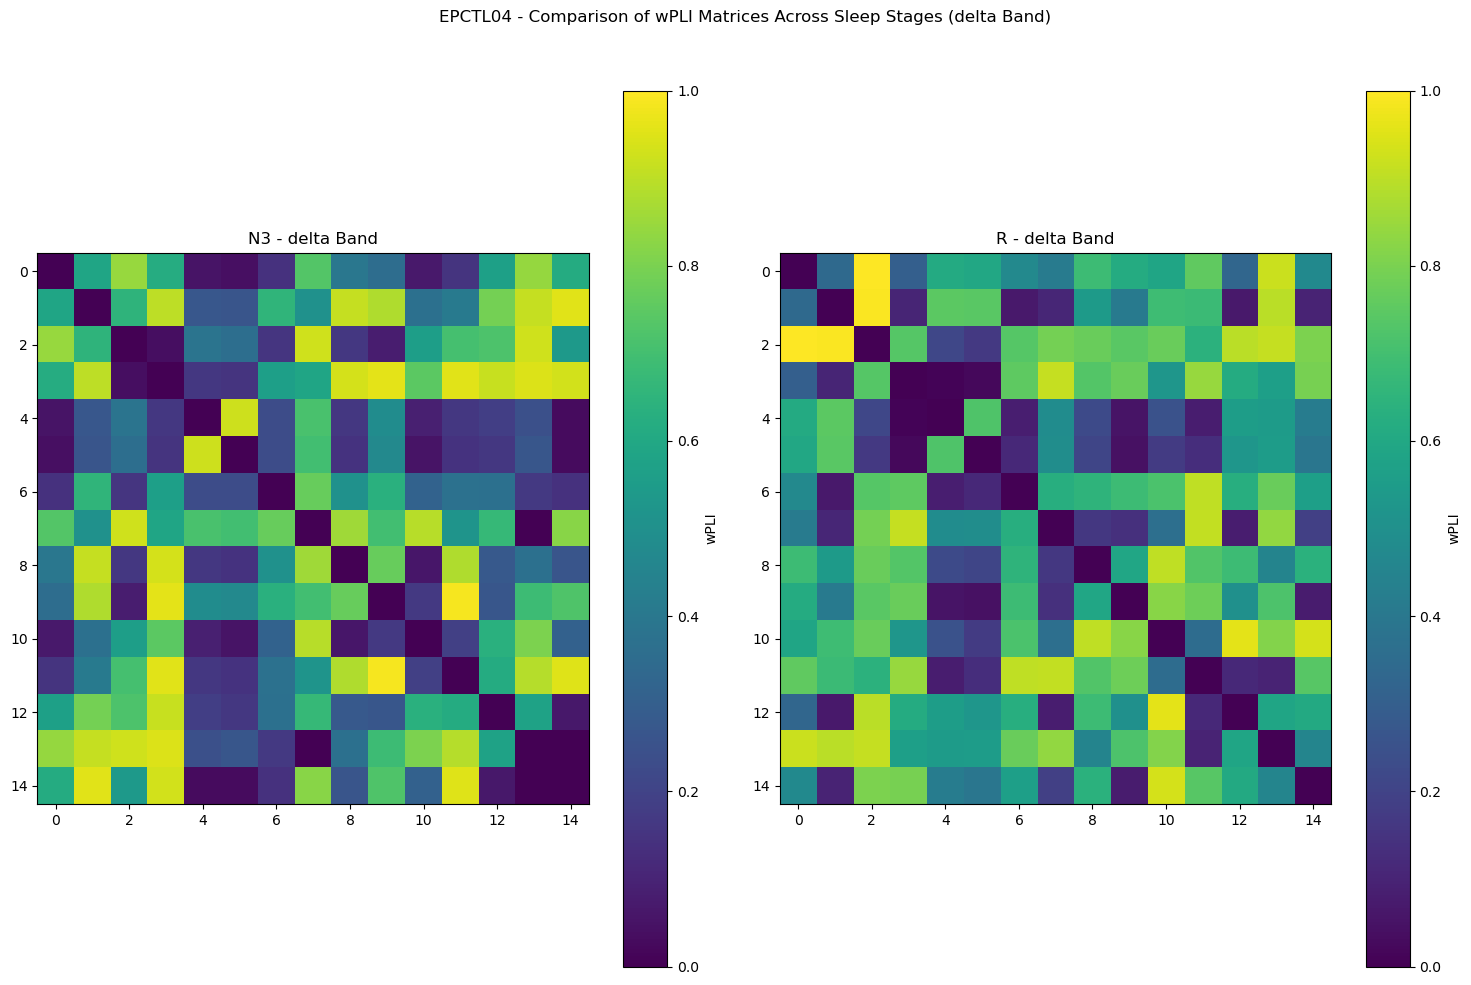

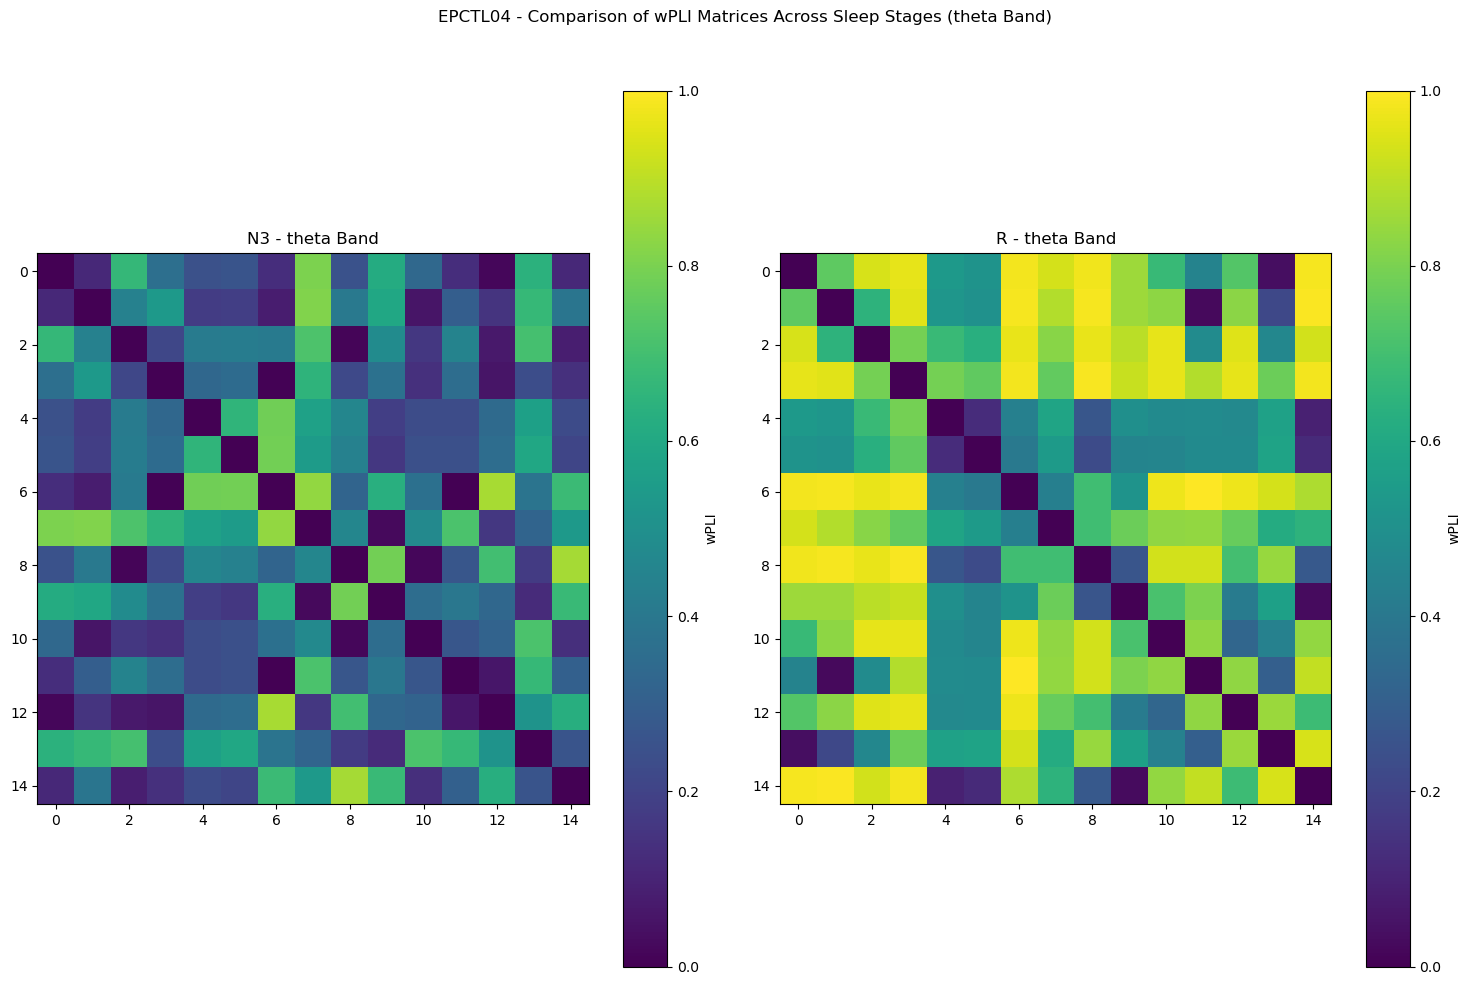

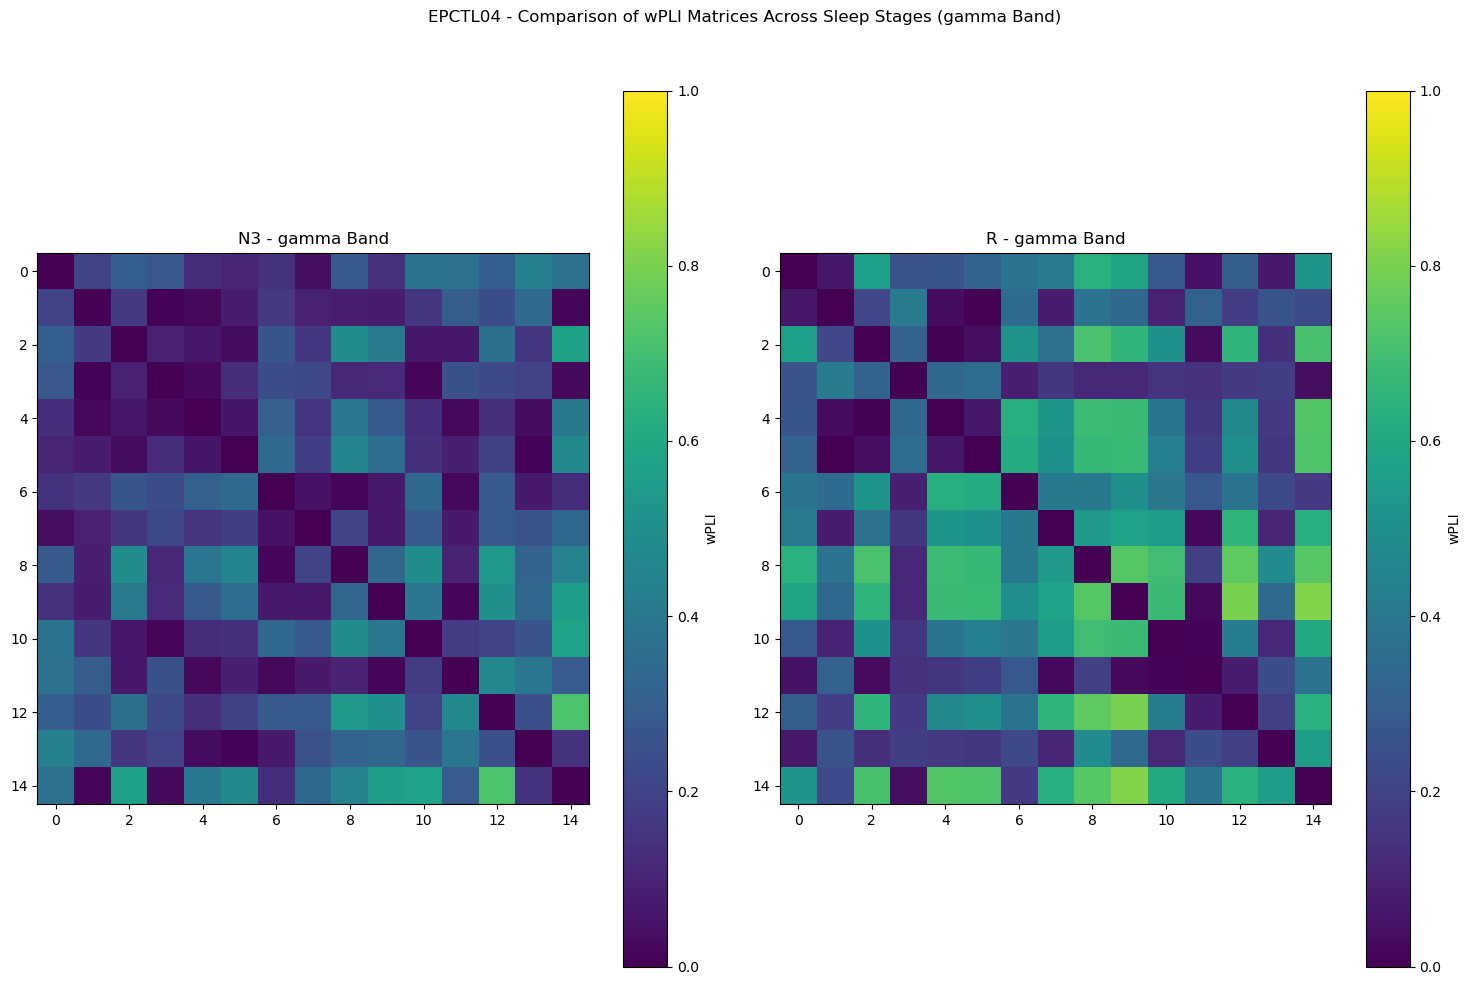

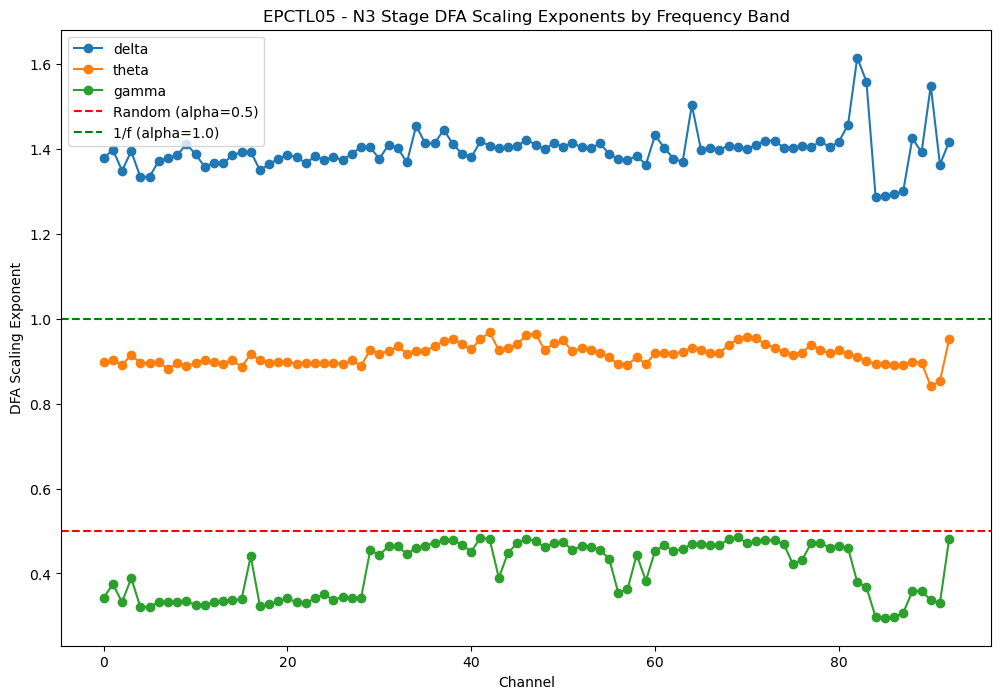

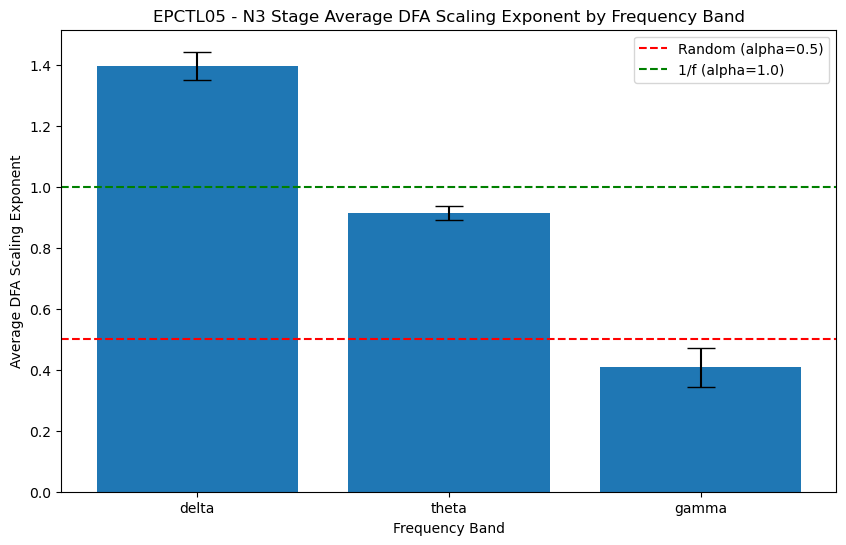

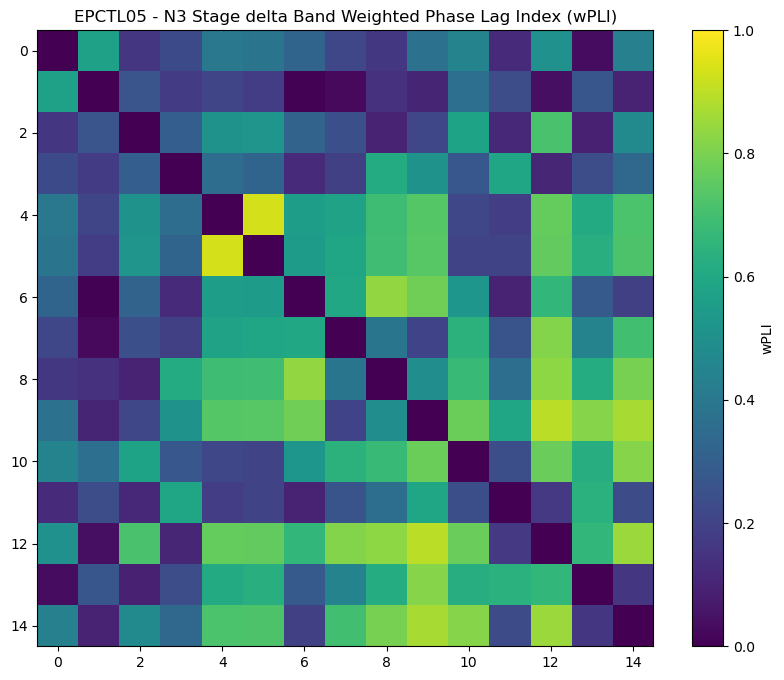

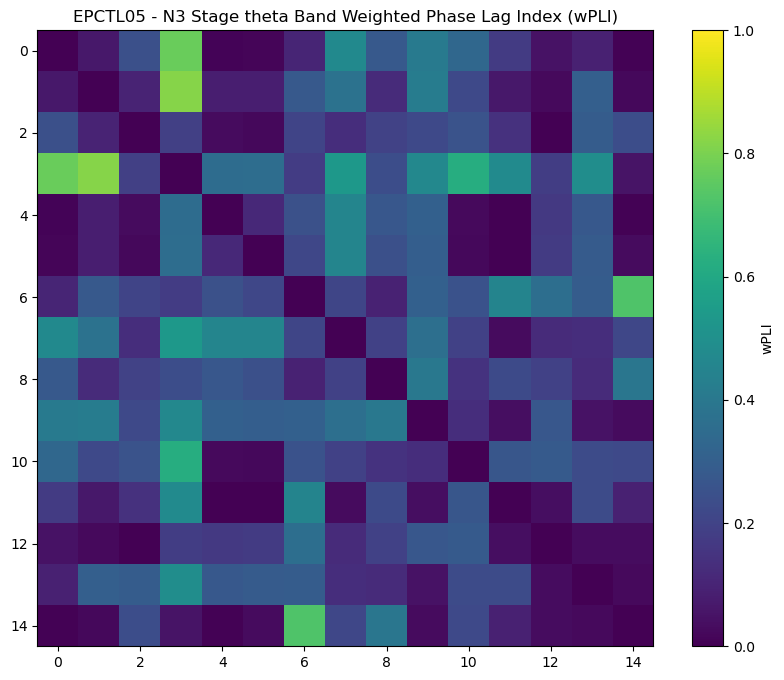

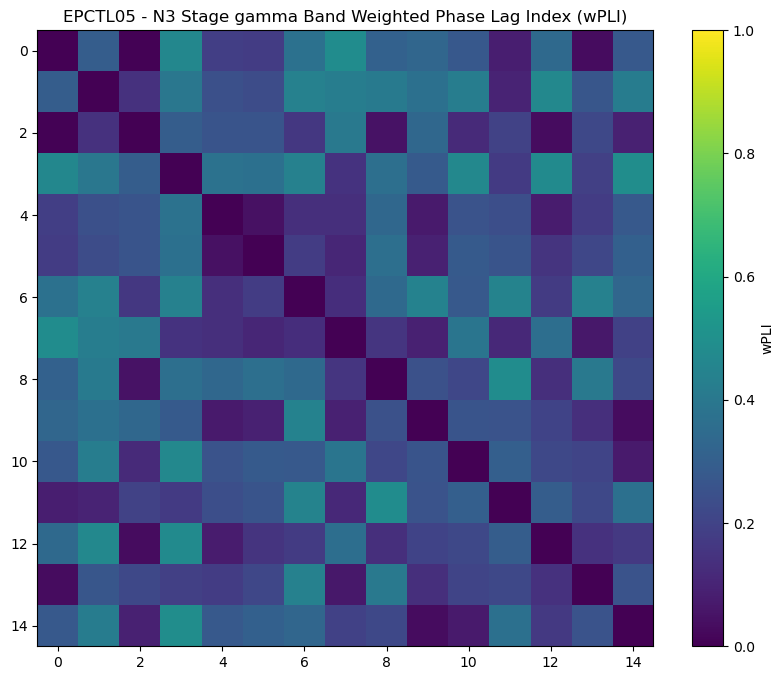

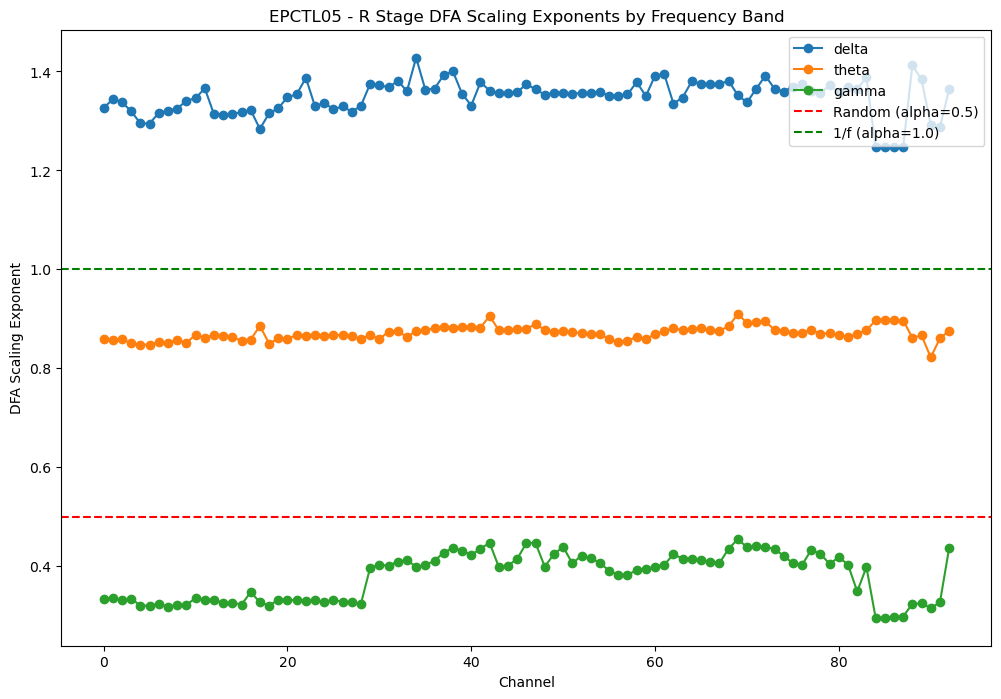

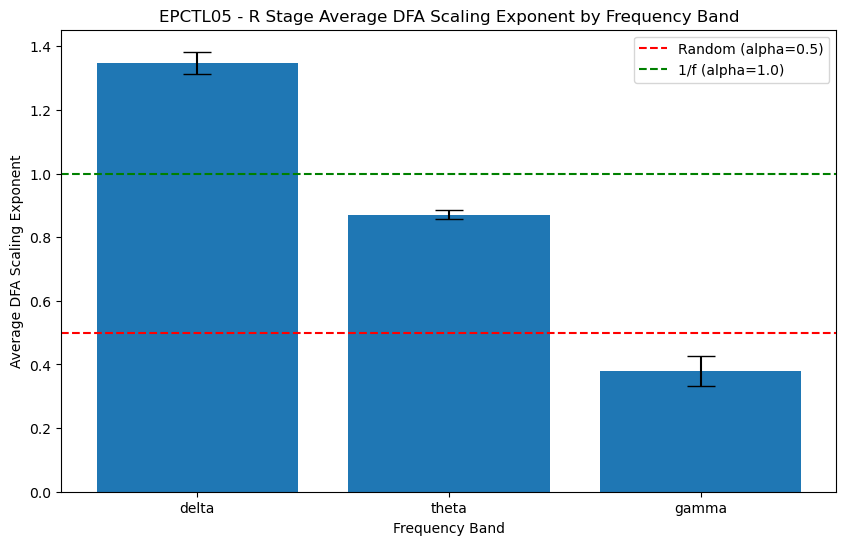

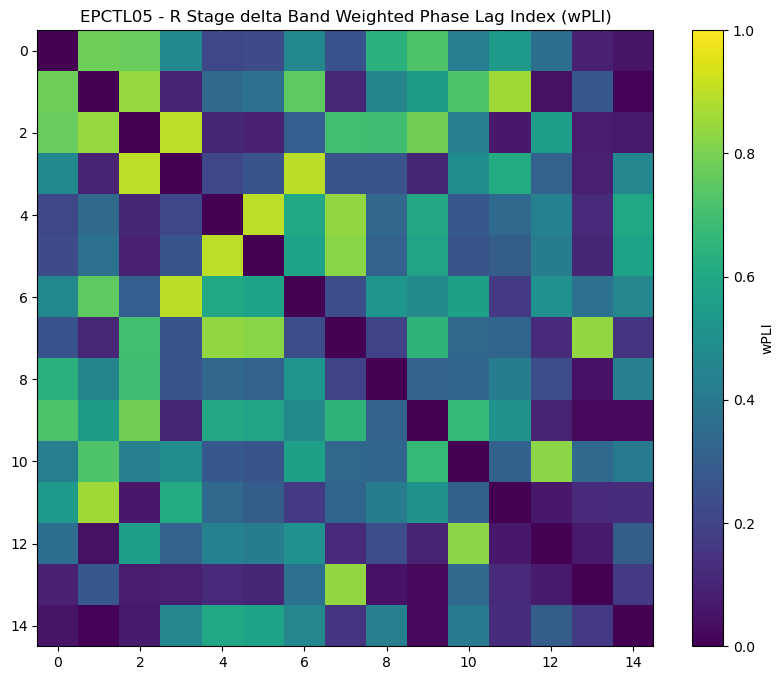

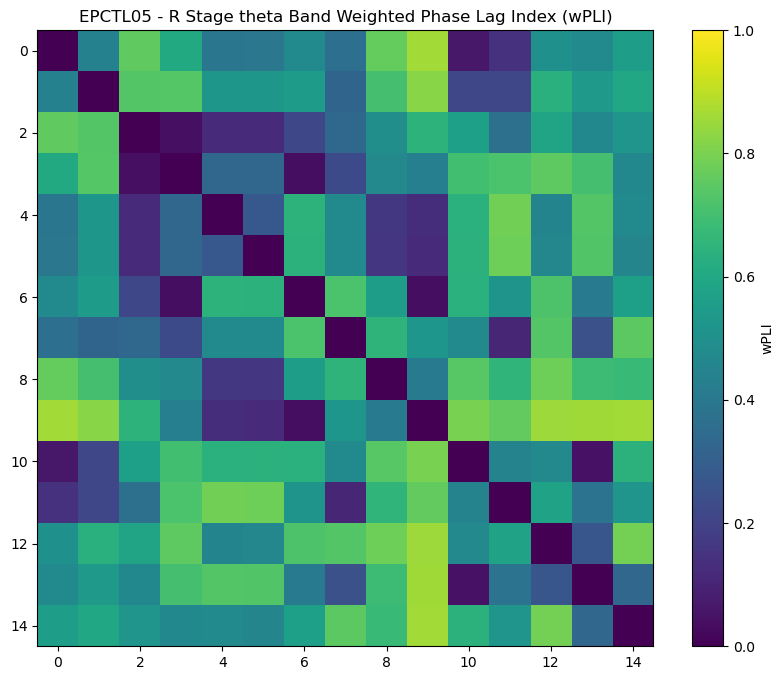

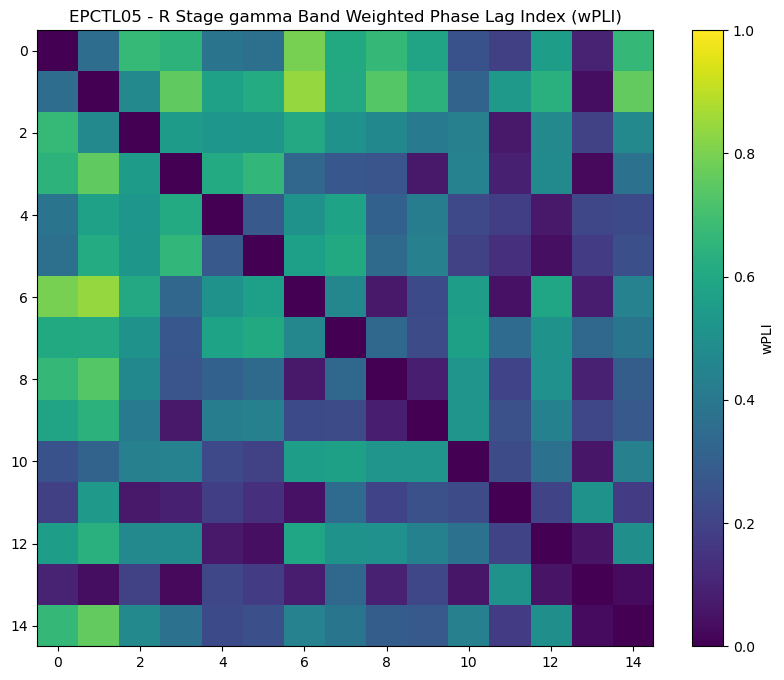

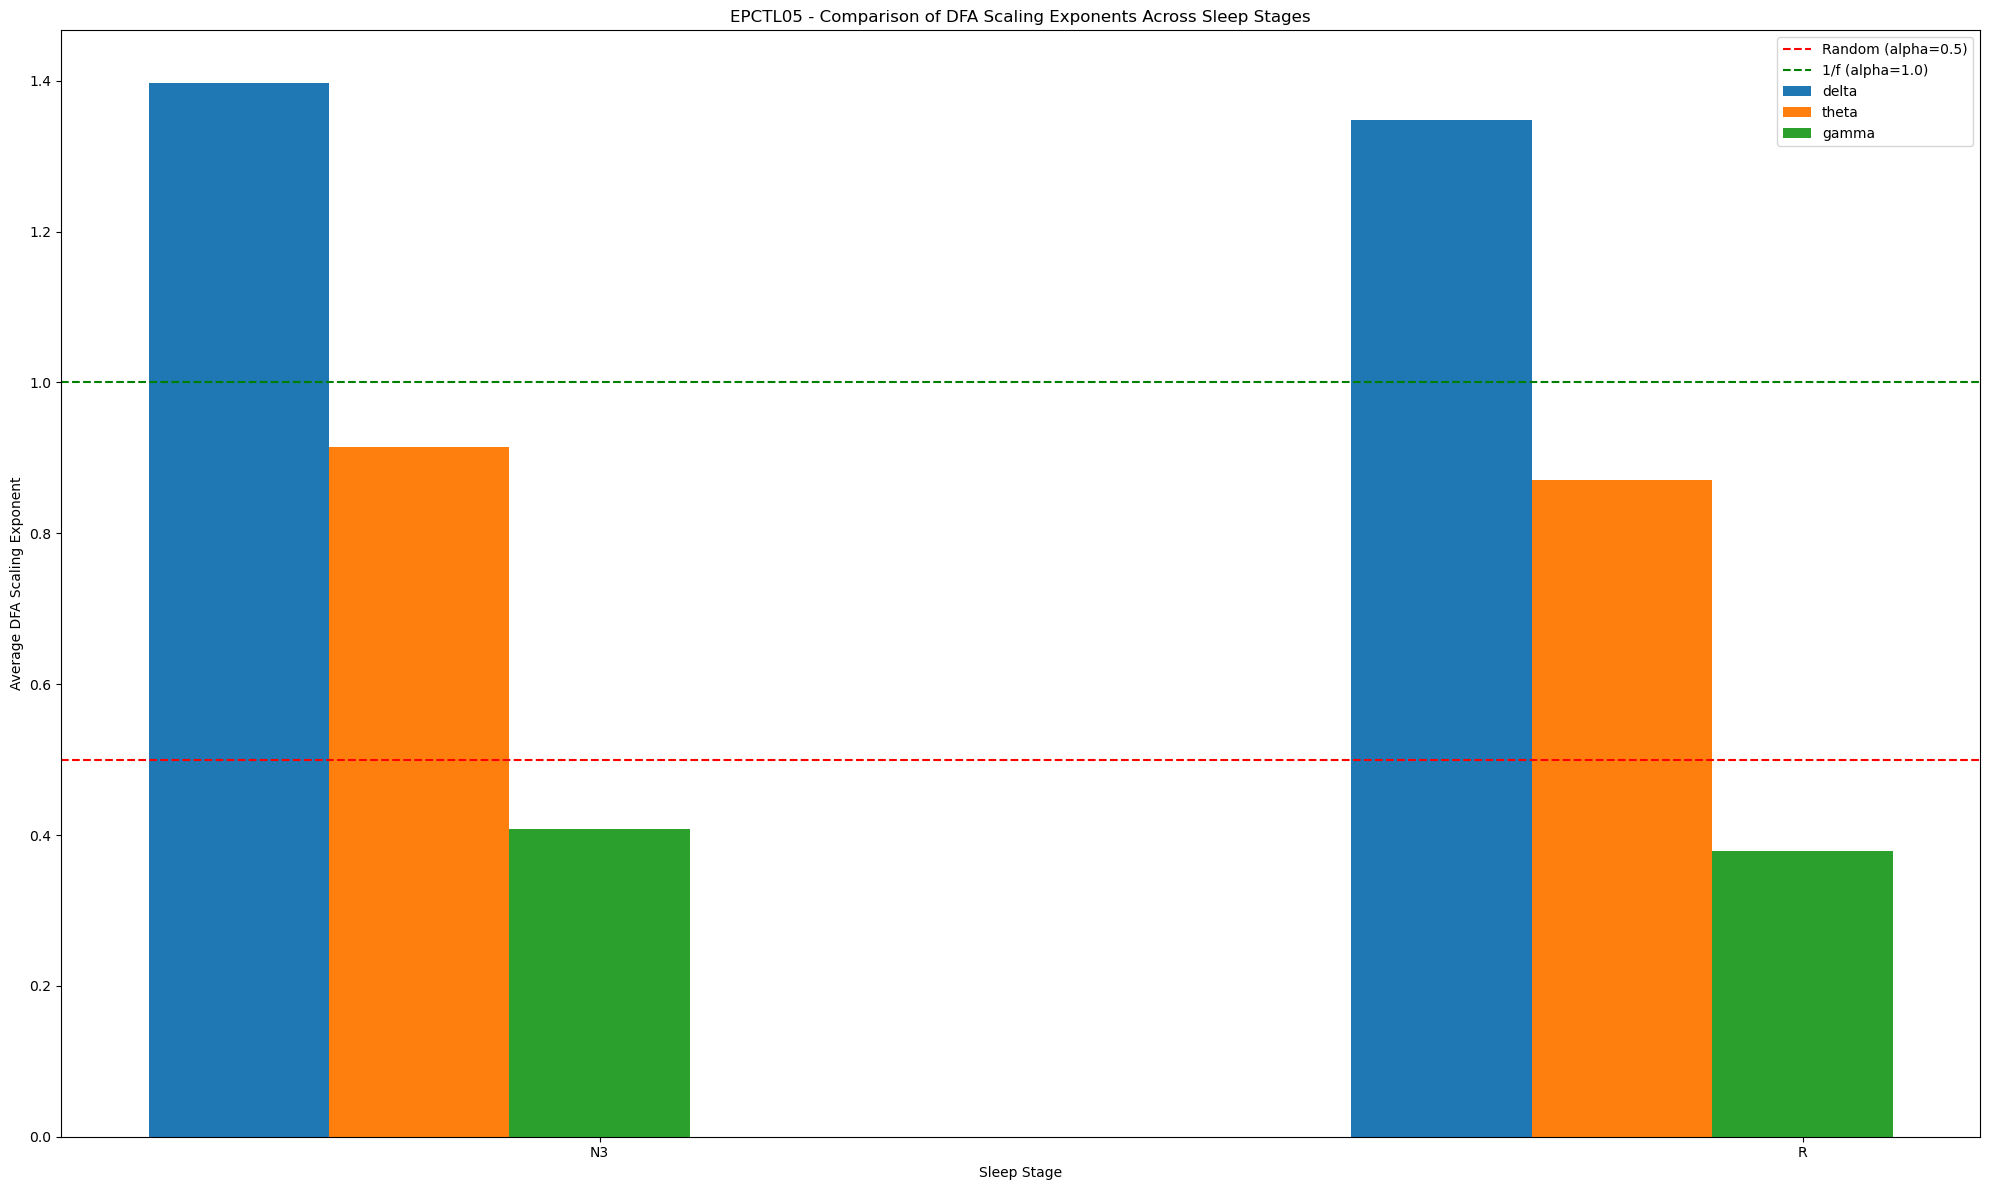

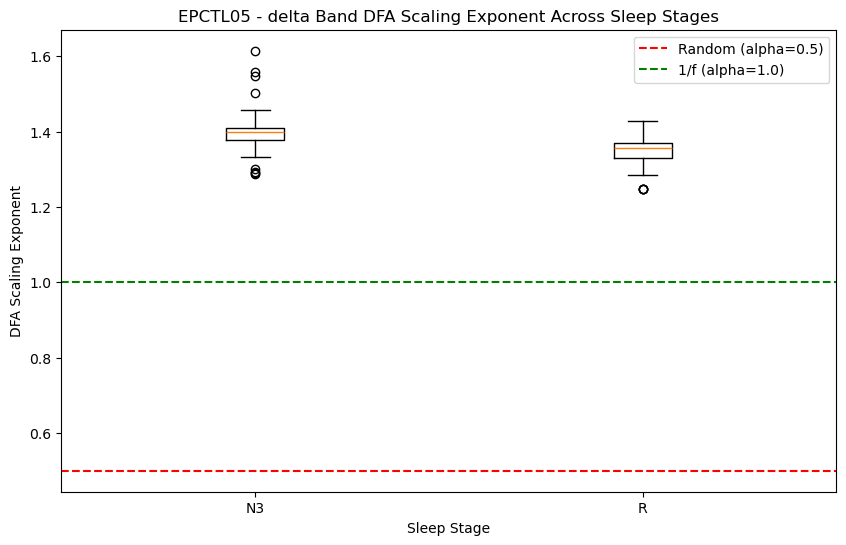

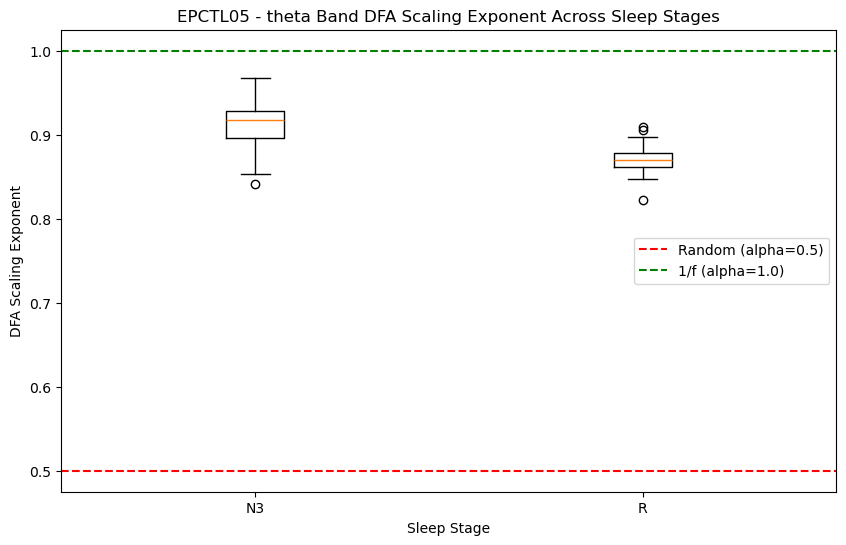

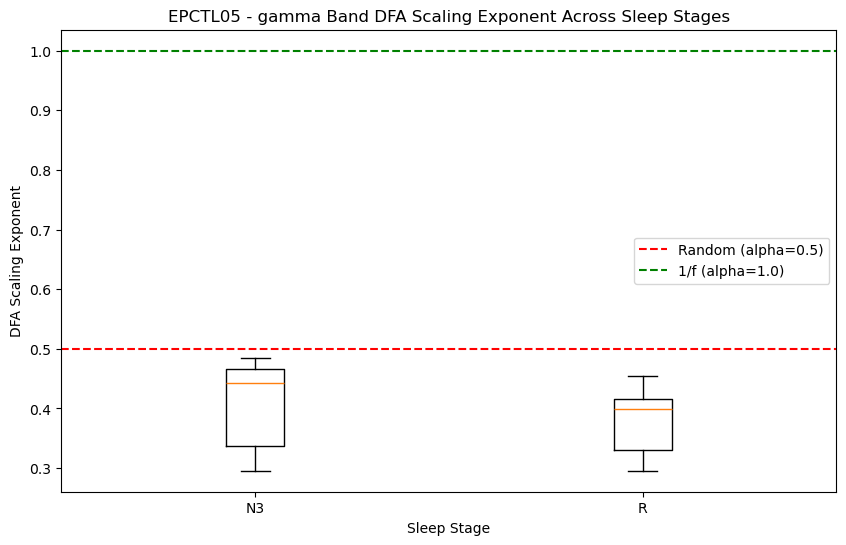

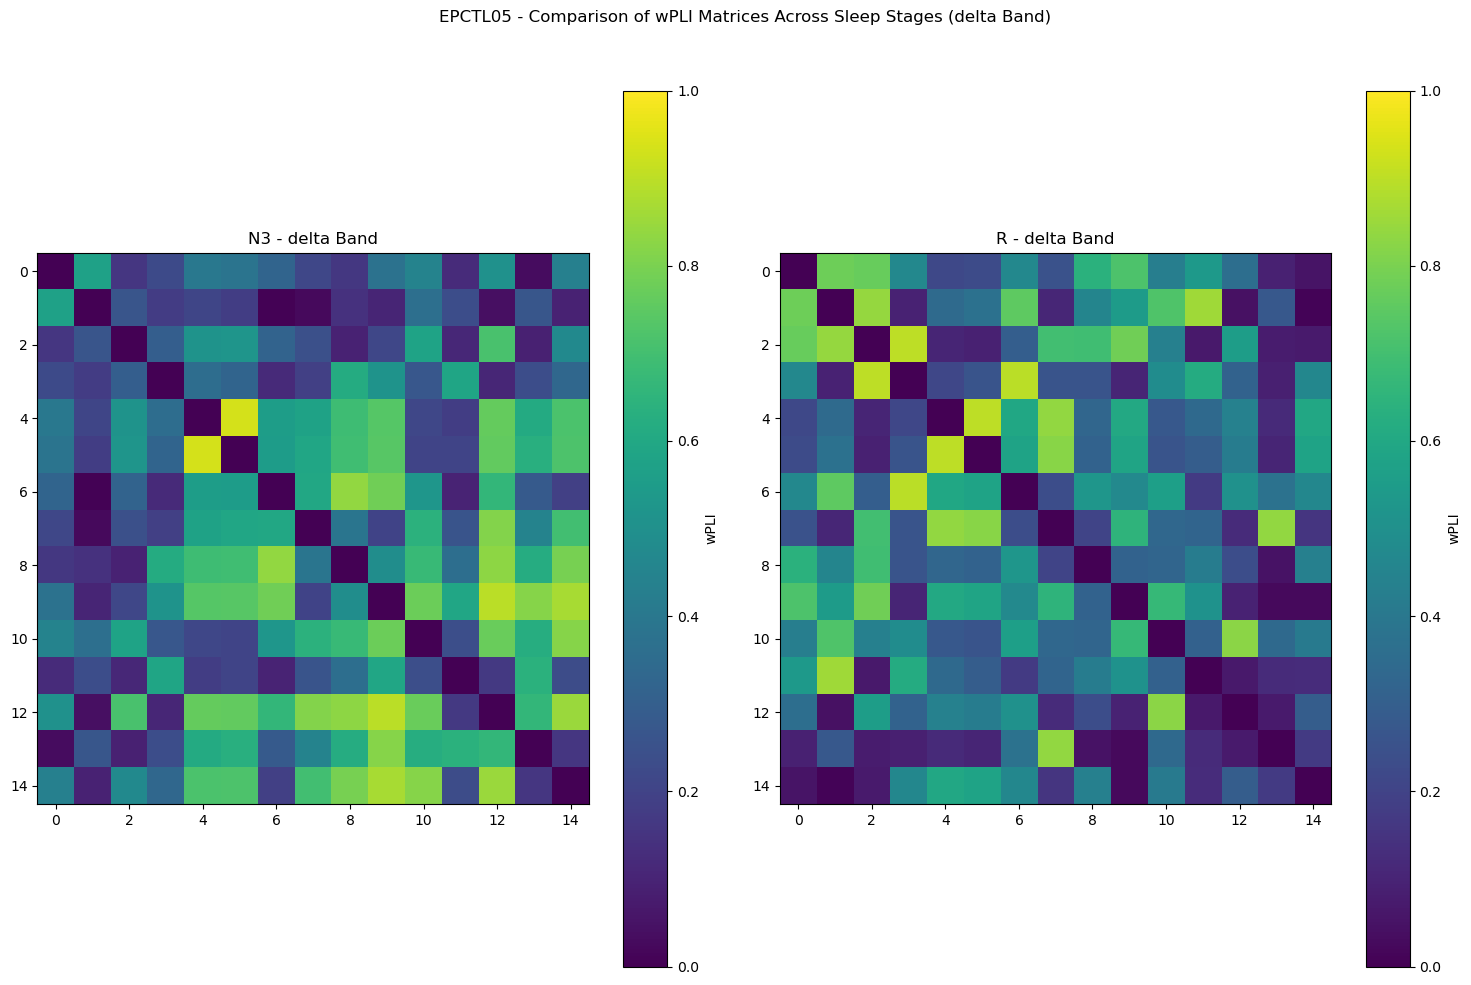

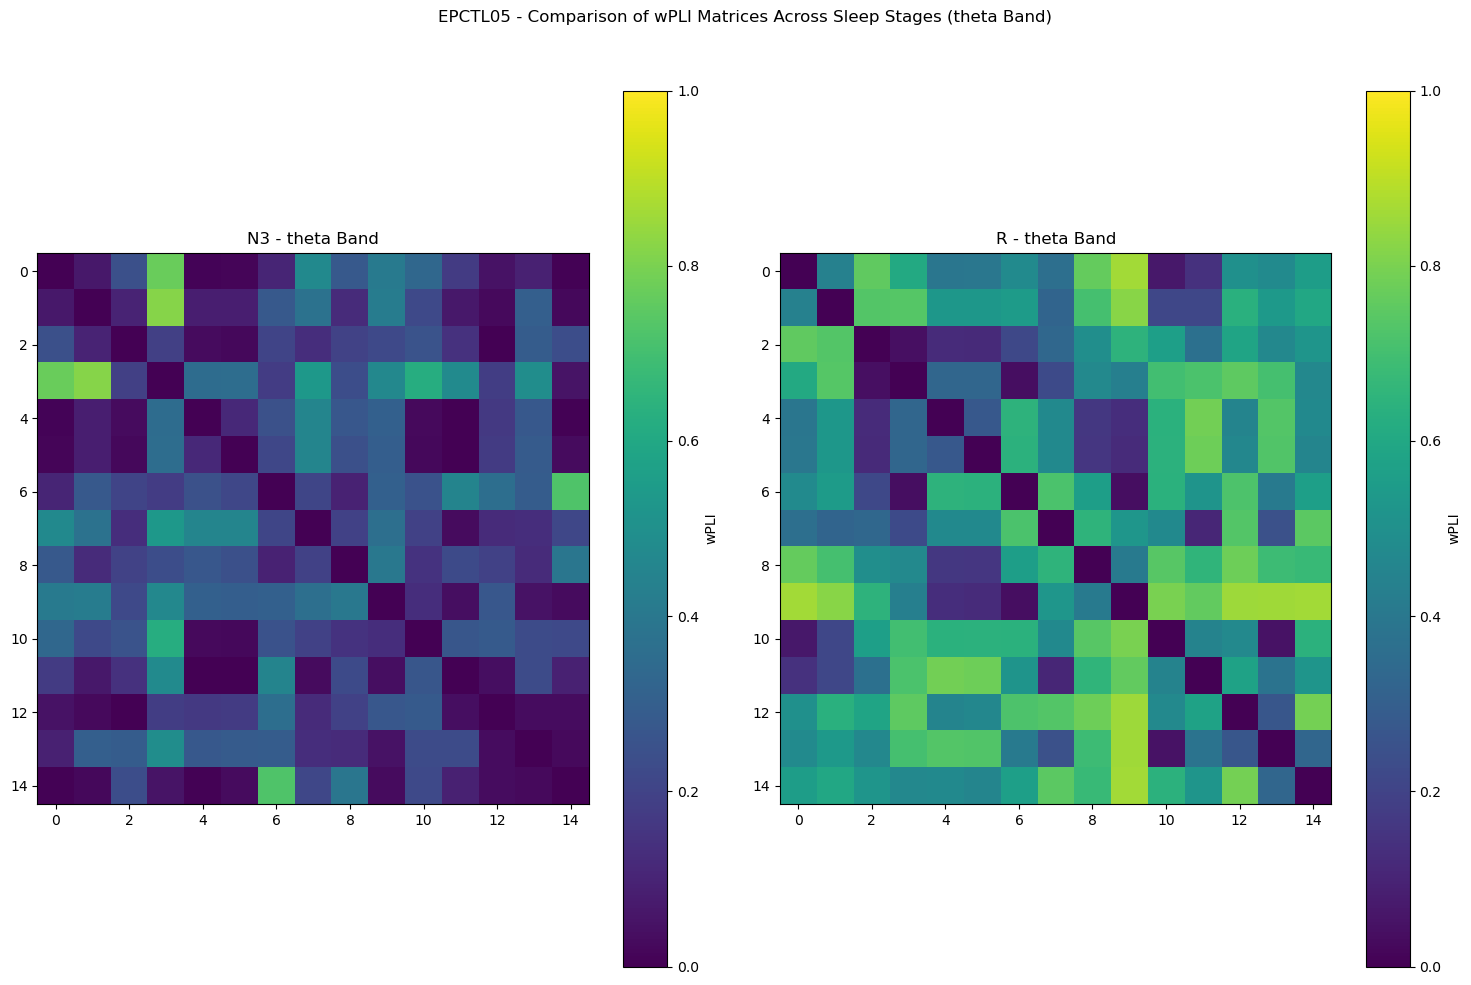

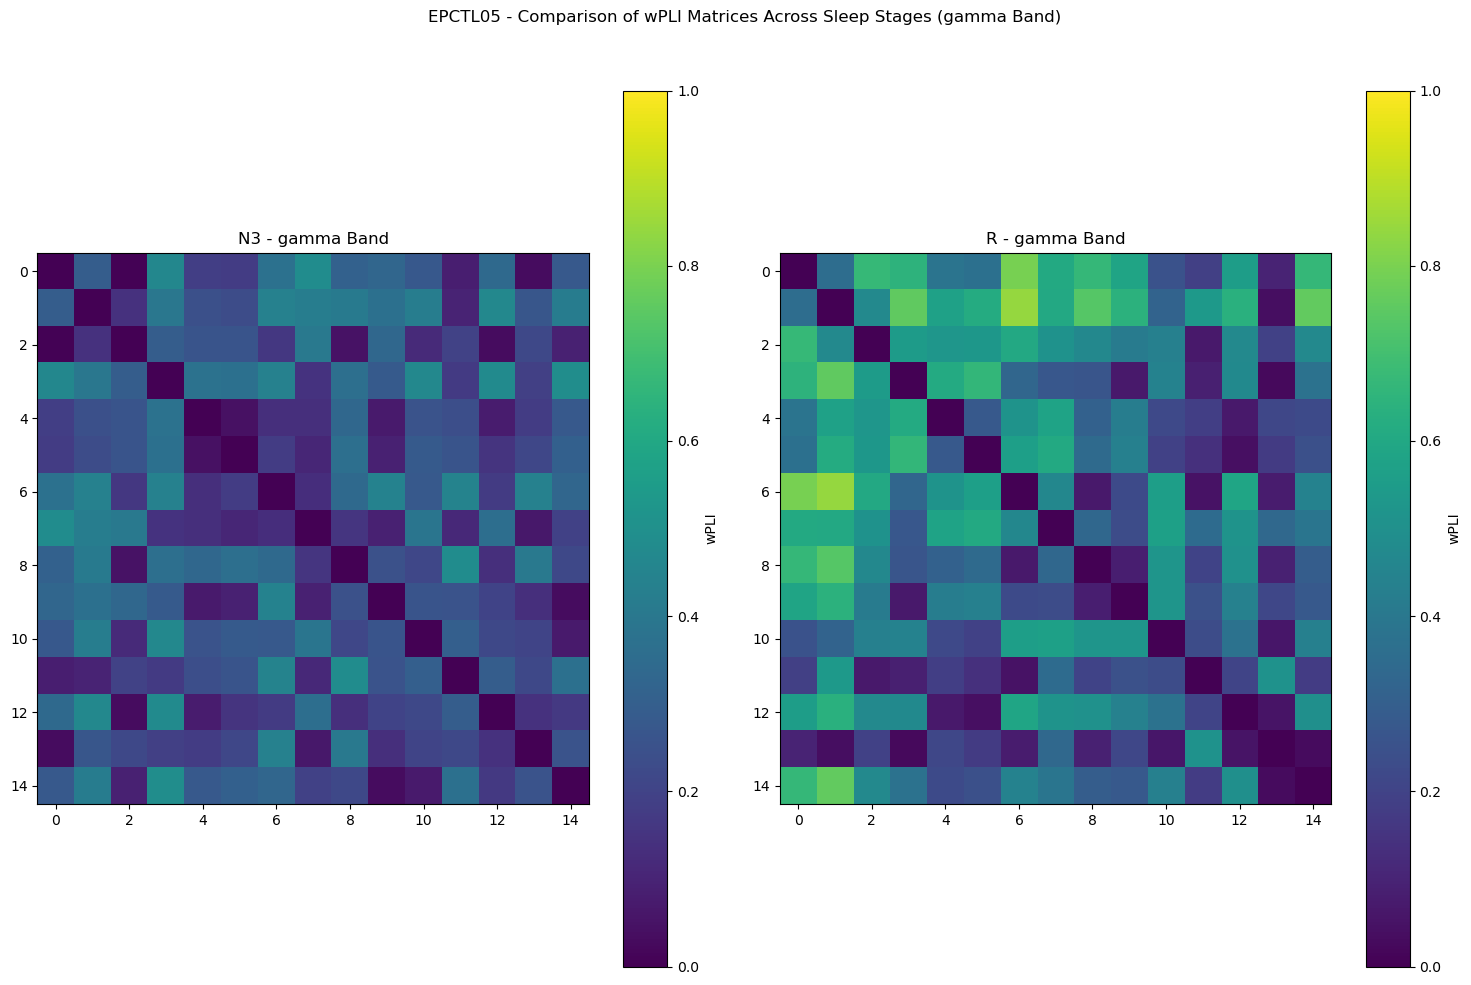

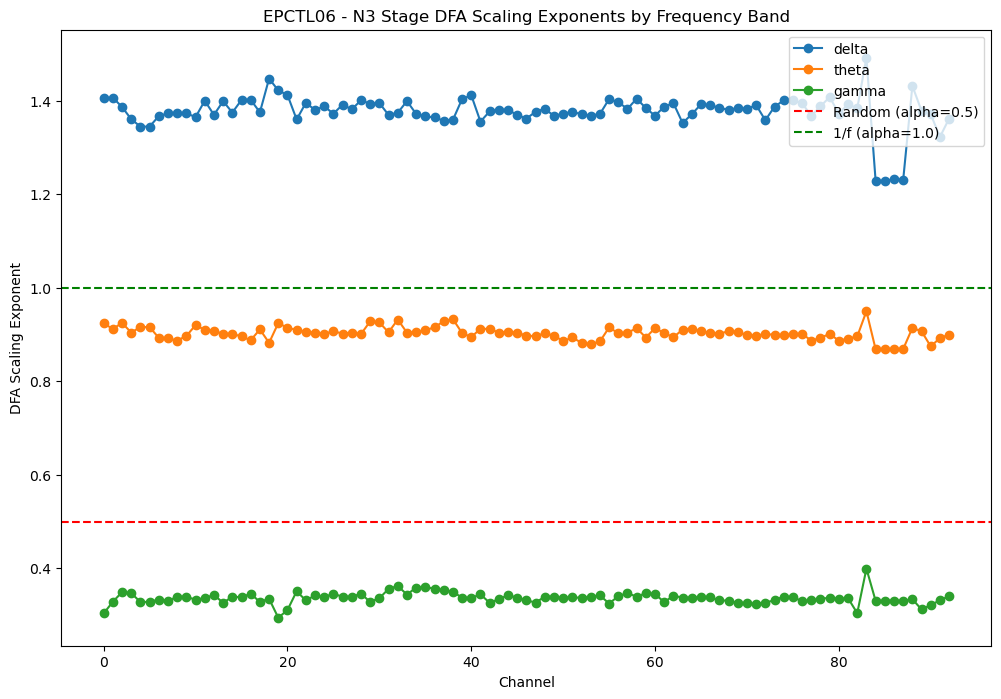

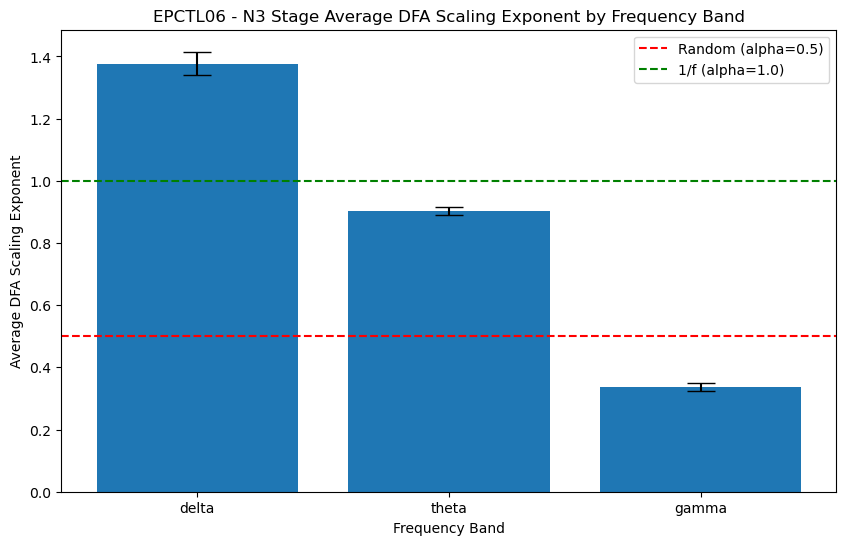

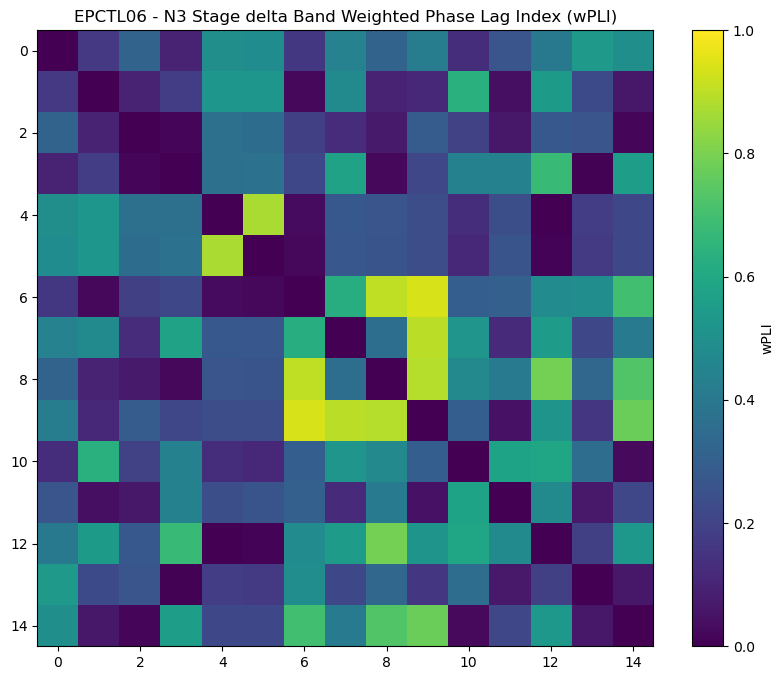

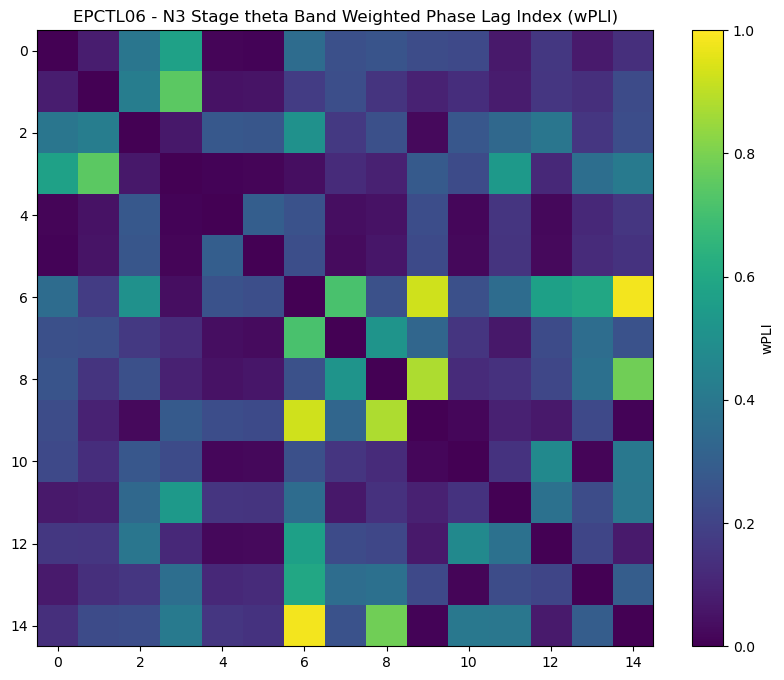

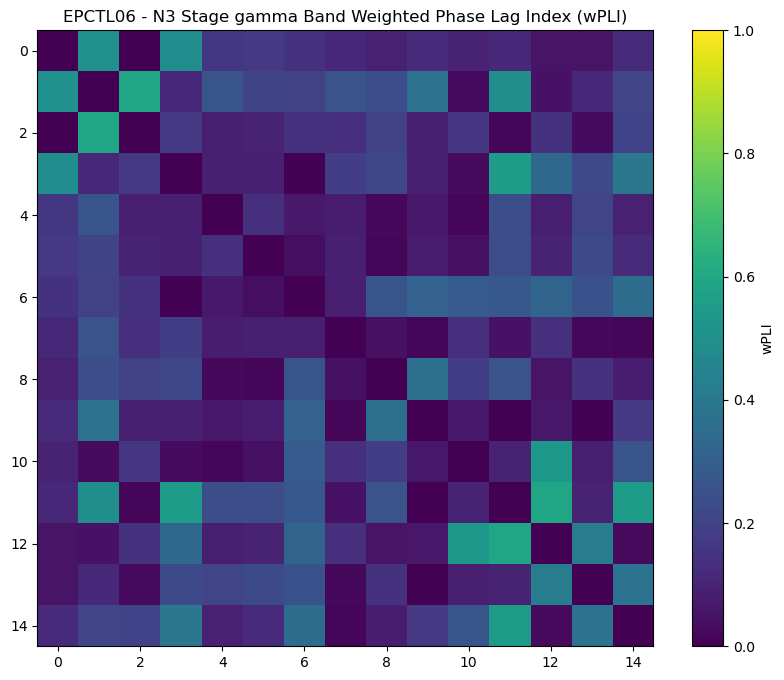

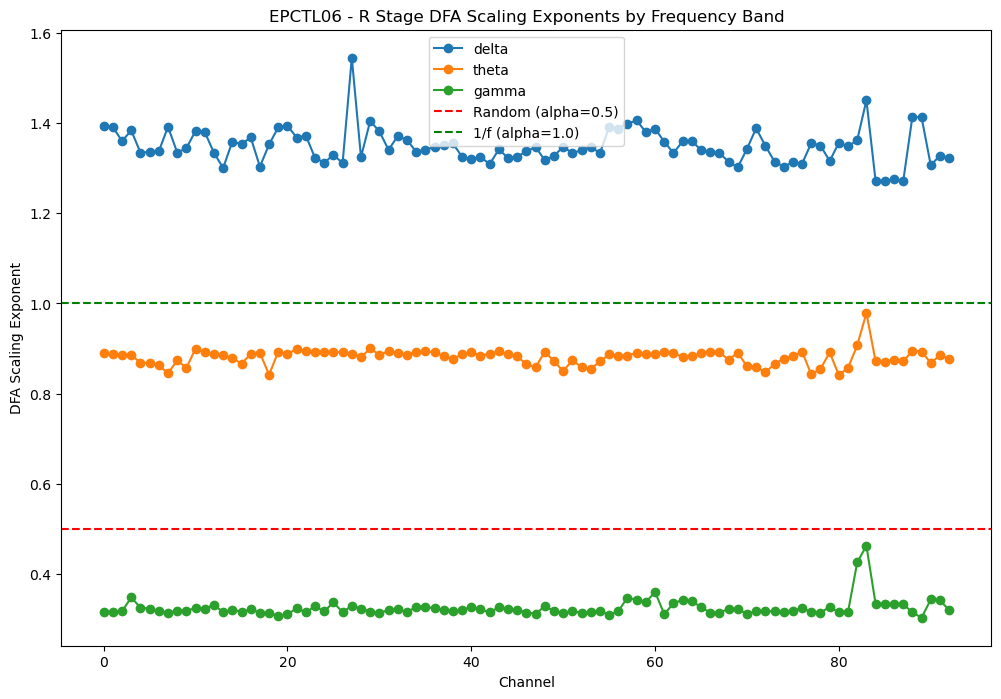

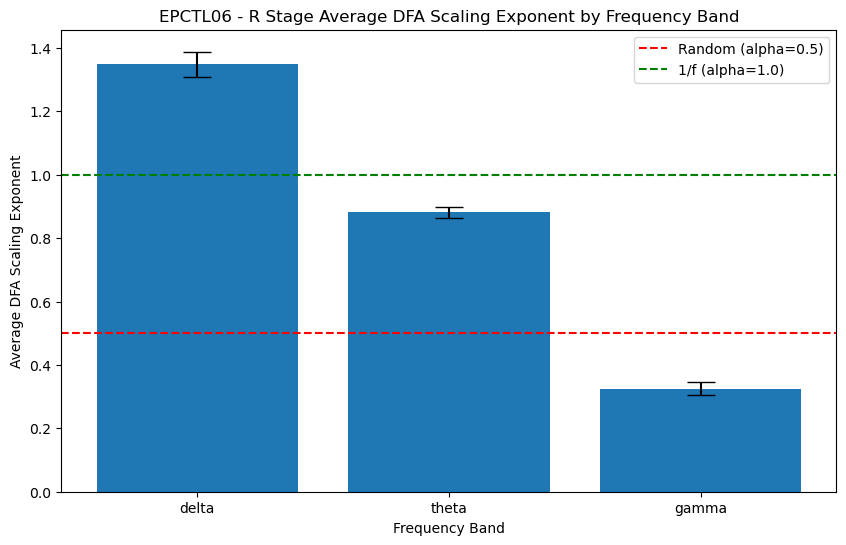

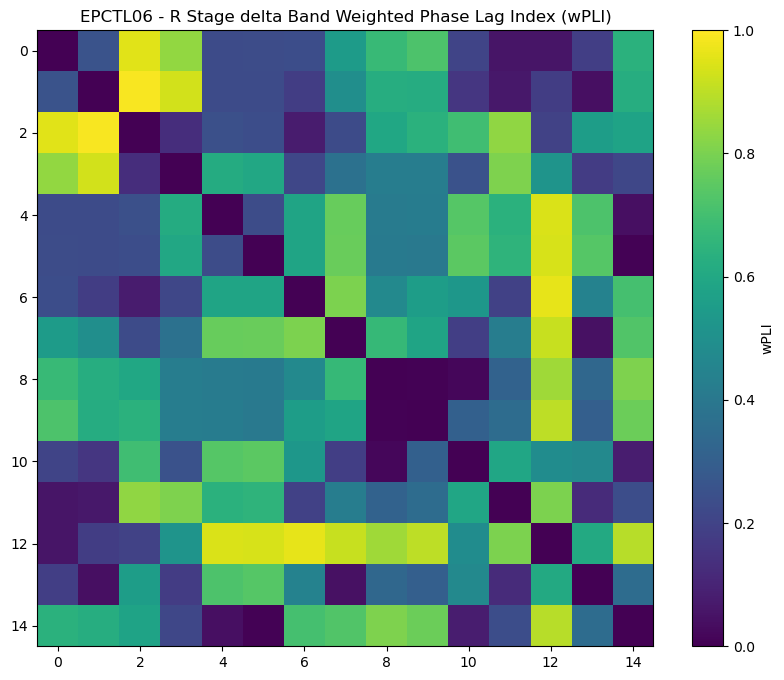

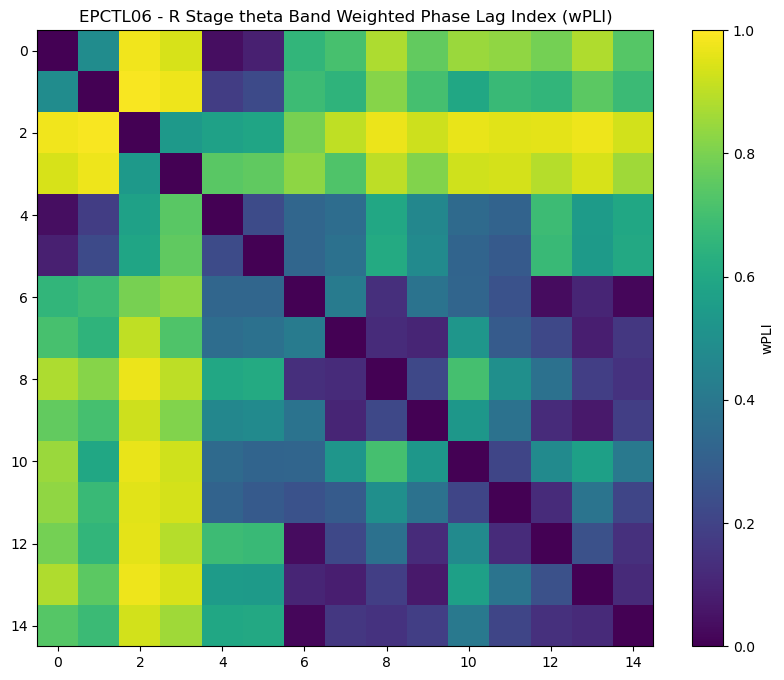

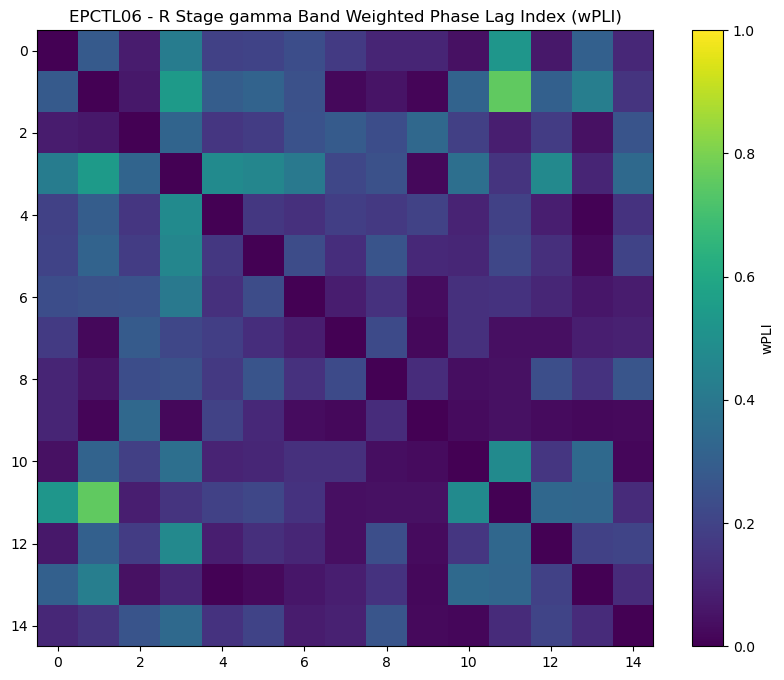

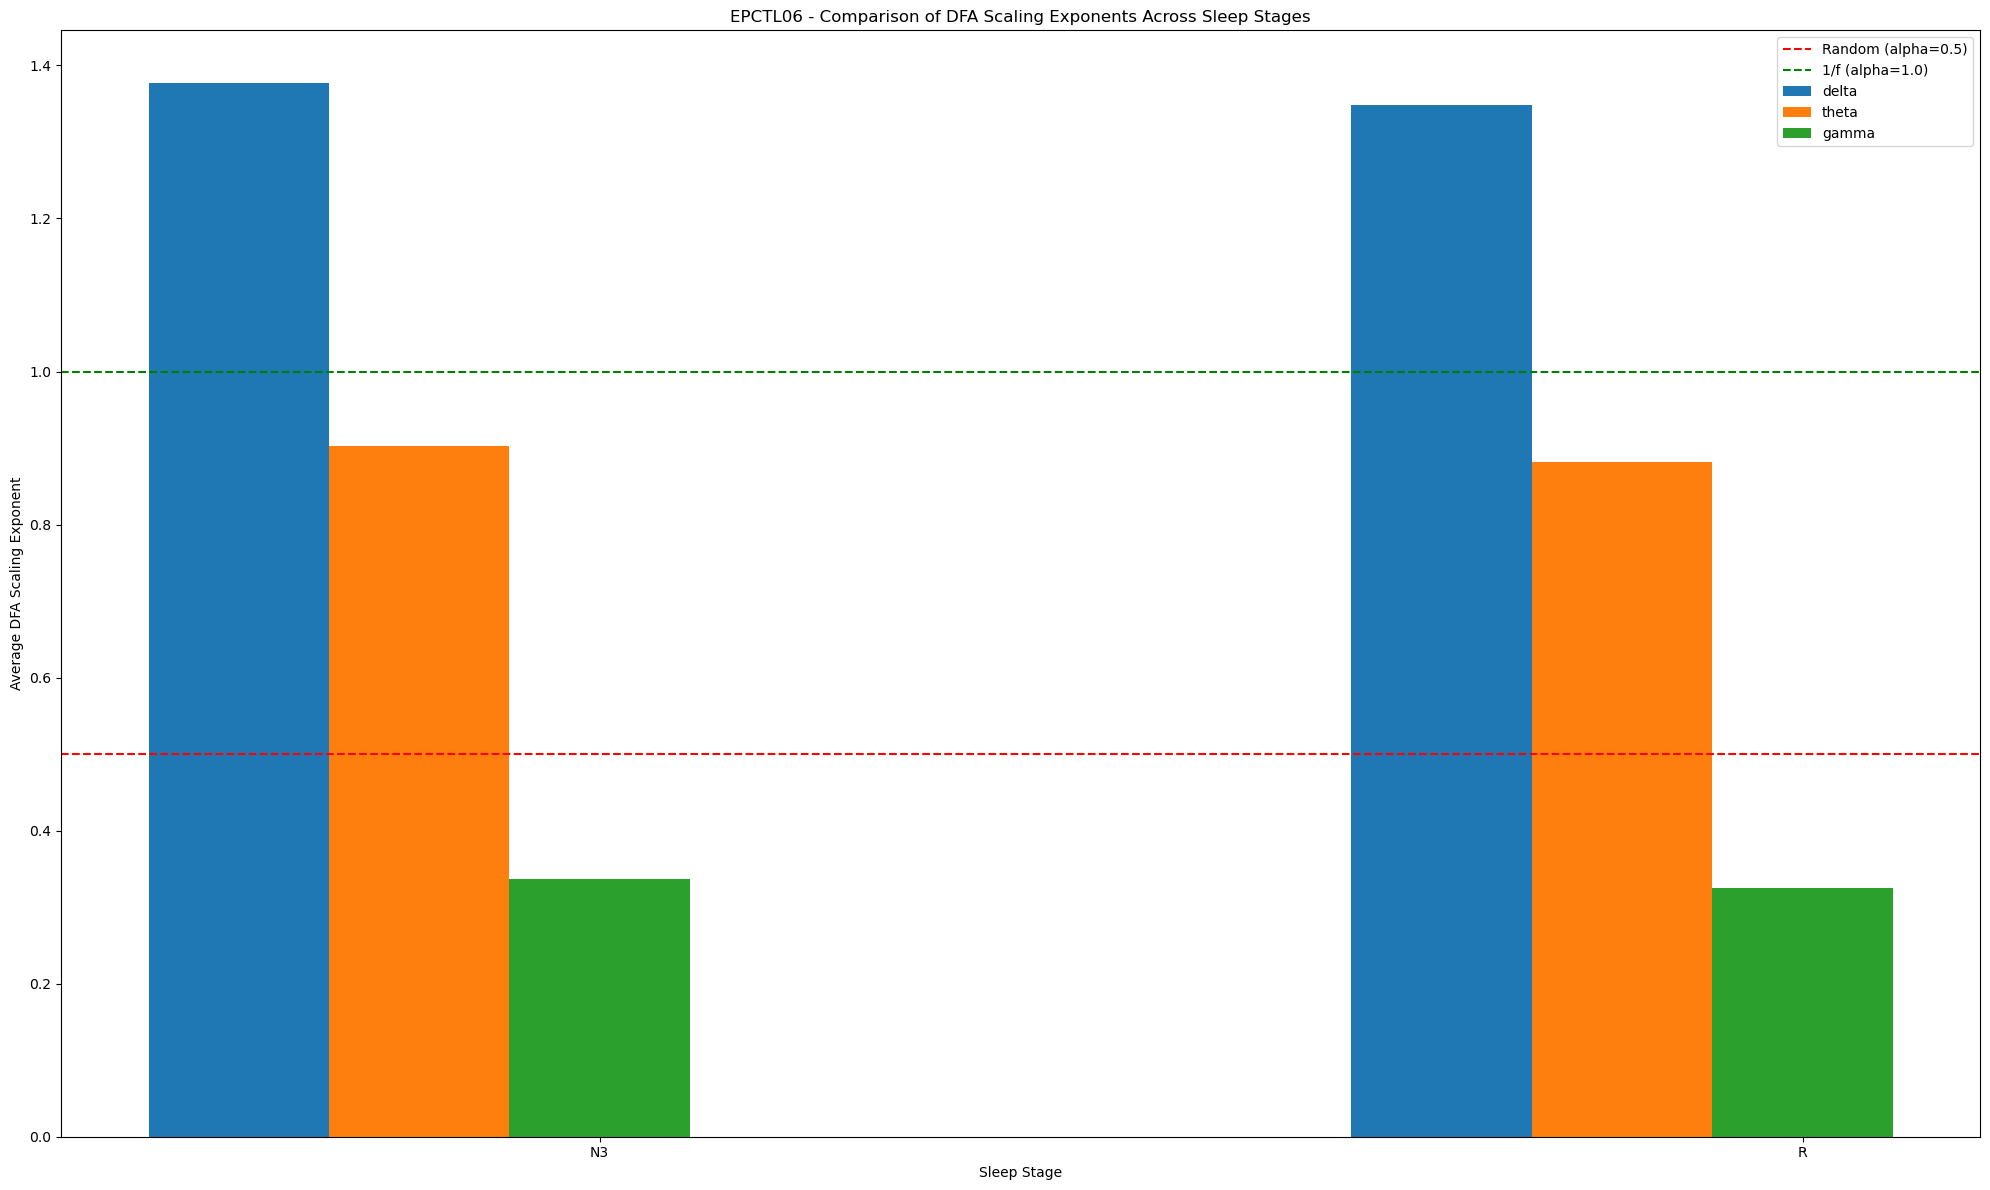

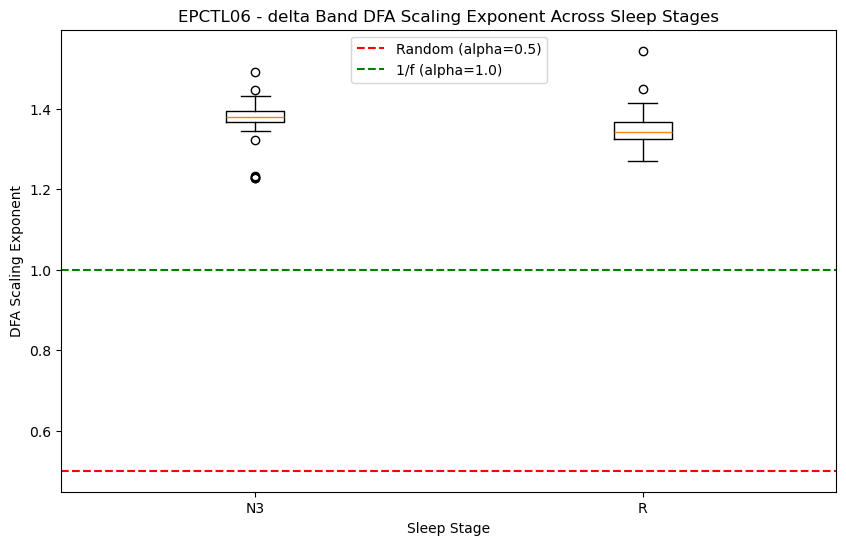

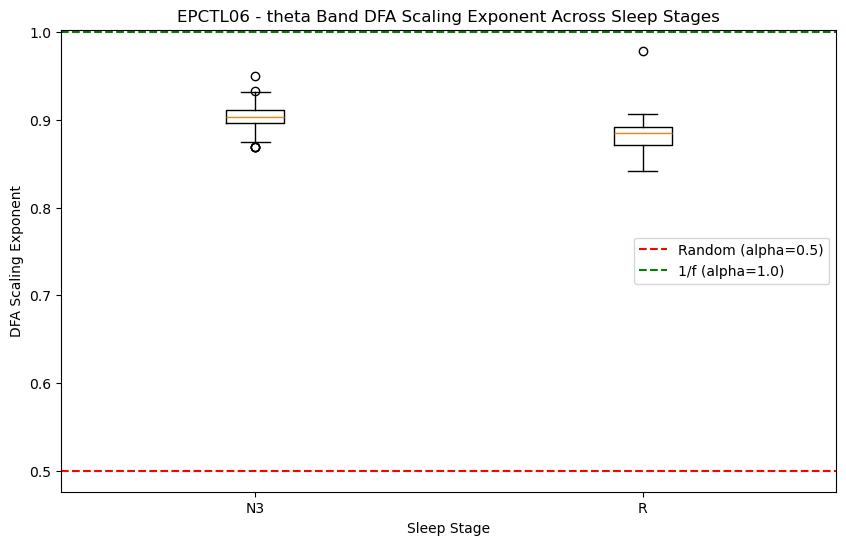

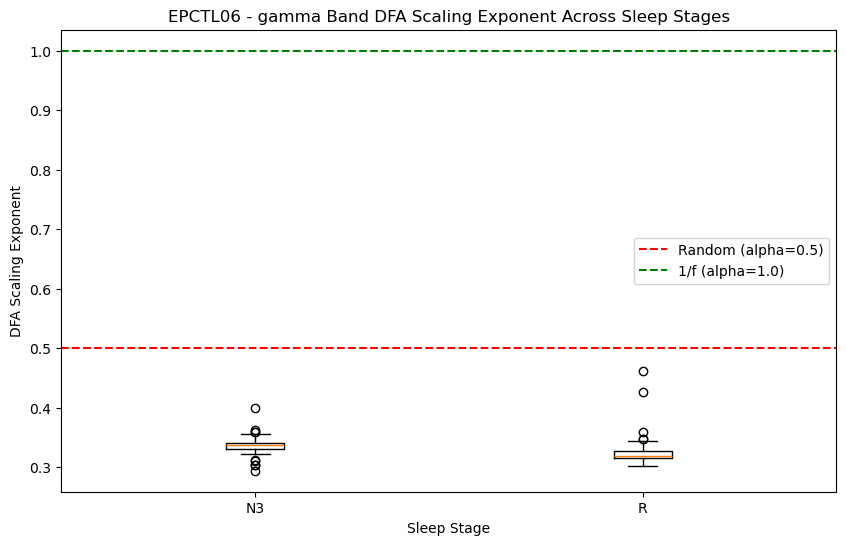

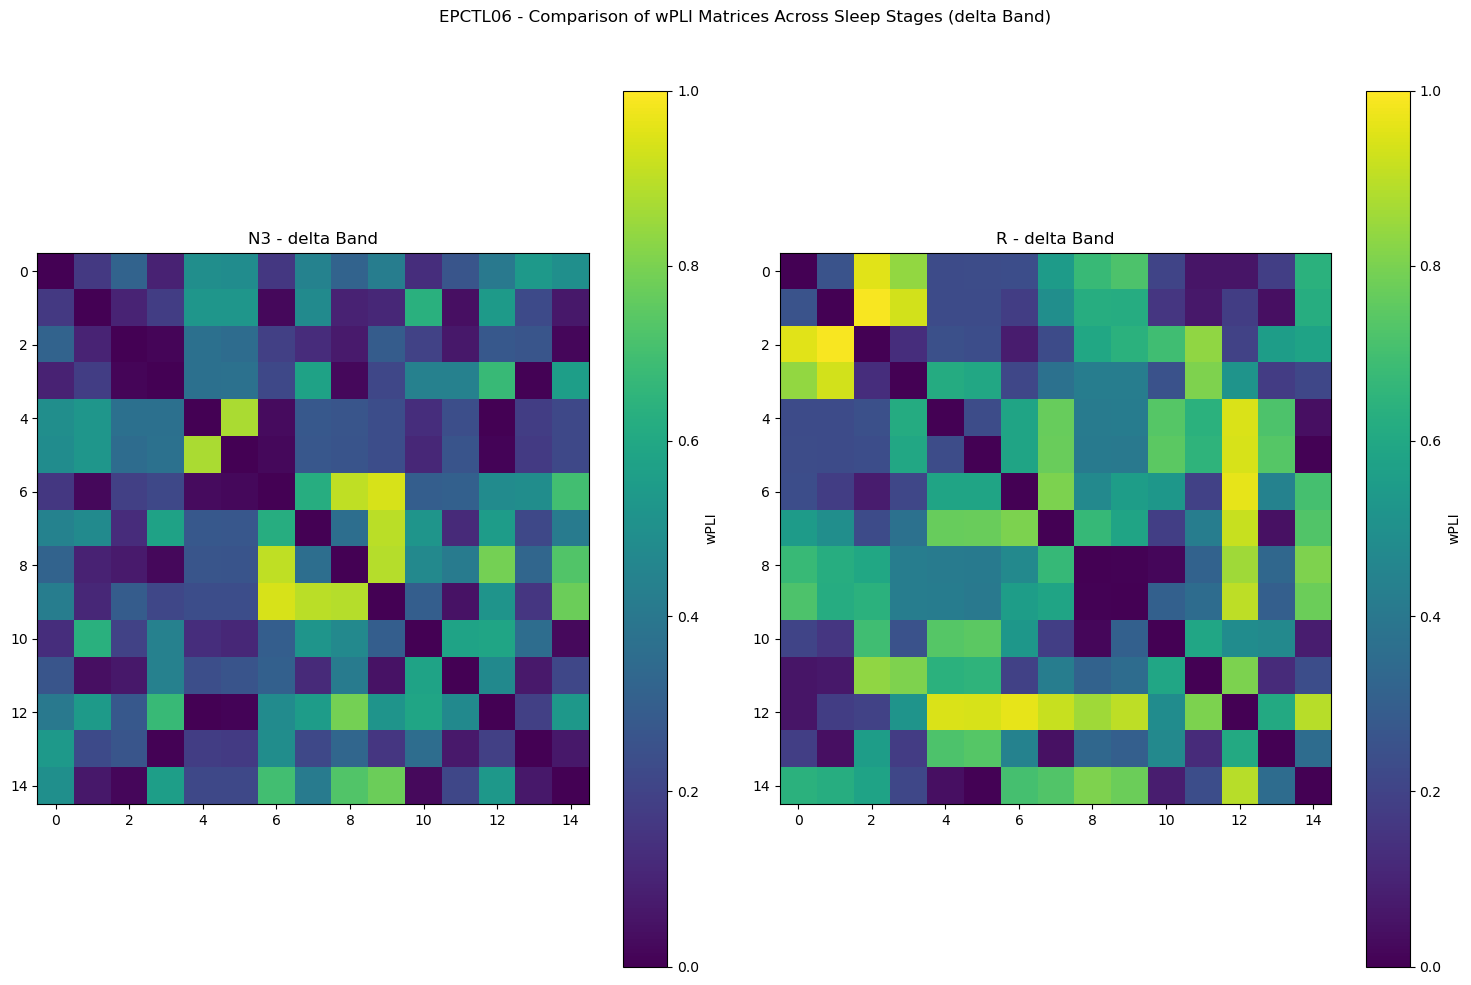

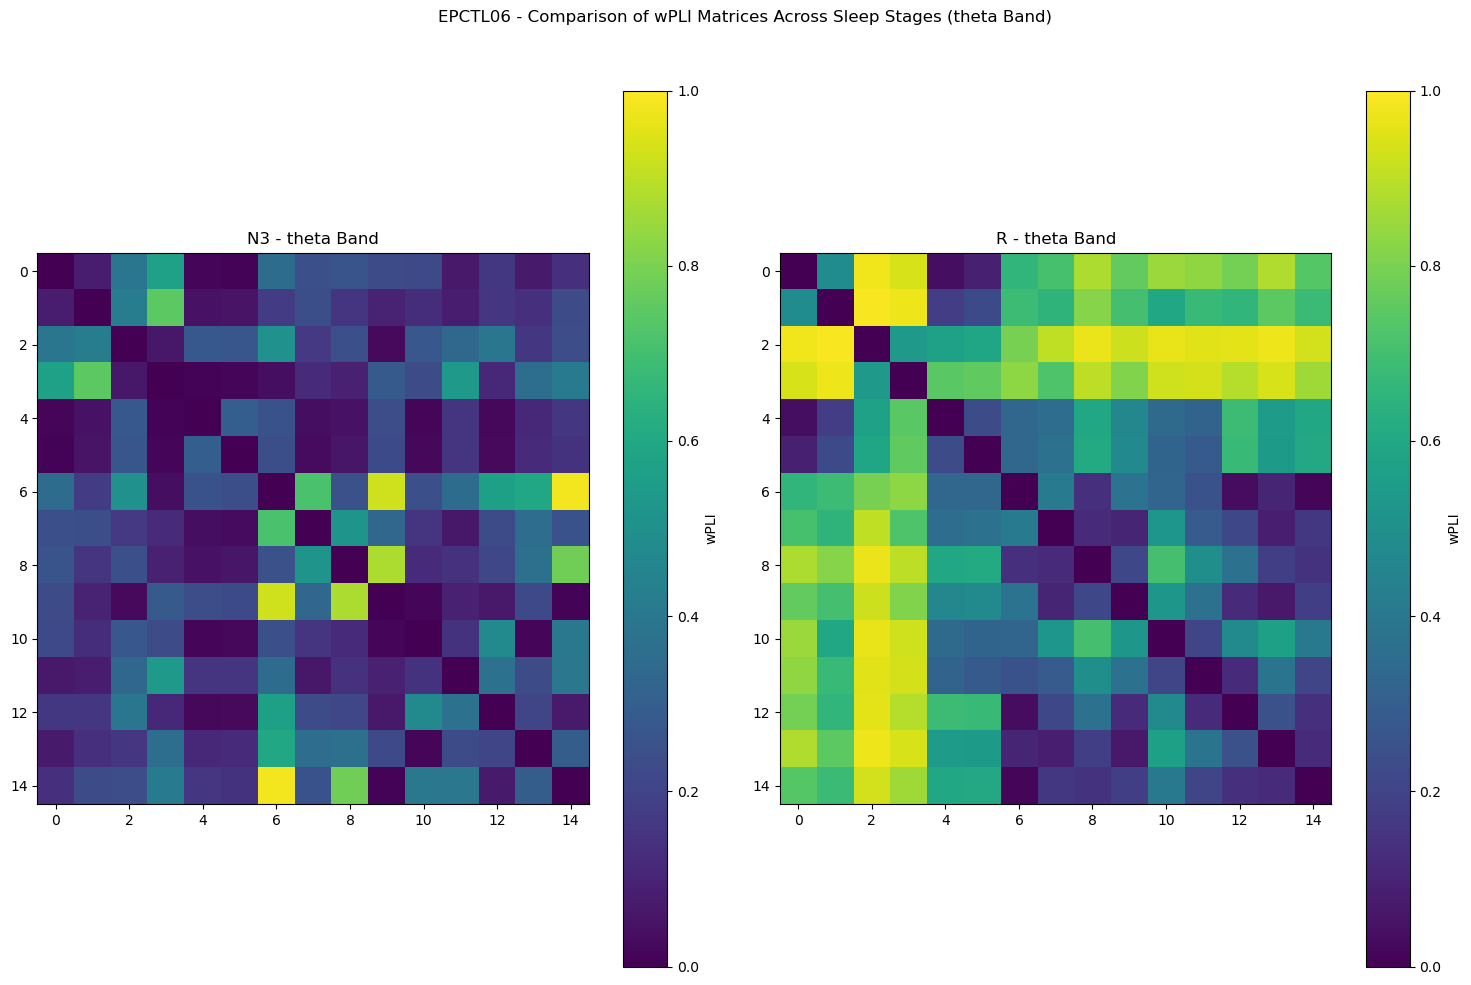

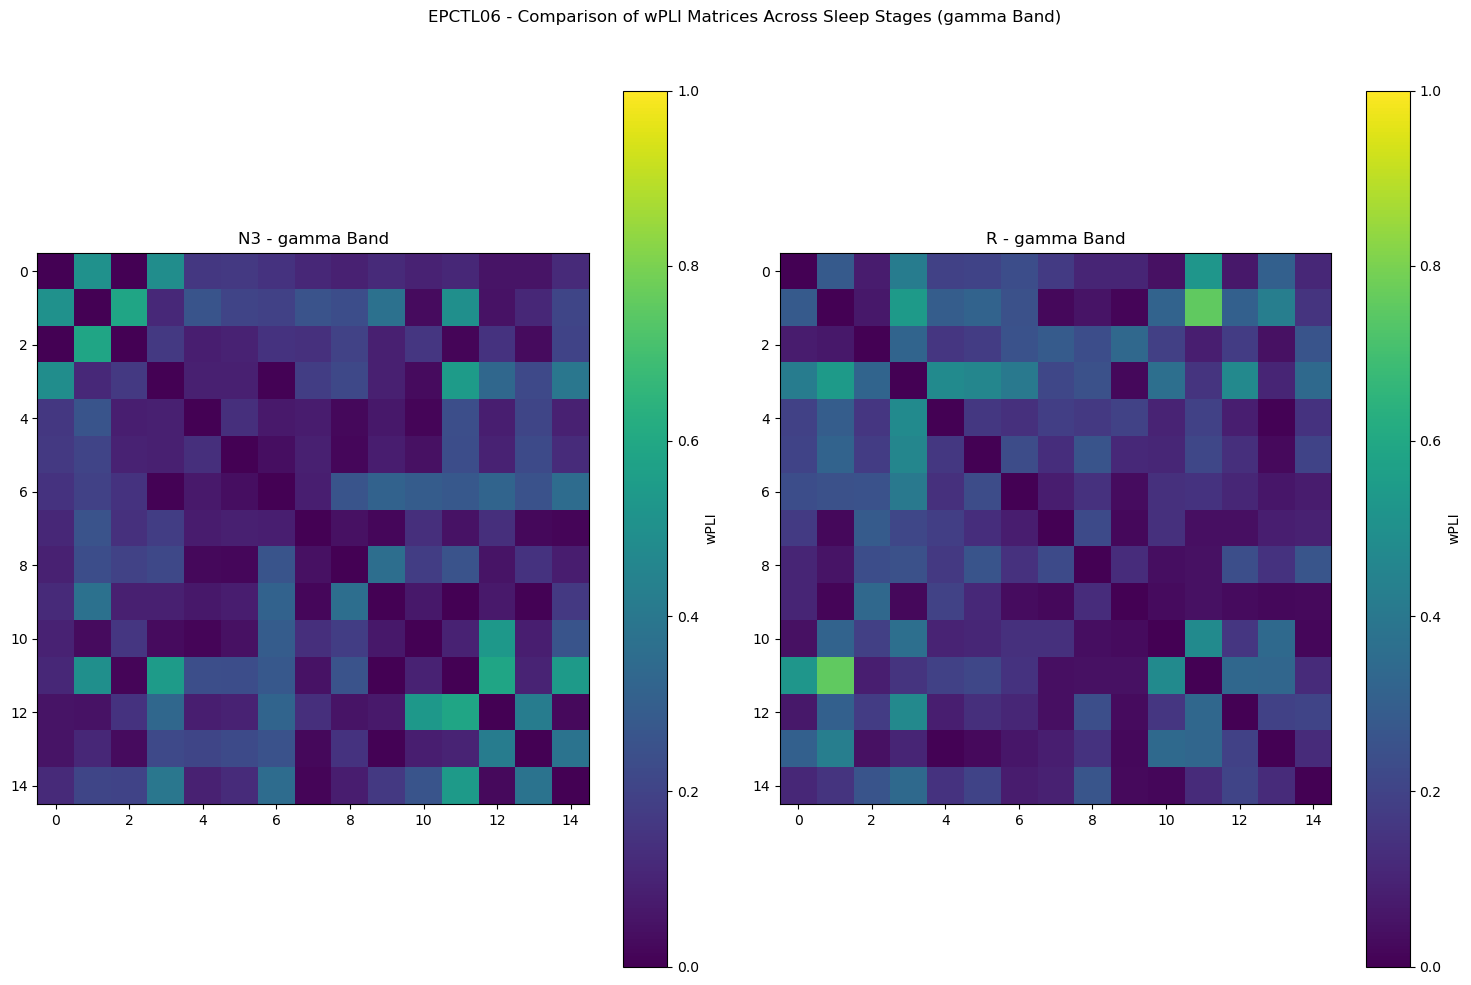

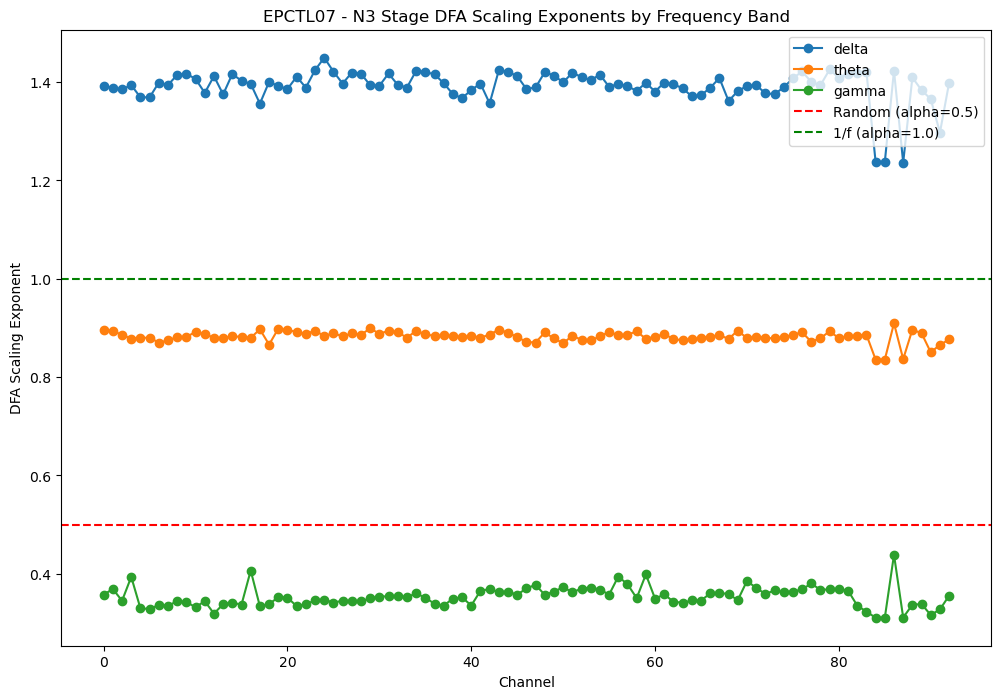

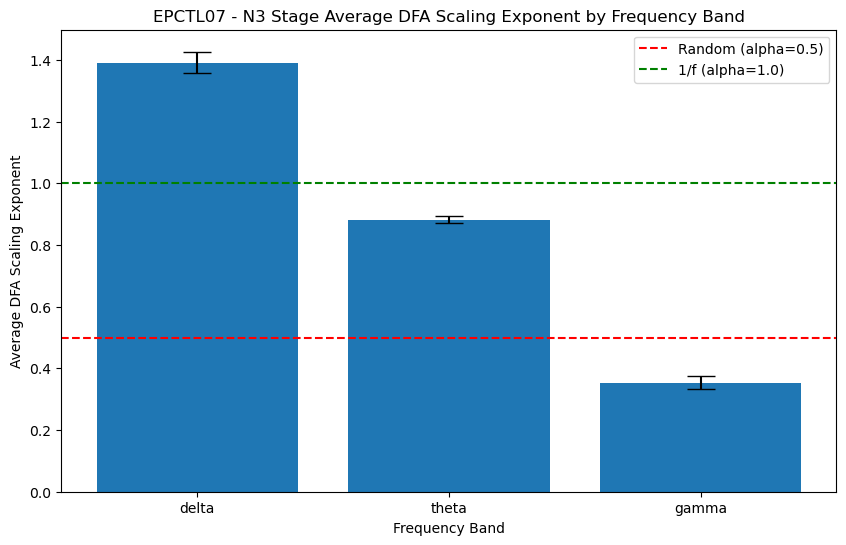

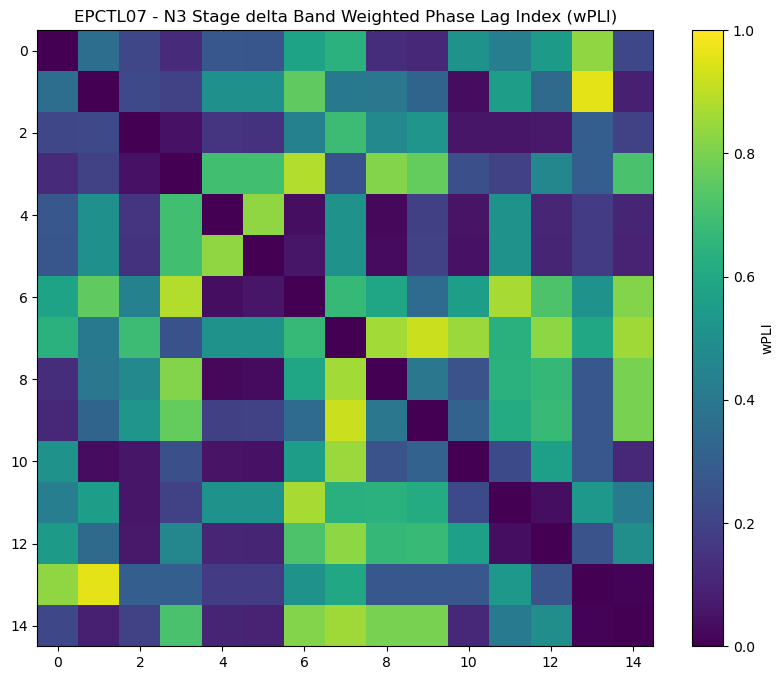

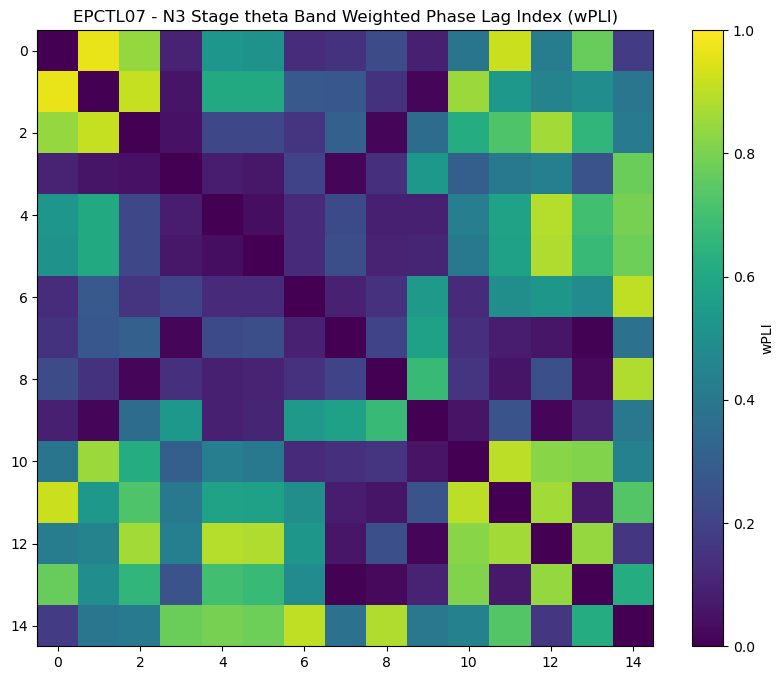

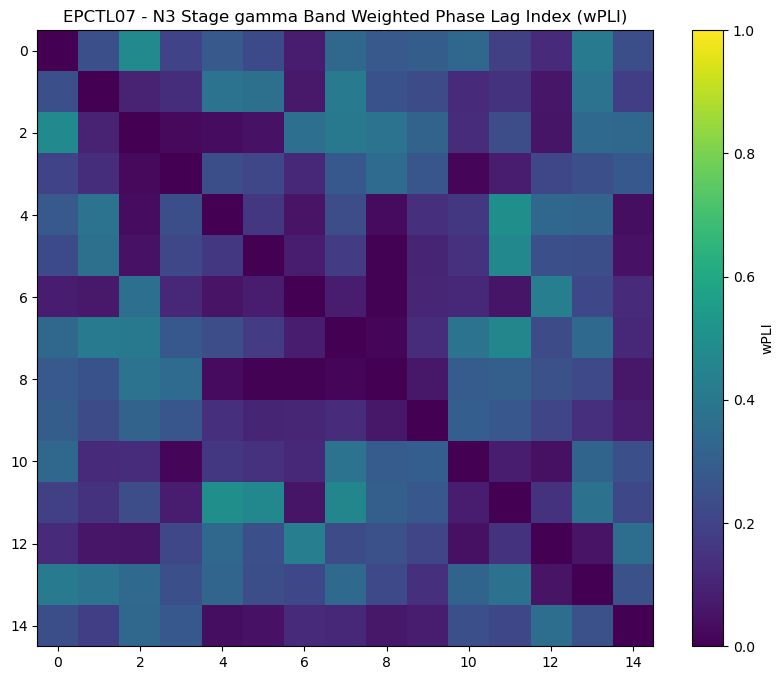

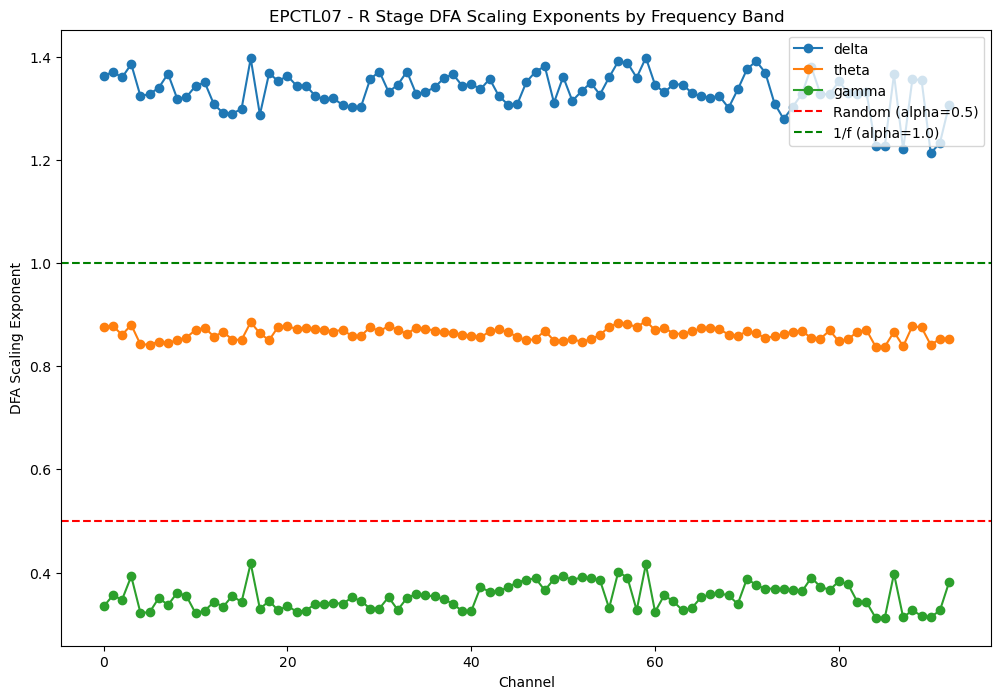

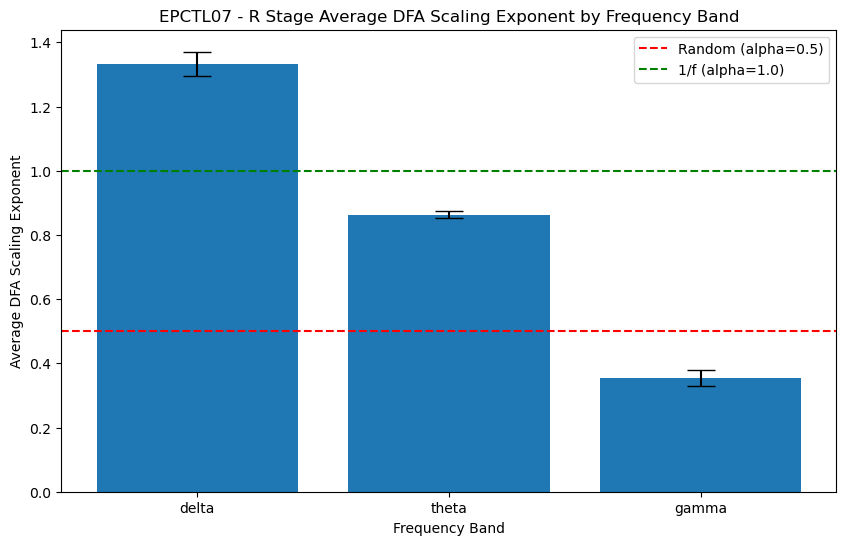

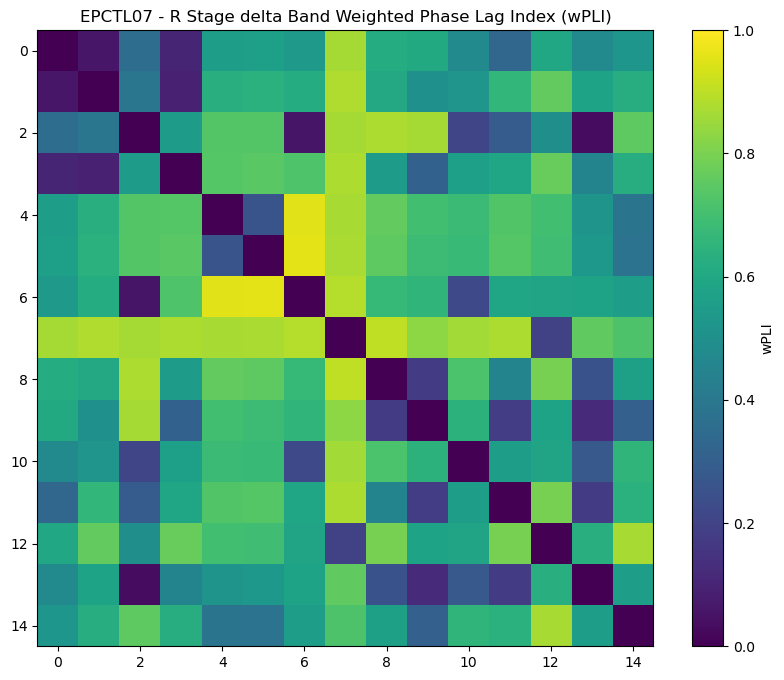

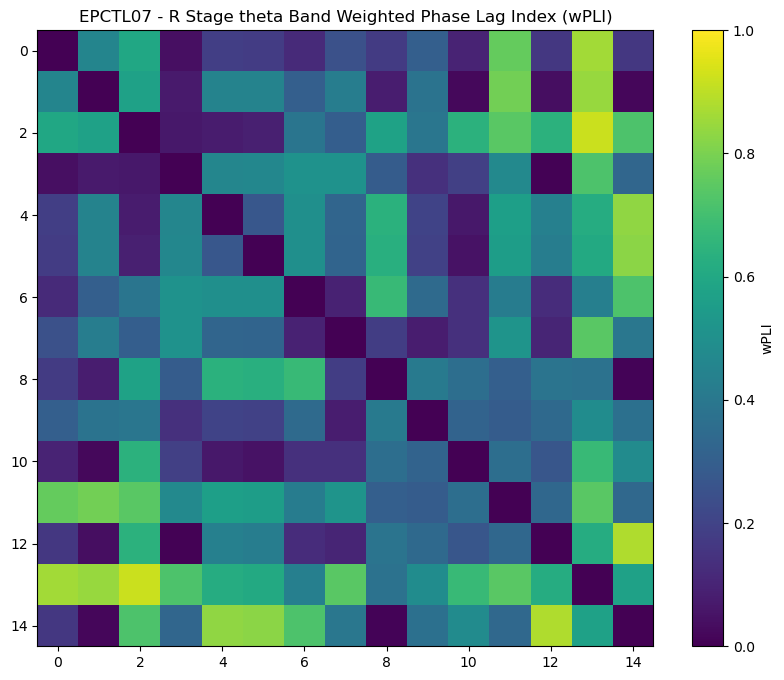

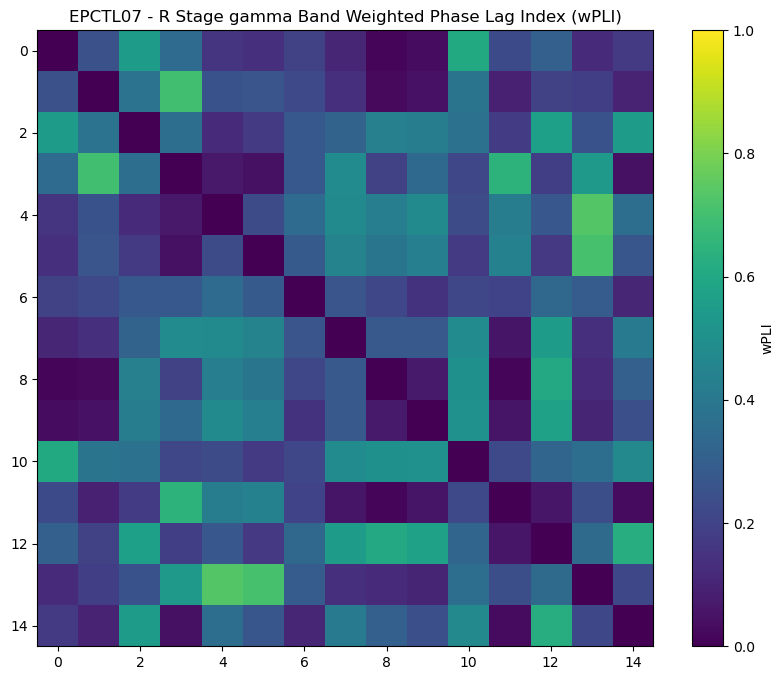

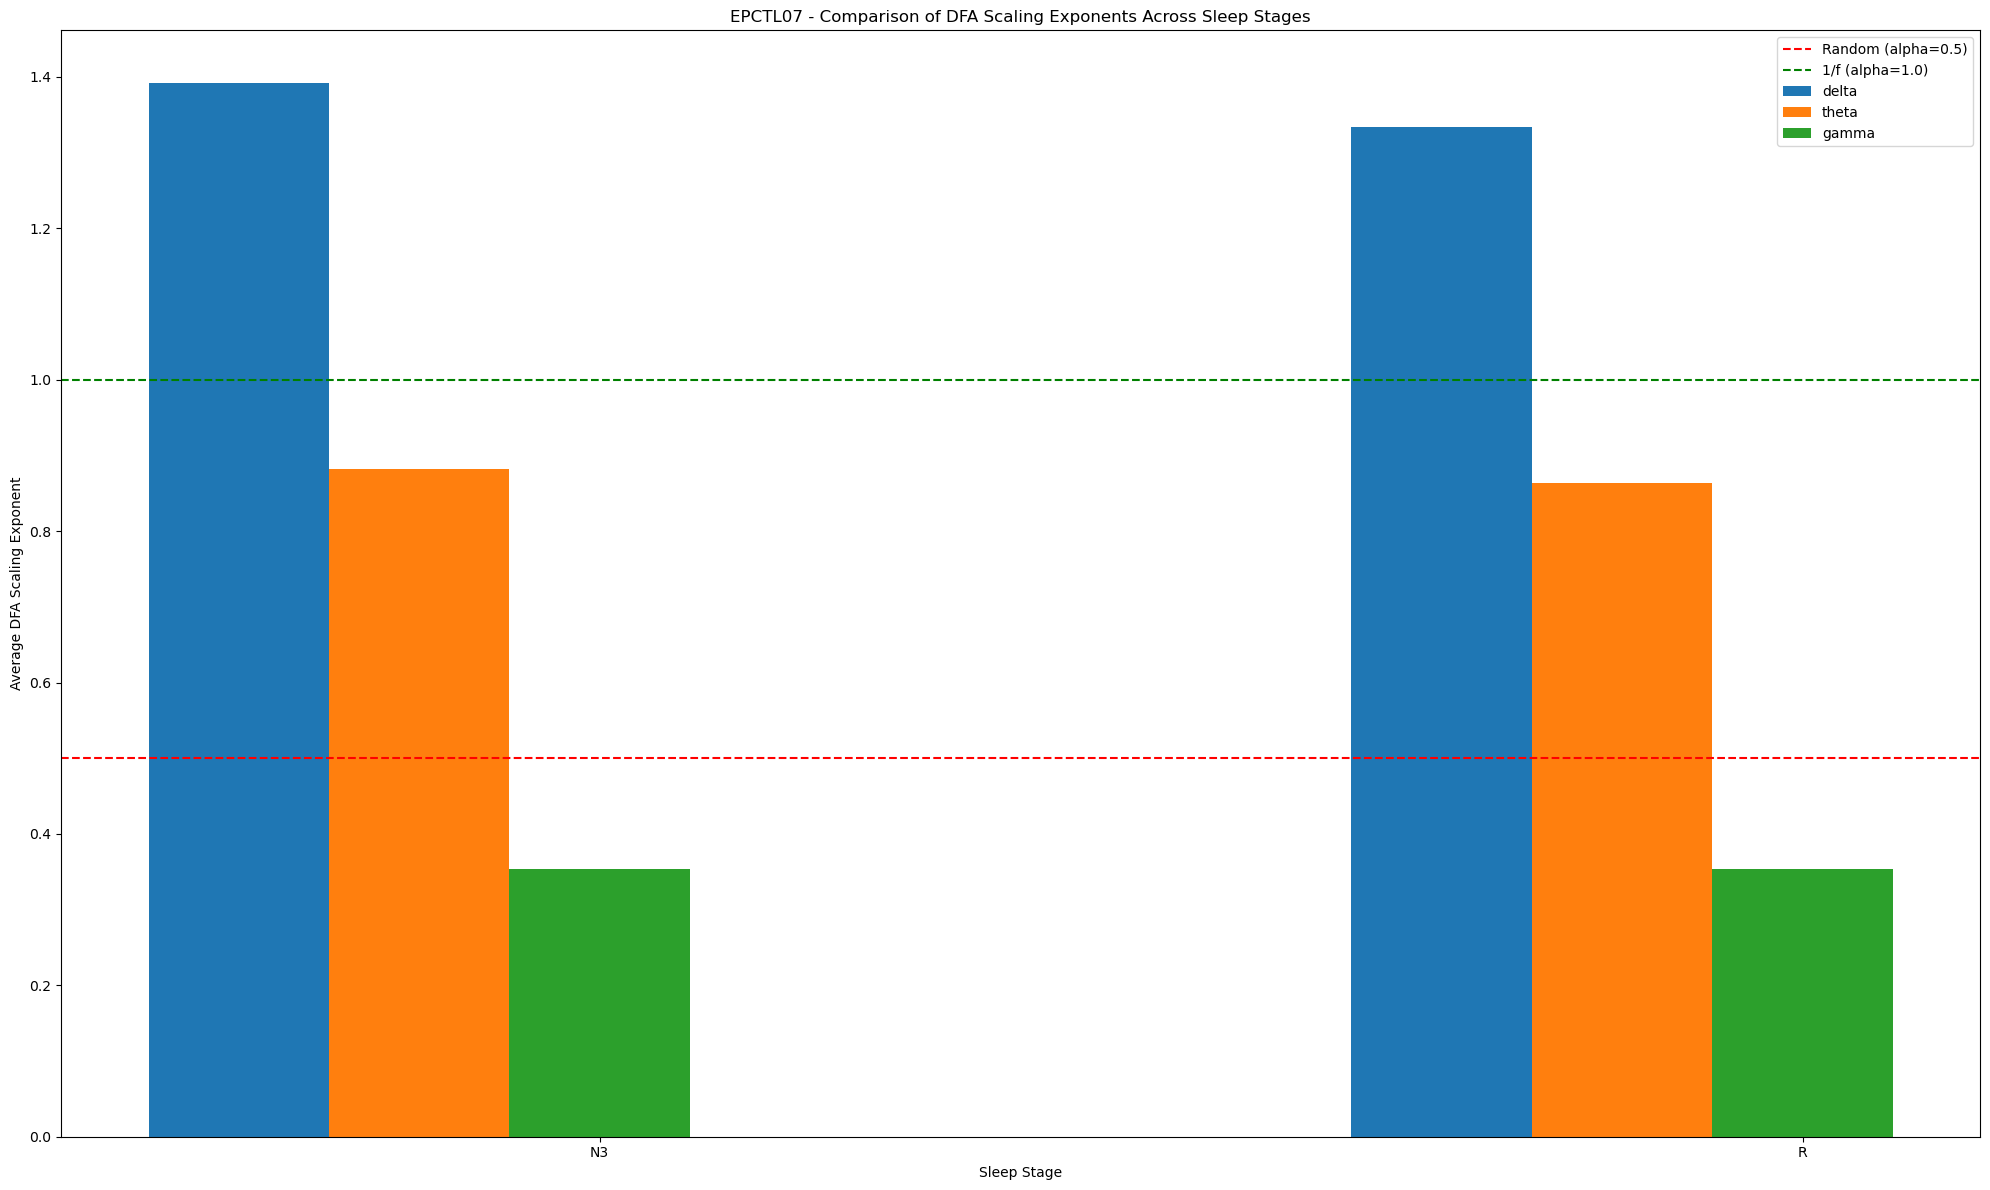

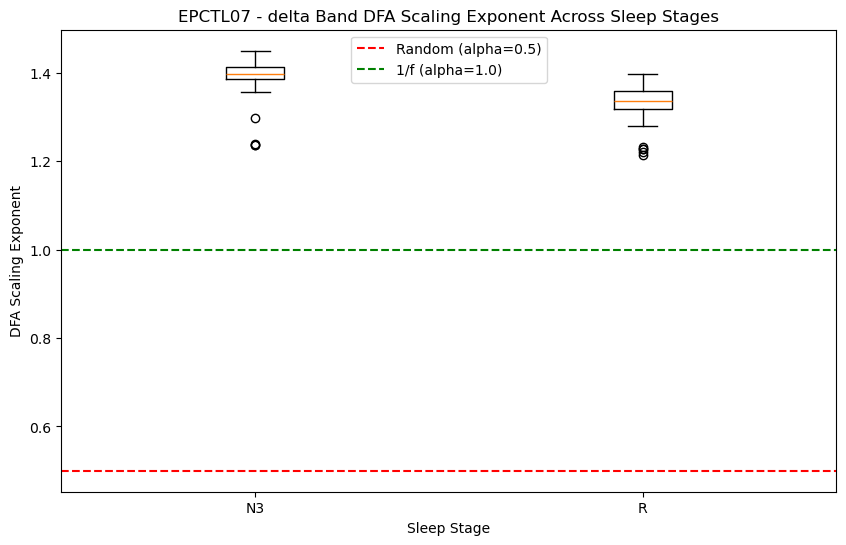

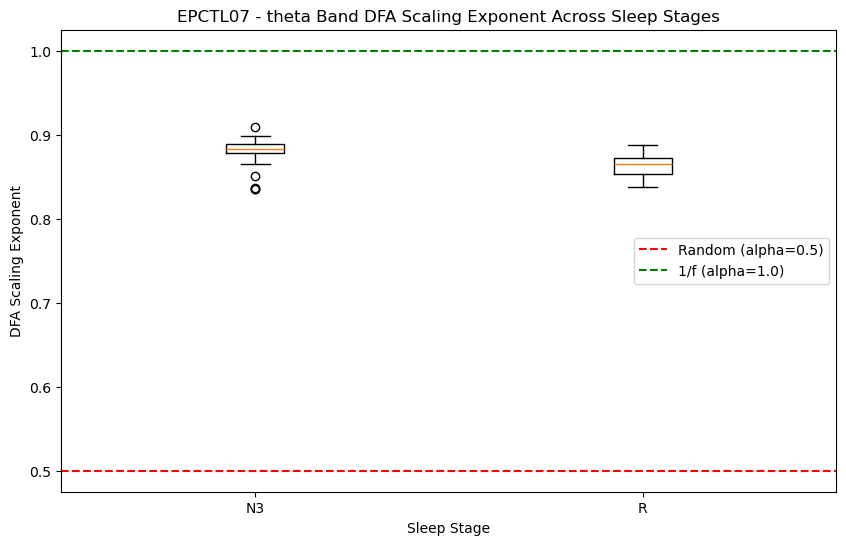

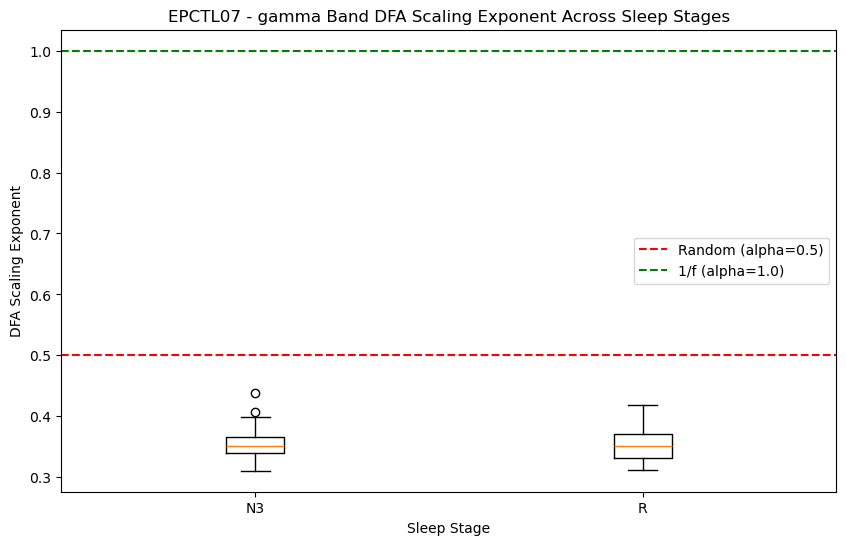

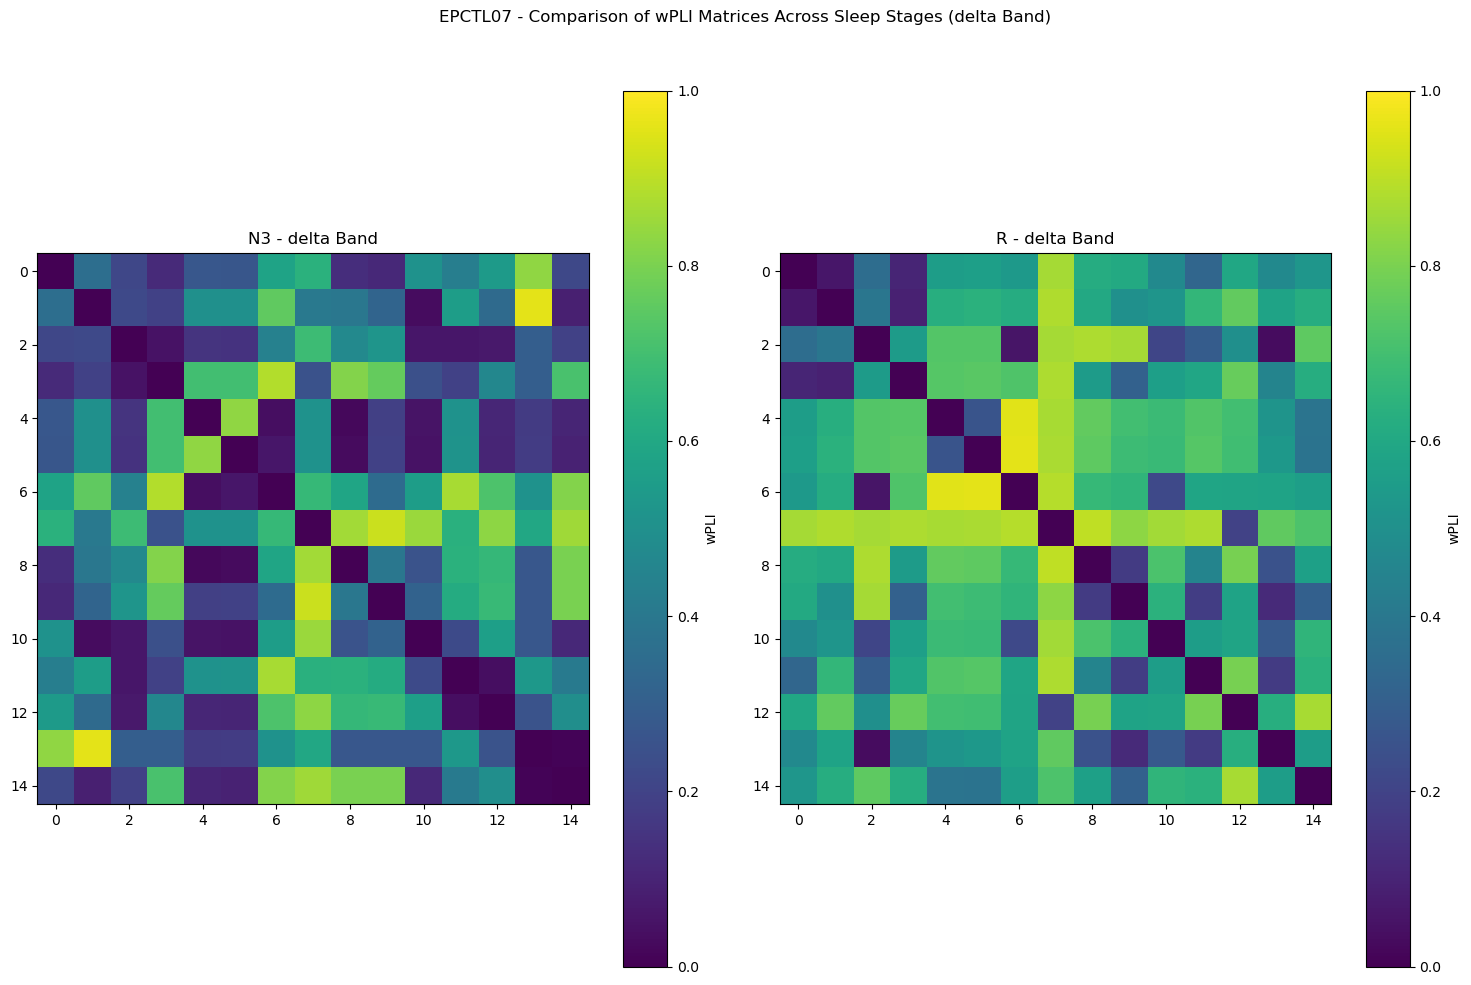

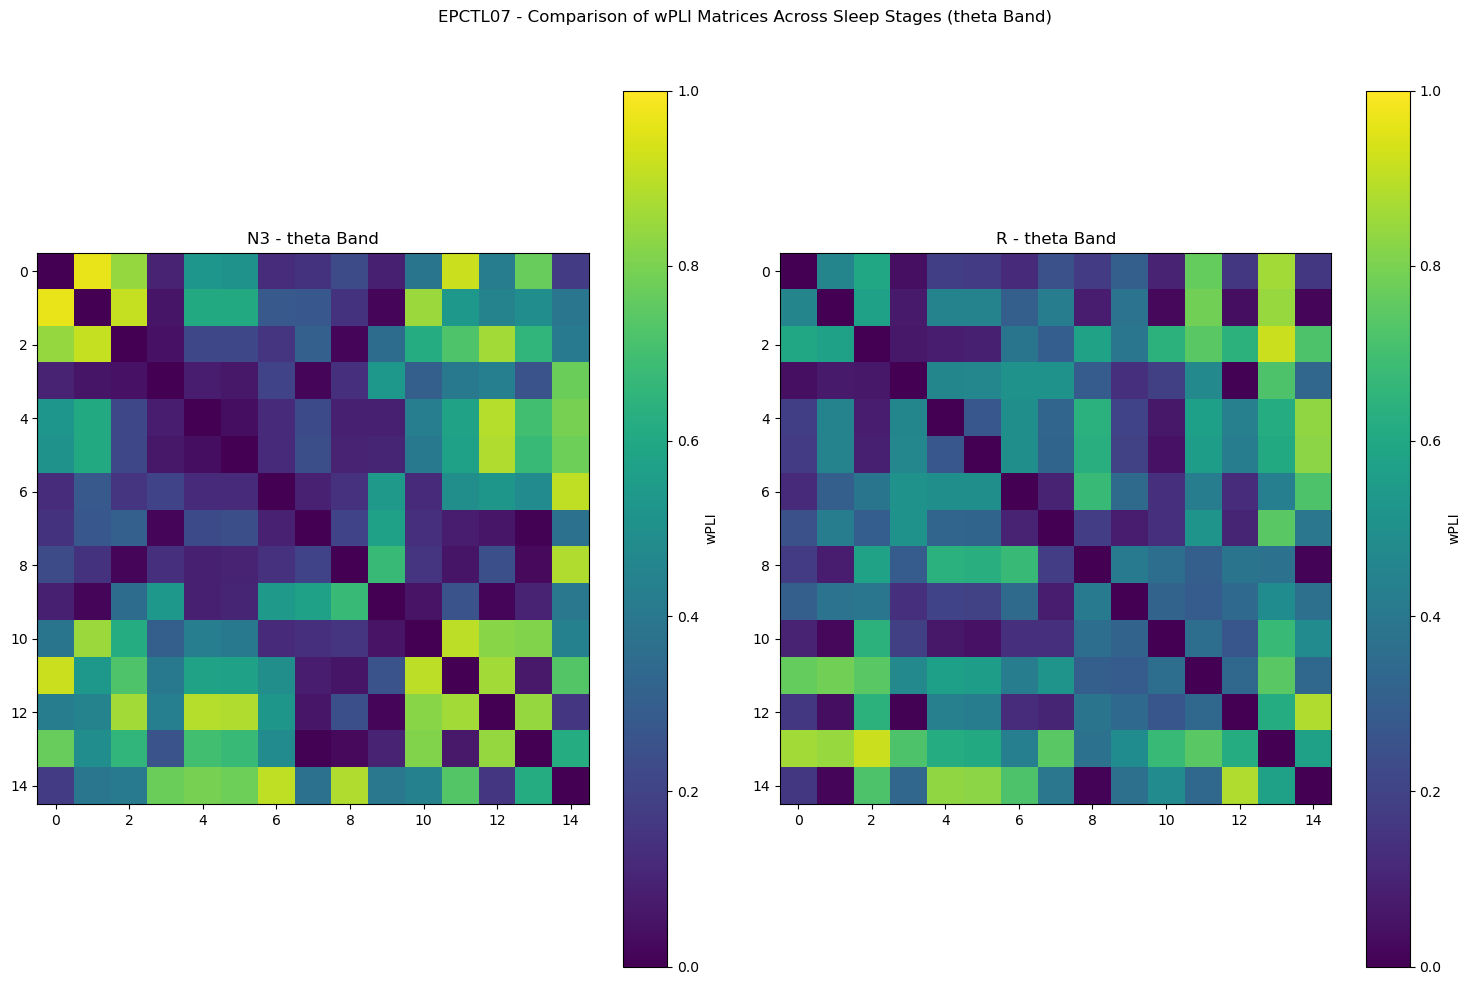

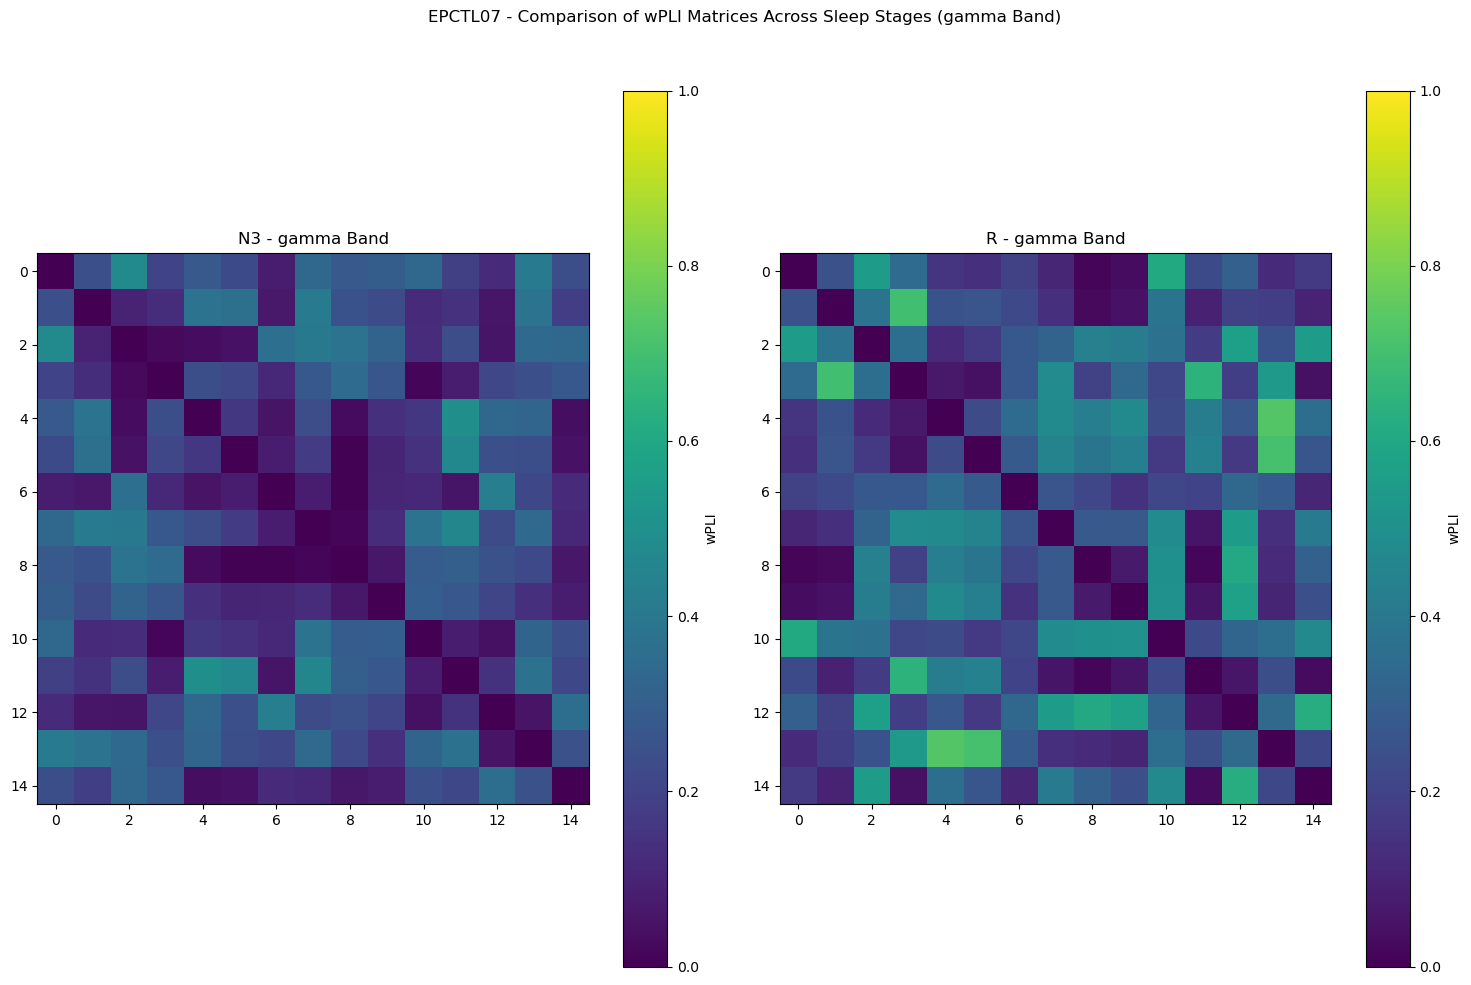

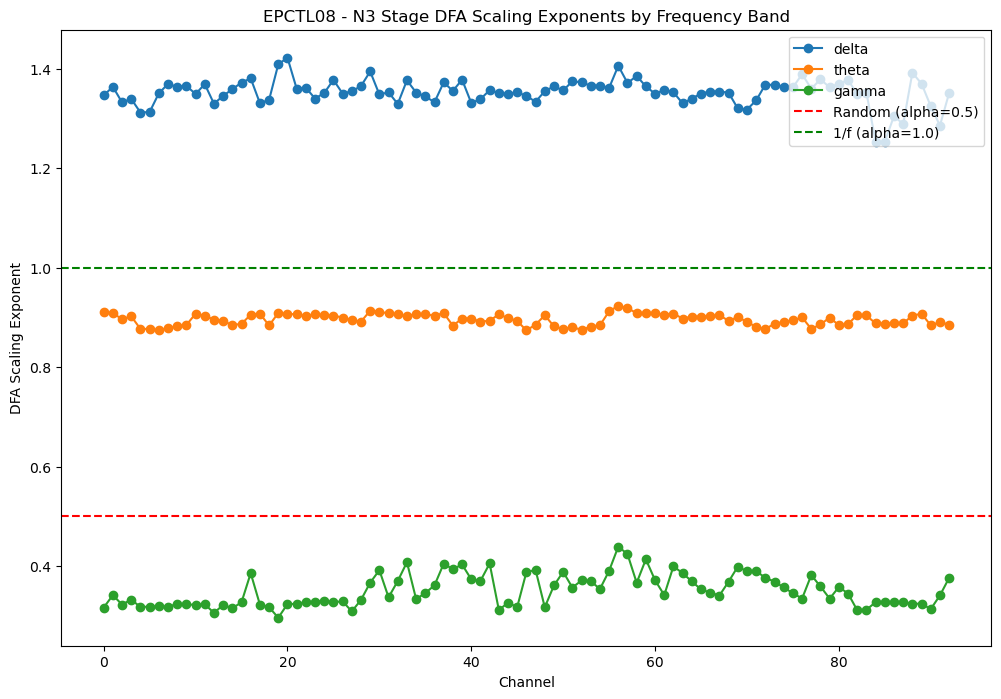

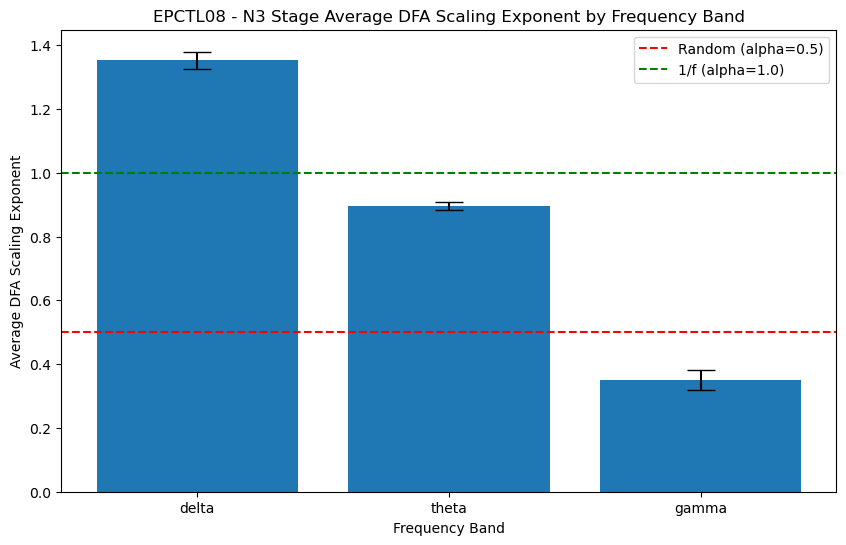

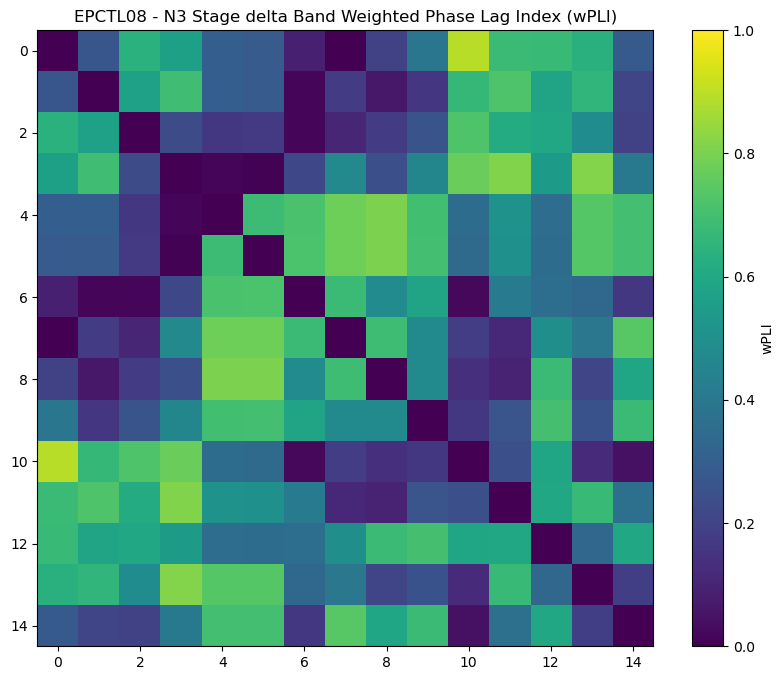

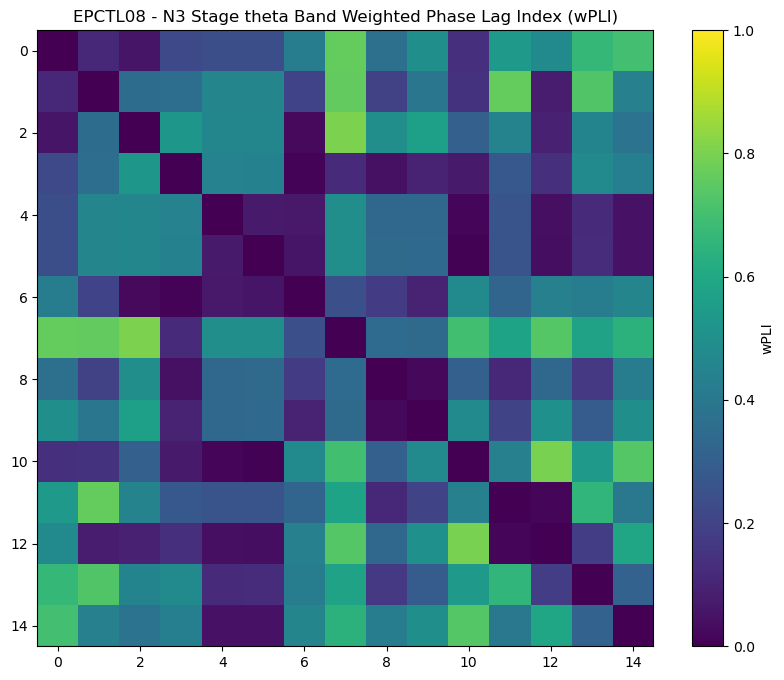

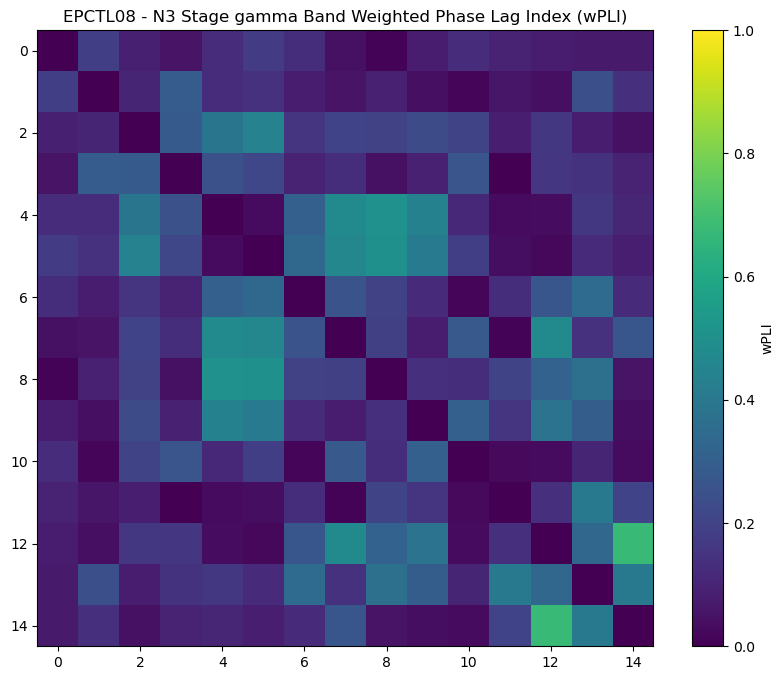

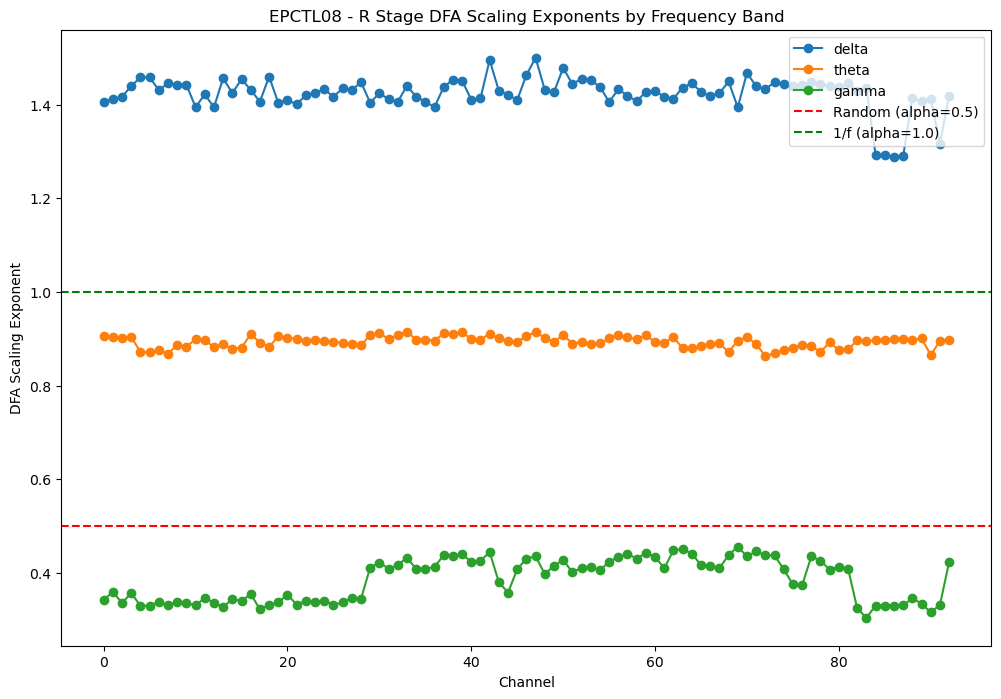

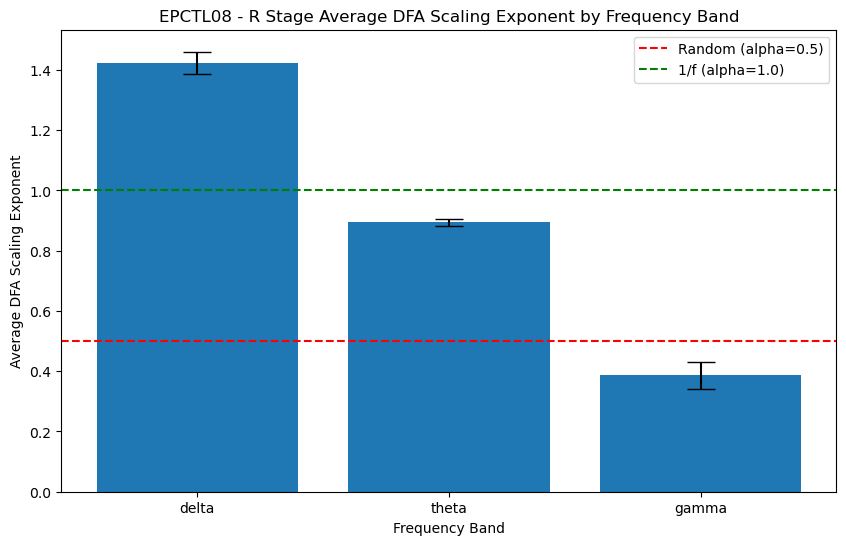

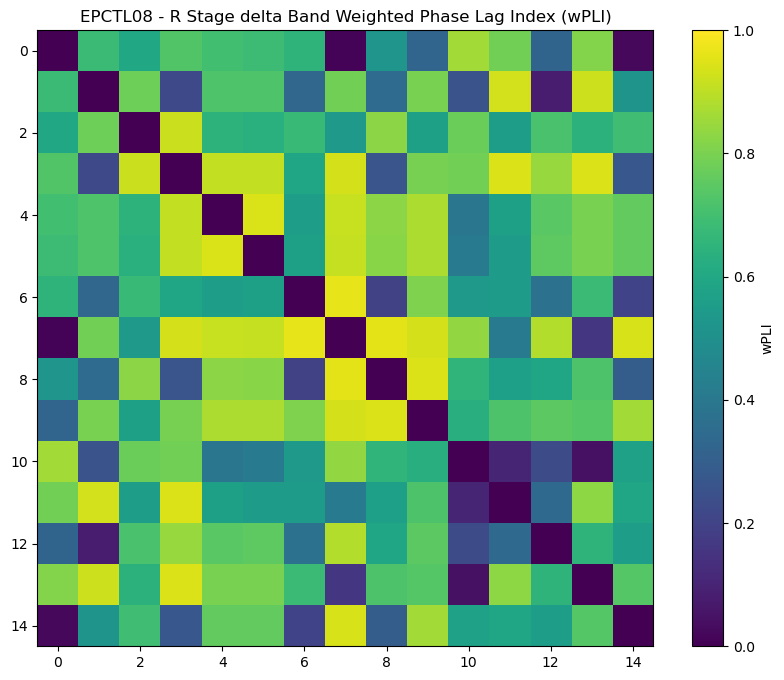

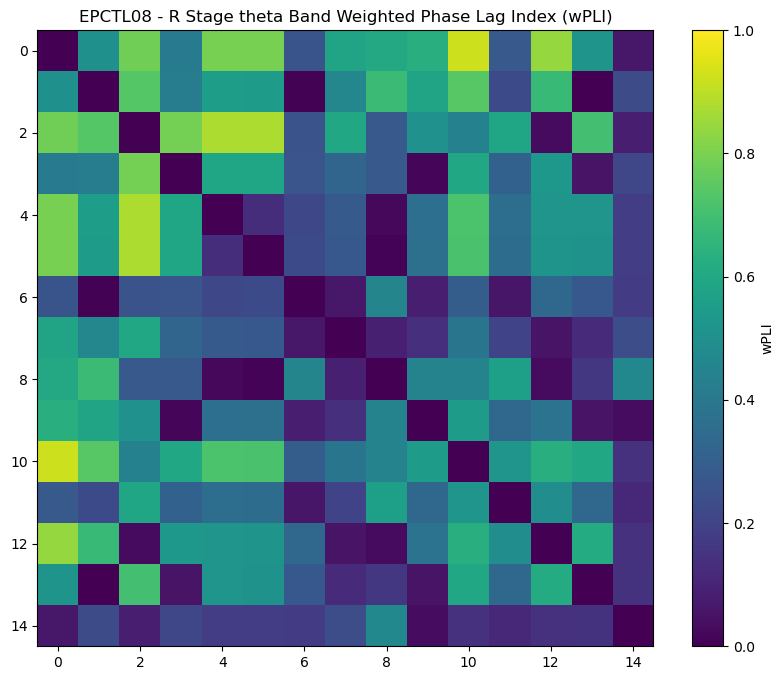

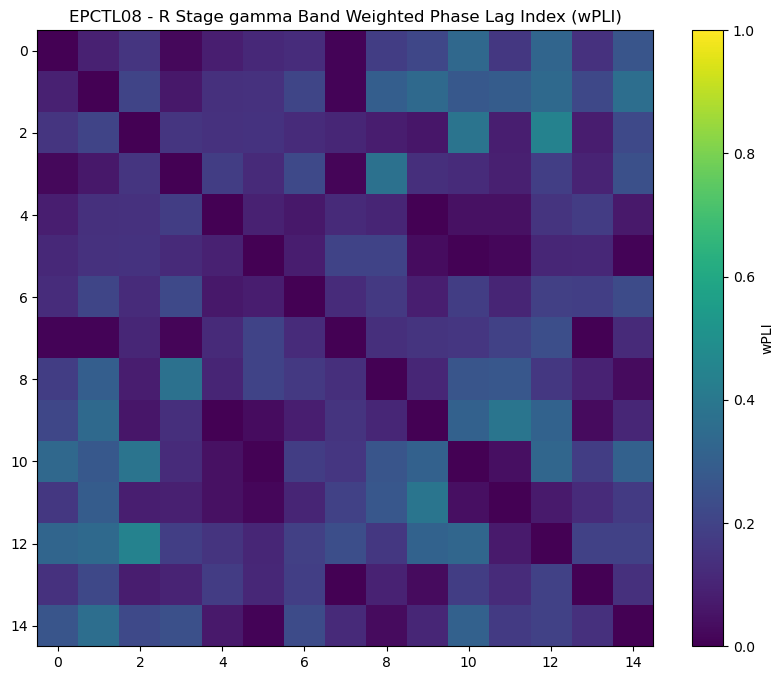

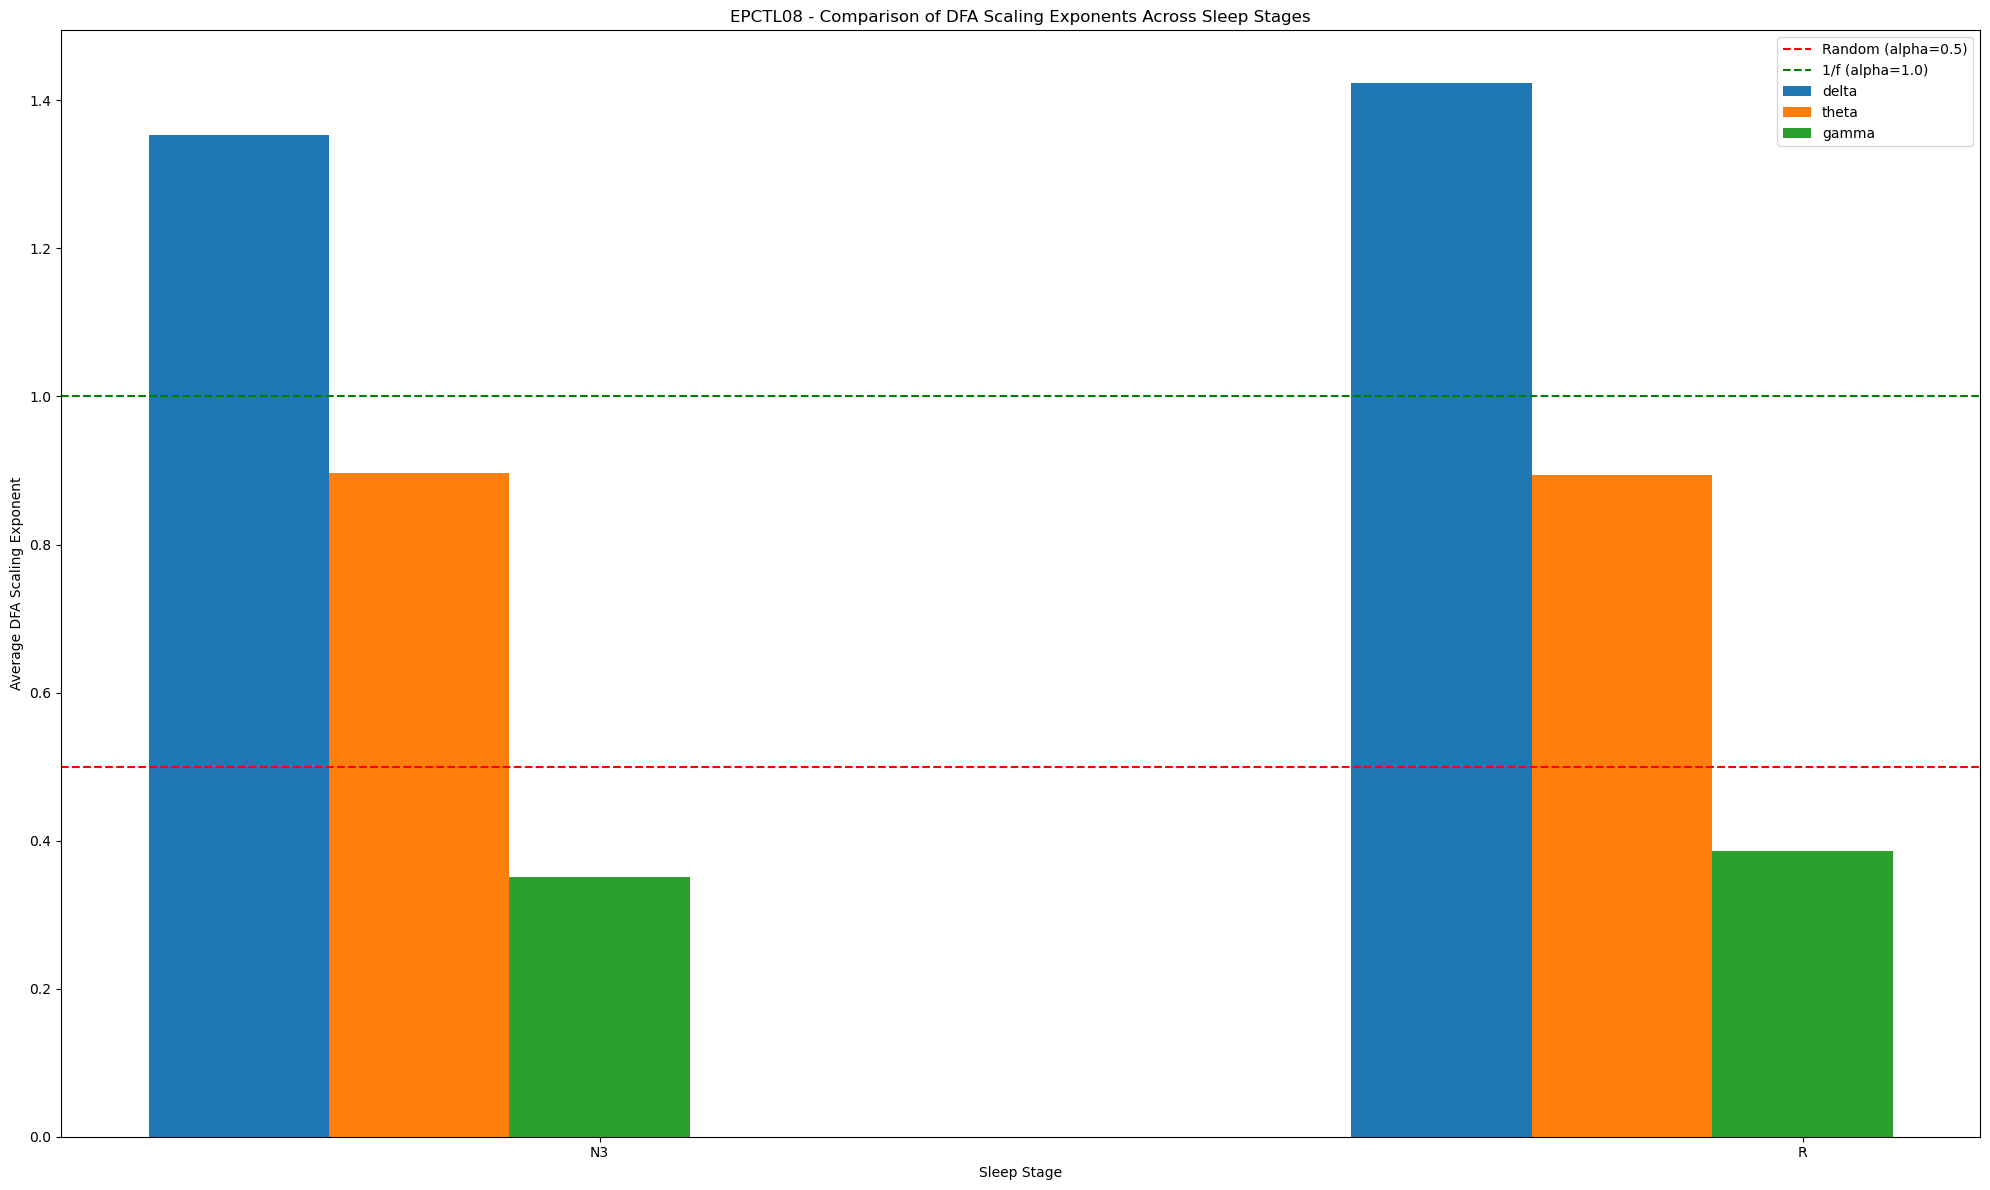

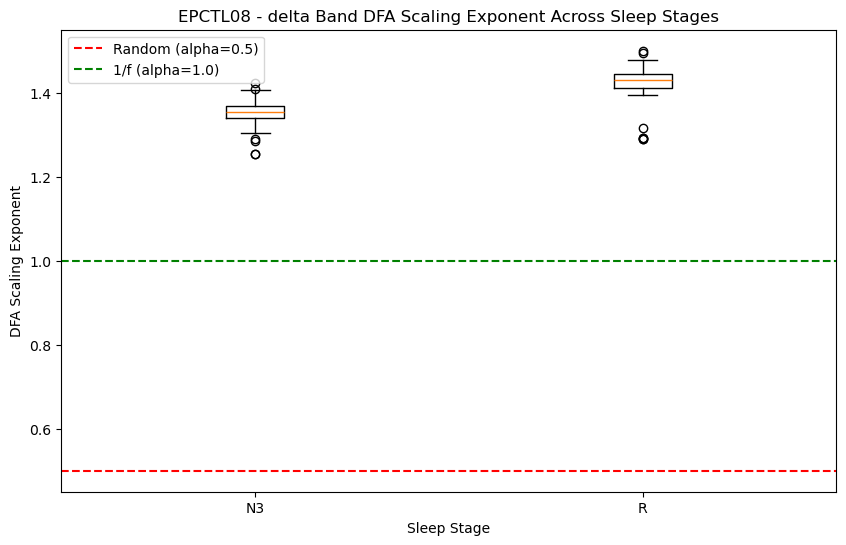

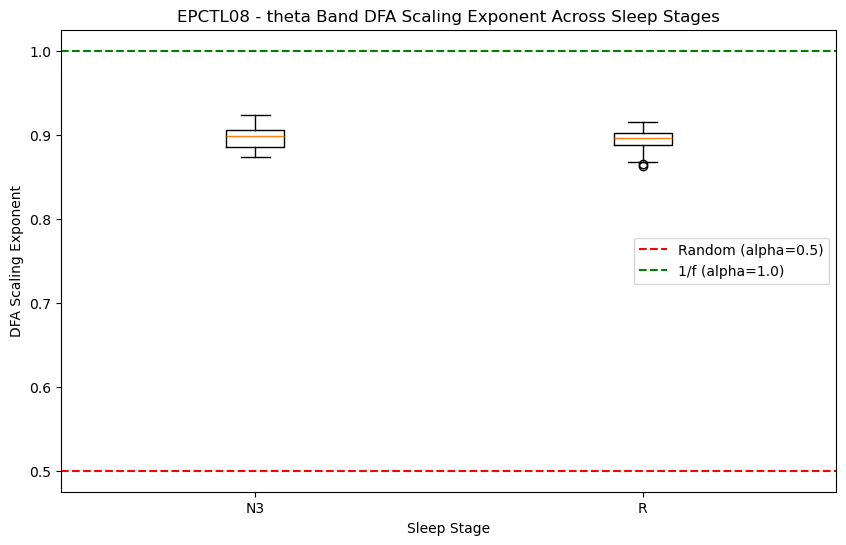

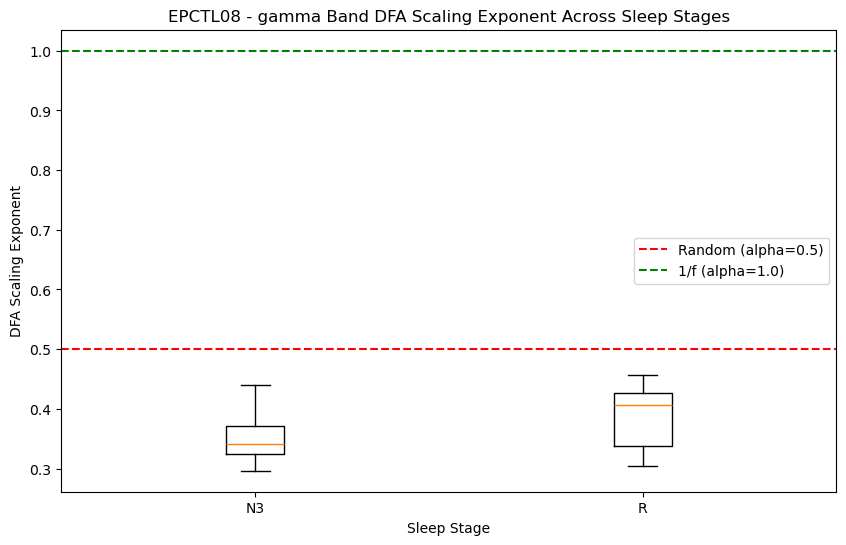

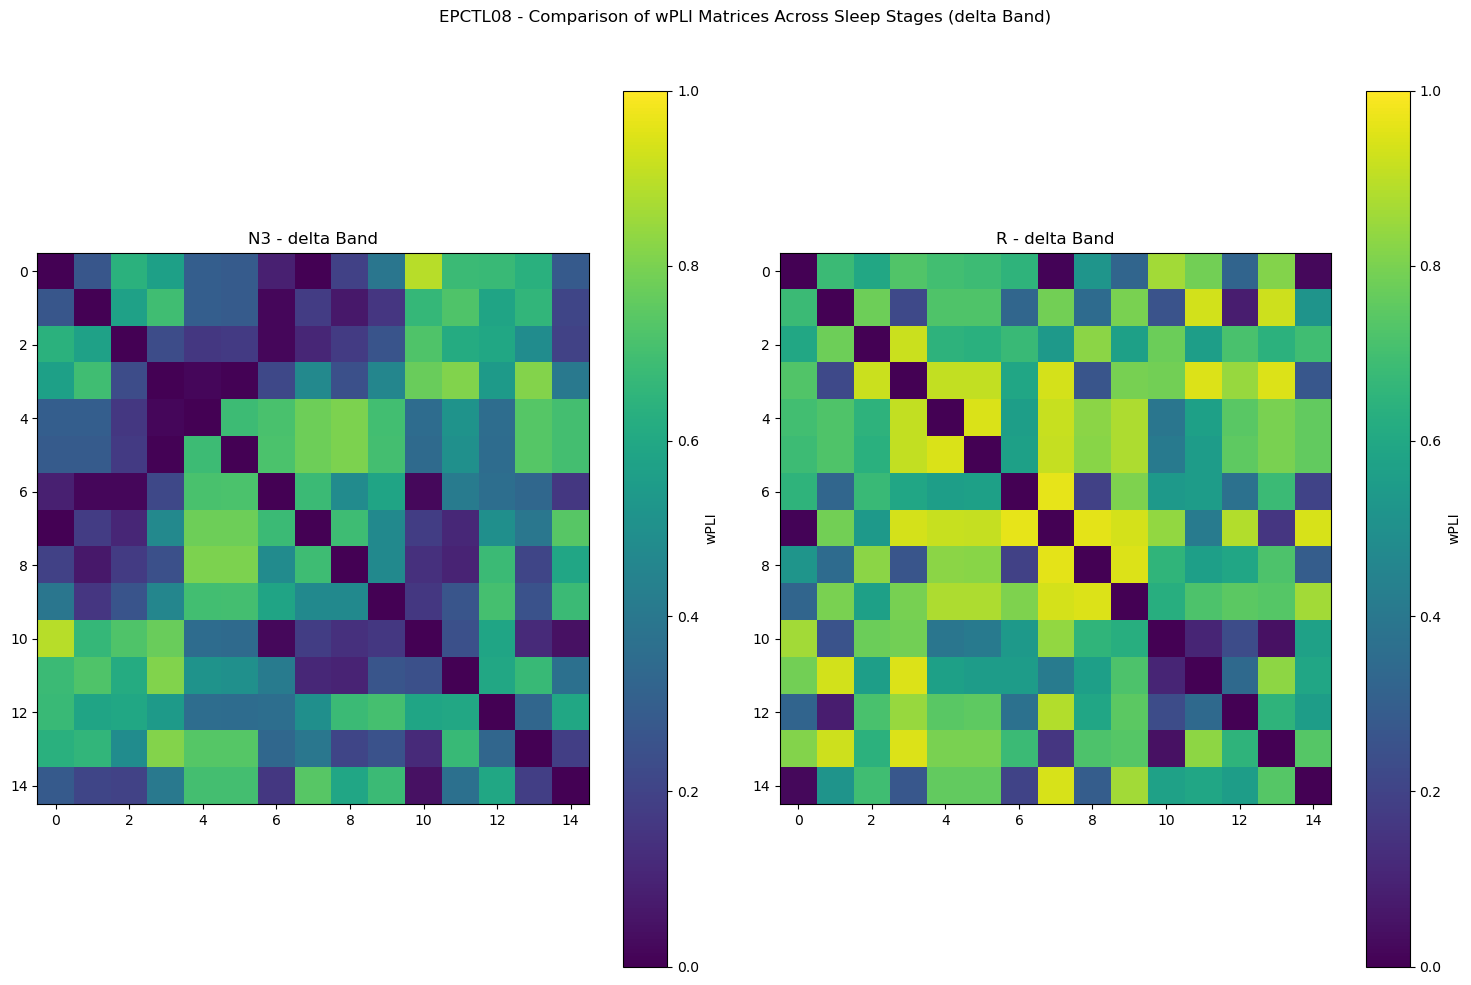

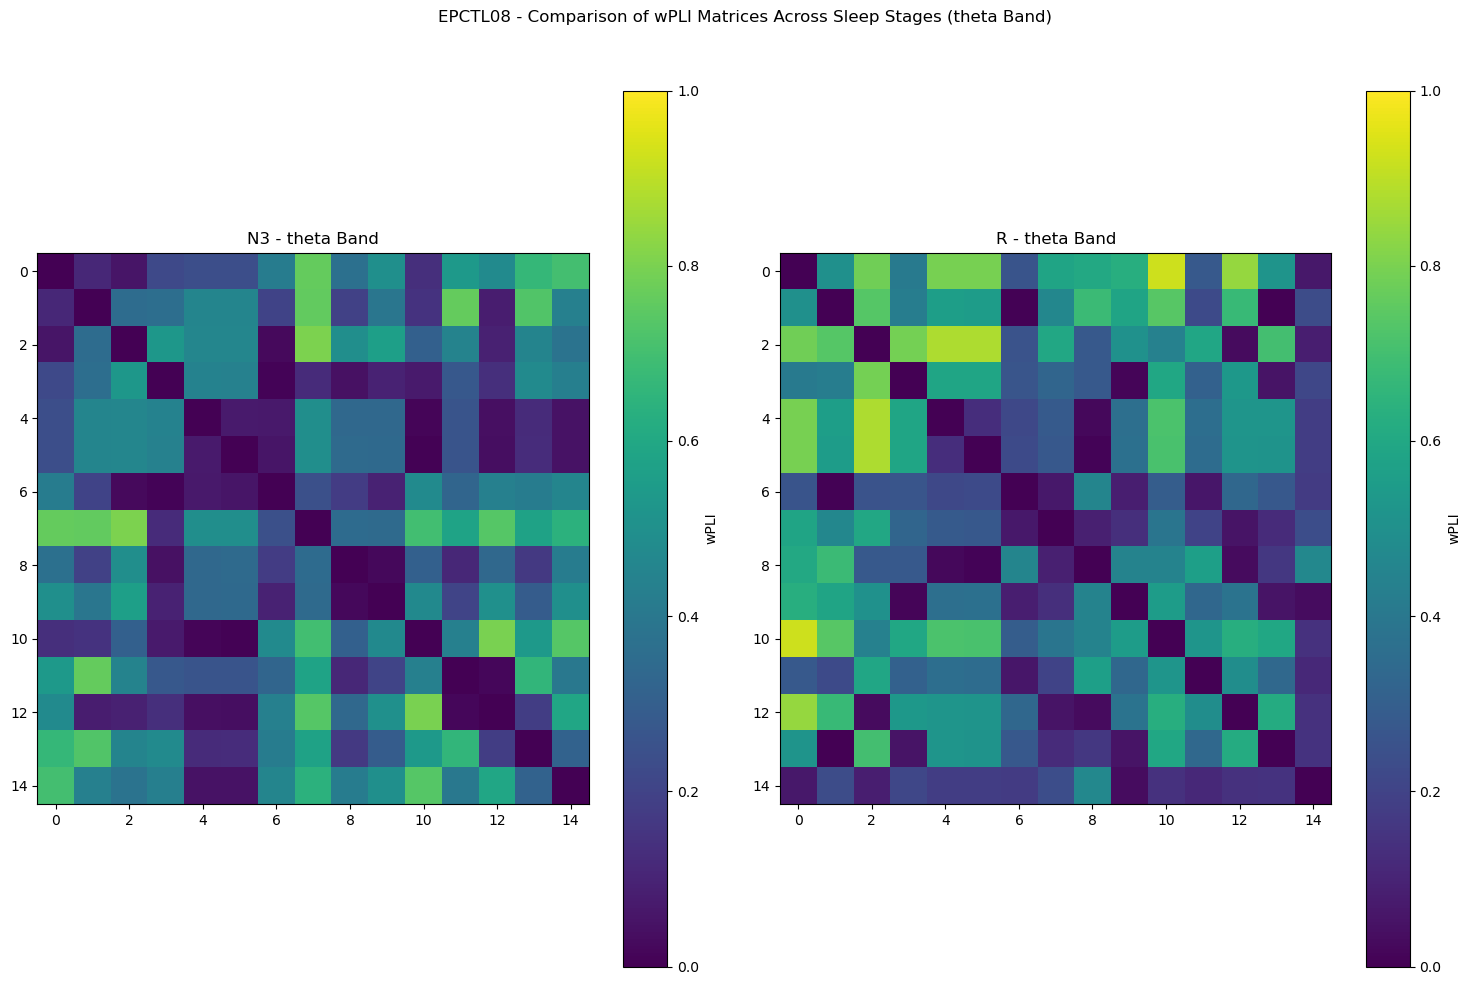

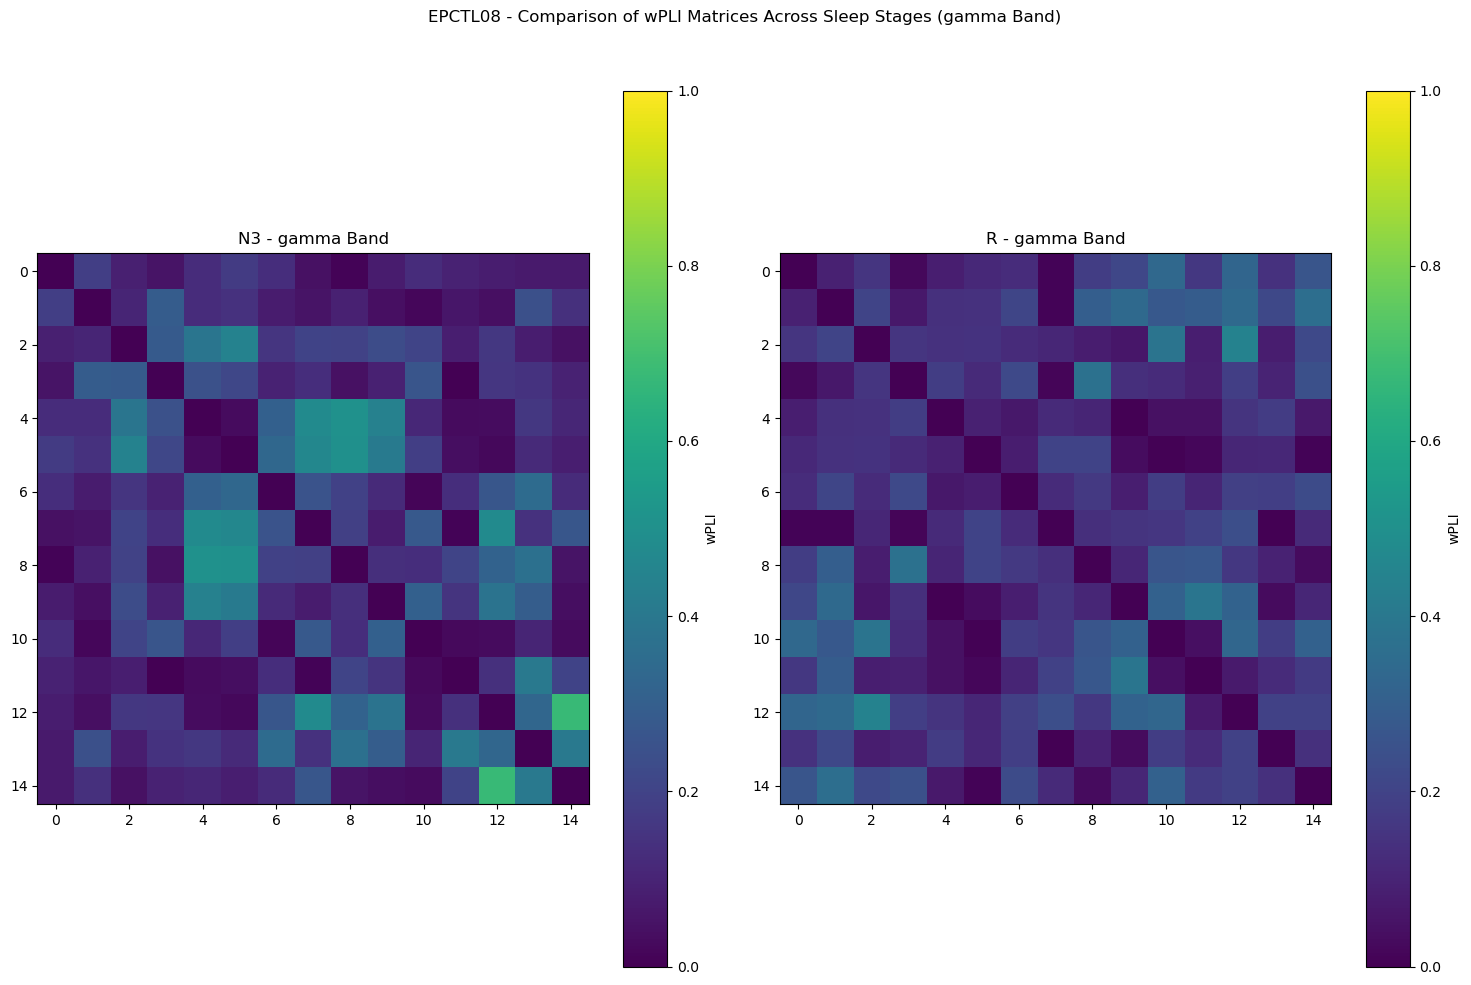

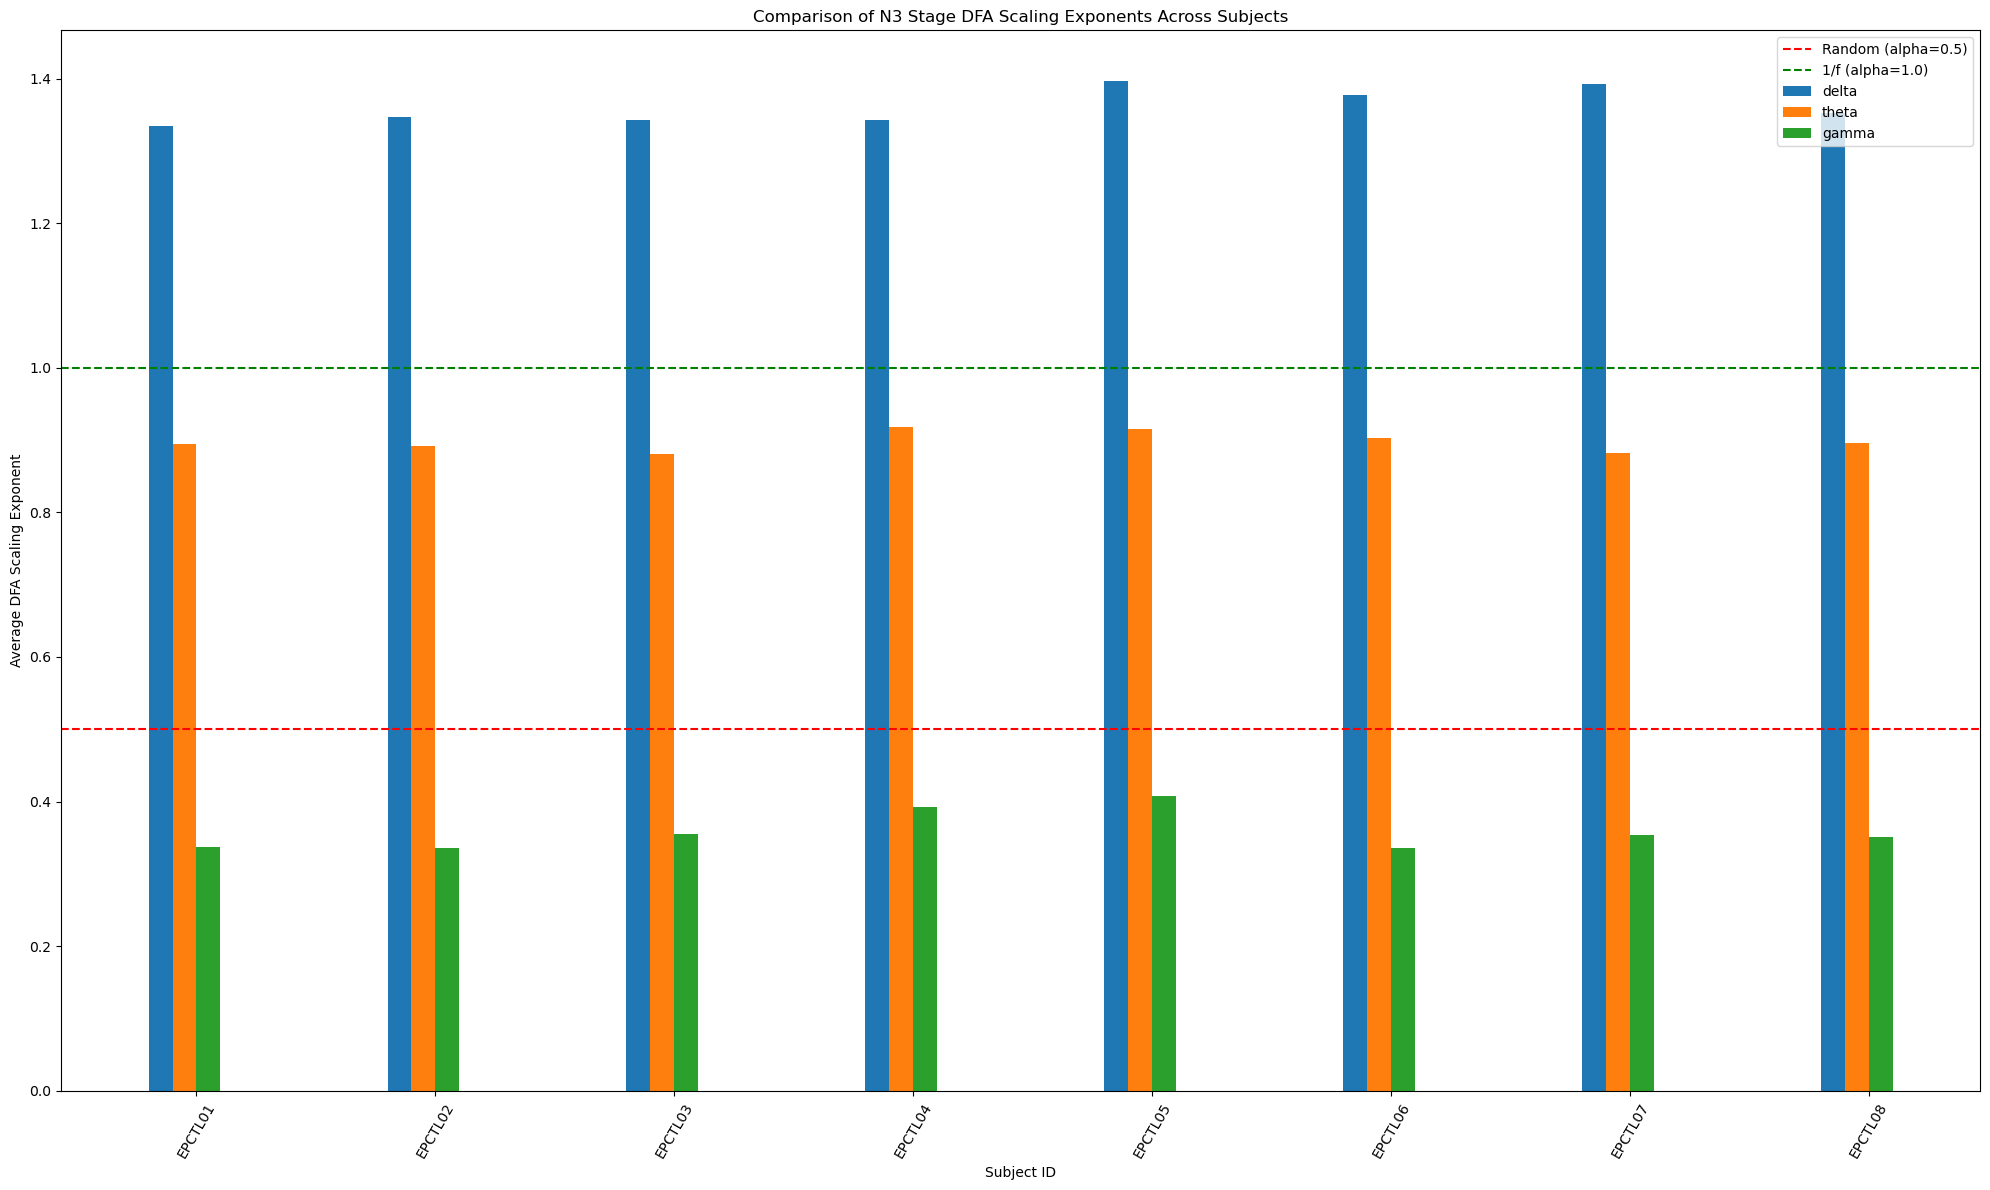

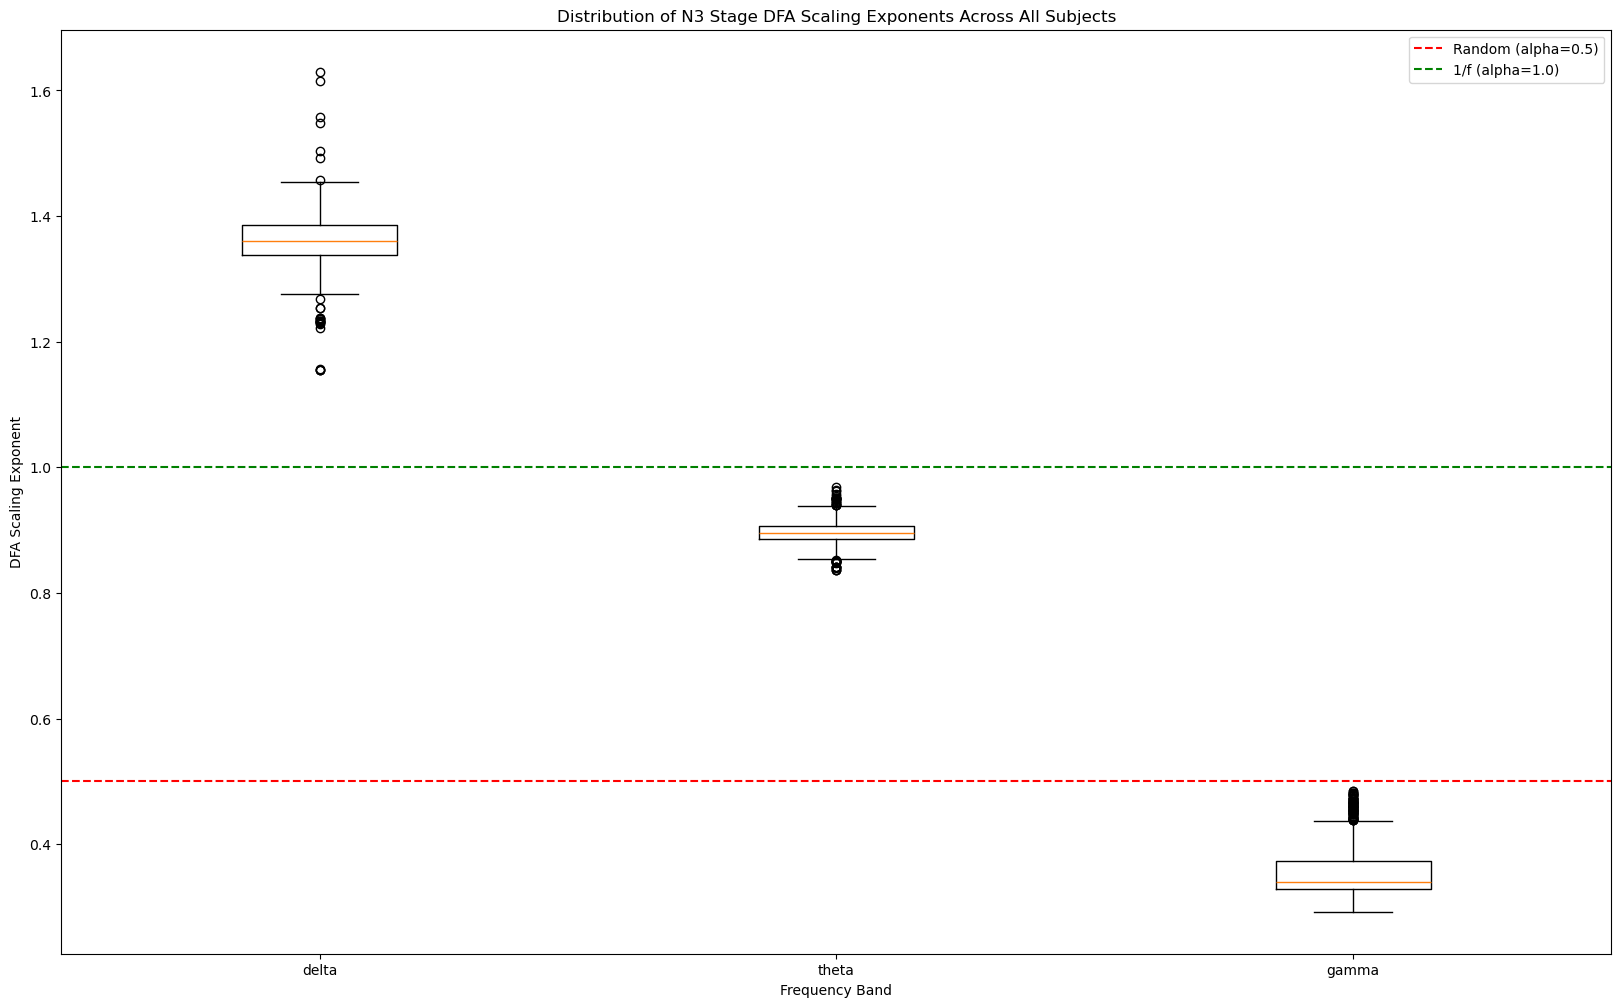

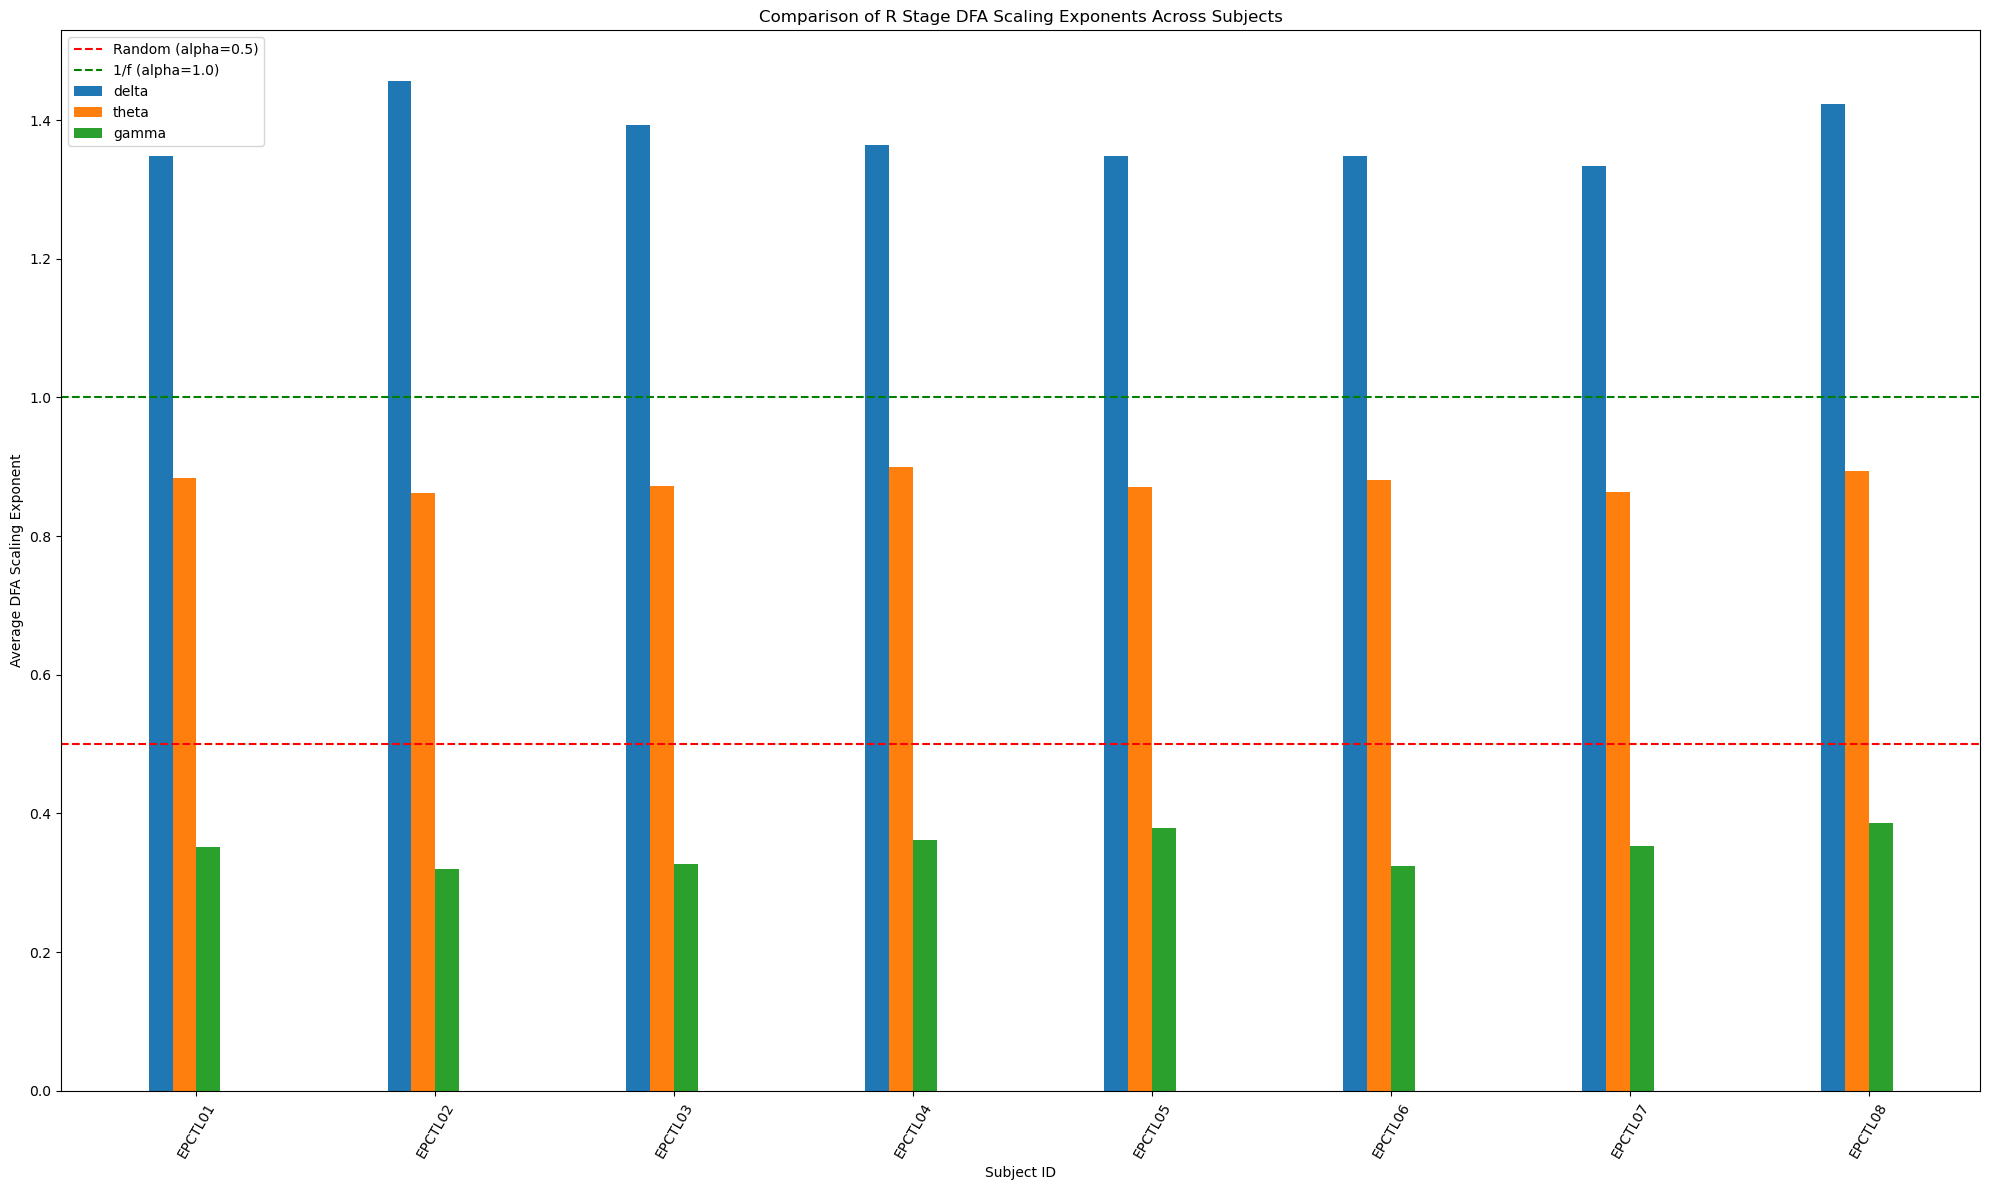

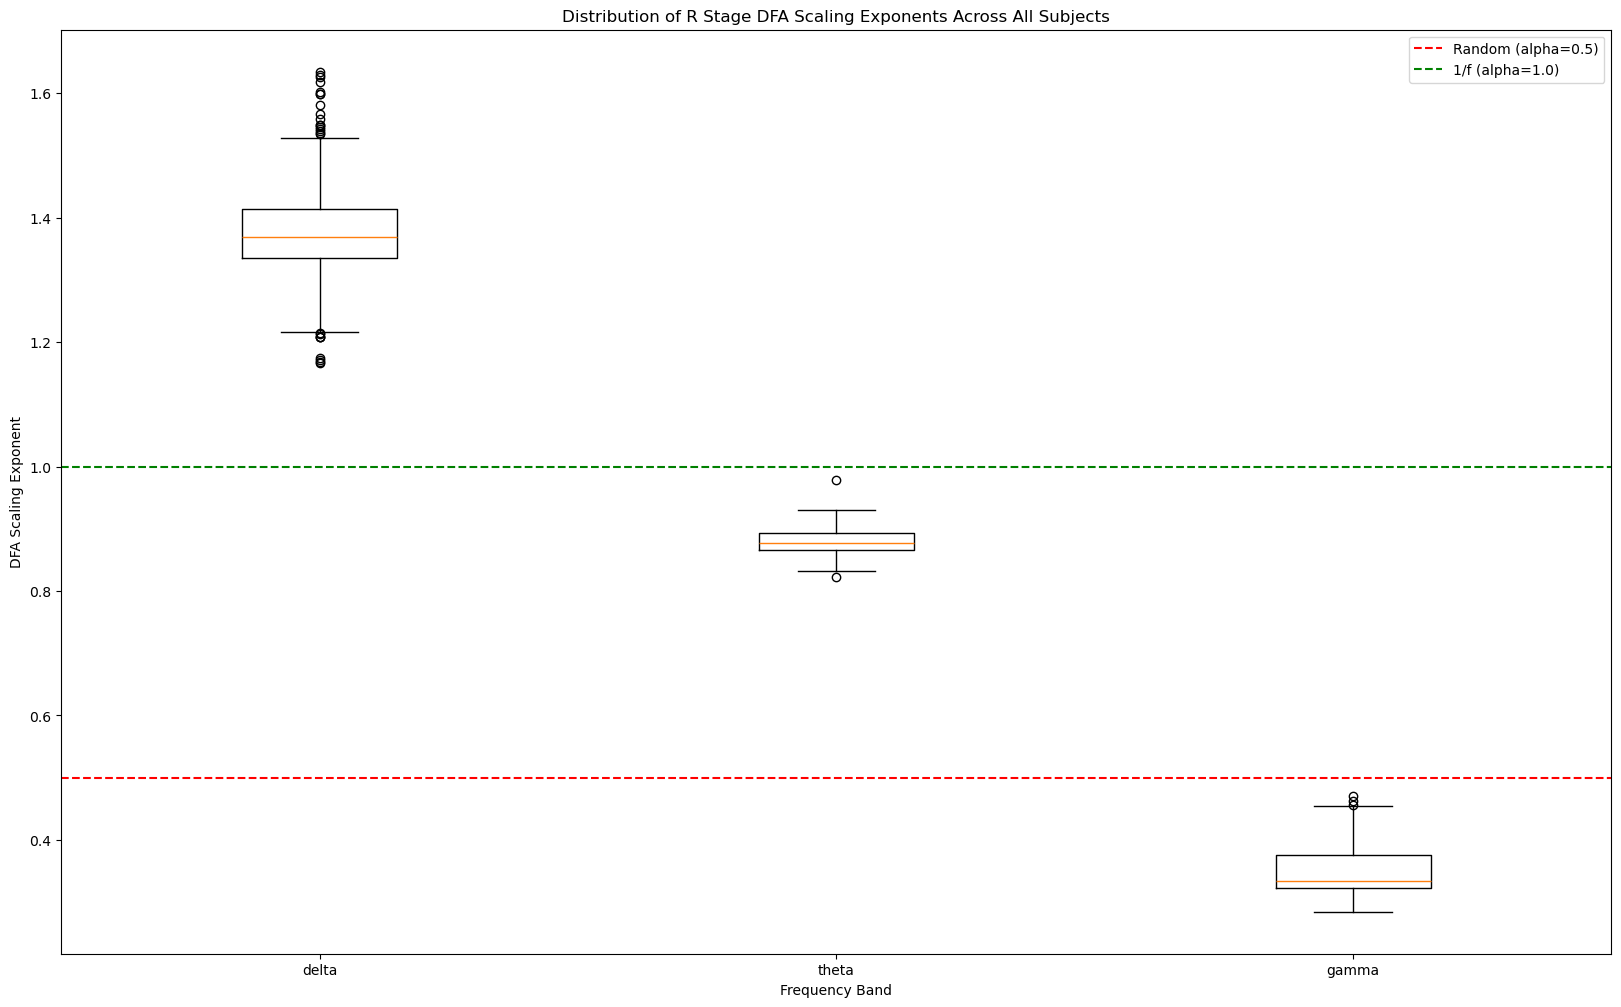

In [24]:
# Run the script
if __name__ == '__main__':
    main()
